# Module and DASK setting

In [1]:
# DASK client set

import os
import sys
from dask.distributed import Client
# client = Client(scheduler_file='/proj/kimyy/Dropbox/source/python/all/mpi/scheduler.json', threads_per_worker=2, n_workers=6)
client = Client(scheduler_file='/proj/kimyy/Dropbox/source/python/all/mpi/scheduler.json')
# client = Client(scheduler_file='/proj/kimyy/Dropbox/source/python/all/mpi/scheduler_10.json')  

def setup_module_path():
    module_path = '/proj/kimyy/Dropbox/source/python/all/Modules/CESM2'
    if module_path not in sys.path:
        sys.path.append(module_path)

client.run(setup_module_path)

client

# get path for path changes in Jupyter notebook: File - Open from Path - insert relative_path
notebook_path = os.path.abspath(".")
_, _, relative_path = notebook_path.partition('/all/')
relative_path = '/all/' + relative_path
relative_path

OSError: Timed out trying to connect to tcp://203.247.189.224:36812 after 30 s

In [ ]:
# load public modules

import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patches as patches
import matplotlib.ticker as mticker
import matplotlib.path as mpath
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from scipy import stats
from scipy.interpolate import griddata
import cmocean
from cmcrameri import cm
import warnings
warnings.simplefilter(action='ignore')
import pandas as pd
import cftime
import pop_tools
from pprint import pprint
import time
import subprocess
import re as re_mod
import cftime
import datetime
from scipy.stats import ttest_1samp
import xcesm
# from scipy.stats import pearsonr
from scipy.stats import t

In [ ]:
# load private modules

import sys
sys.path.append('/proj/kimyy/Dropbox/source/python/all/Modules/CESM2')
from KYY_CESM2_preprocessing import CESM2_config

savefilepath = "/mnt/lustre/proj/kimyy/tmp_python/HCST_paper_figure_1"


# physical variable setting (SSH, geostrophic velocity)

In [ ]:
# set SSH
cfg_var_SSH=CESM2_config()
cfg_var_SSH.year_s=1960
cfg_var_SSH.year_e=2020

cfg_var_SSH.setvar('SSH')
cfg_var_SSH.list()

start_date = cftime.DatetimeNoLeap(cfg_var_SSH.year_s, 2, 1)
end_date = cftime.DatetimeNoLeap(cfg_var_SSH.year_e+1, 1, 1)

if cfg_var_SSH.comp=='ocn':
    ds_grid = pop_tools.get_grid('POP_gx1v7')

In [ ]:
# set TEMP
cfg_var_TEMP=CESM2_config()
cfg_var_TEMP.year_s=1960
cfg_var_TEMP.year_e=2020
cfg_var_TEMP.setvar('TEMP')

In [ ]:
# define preprocessing function

exceptcv=['time','lon','lat', 'TLONG', 'TLAT', 'TEMP', 'SSH']

def process_coords_surface(
    ds, sd, ed, varname, drop=True,
    except_coord_vars=["time","lon","lat","TLONG","TLAT","SSH","TEMP"]
):
    import xcesm
    import numpy as np

    coord_vars = []
    for v in np.array(ds.coords):
        if v not in except_coord_vars:
            coord_vars.append(v)
    for v in np.array(ds.data_vars):
        if v not in except_coord_vars:
            coord_vars.append(v)

    if drop:
        ds = ds.drop(coord_vars)
        ds = ds.sel(time=slice(sd, ed))
        ds = ds.isel(z_t=0)  # pick surface layer
        # Access varname properly with ds[varname]
        ds_rgd = ds[varname].utils.regrid()
        # ds_rgd = ds[varname].utils.regrid(dlon=2, dlat=2)

        new_time = ds_rgd.time - np.array([datetime.timedelta(days=15)] * len(ds.time))
        ds_rgd = ds_rgd.assign_coords(time=new_time)
        ds_rgd=ds_rgd.groupby('time.year').mean(dim='time', skipna=True)
        
        return ds_rgd
    else:
        return ds.set_coords(coord_vars)


def process_coords_2d(
    ds, sd, ed, varname, drop=True,
    except_coord_vars=["time","lon","lat","TLONG","TLAT","SSH","TEMP"]
):
    import xcesm
    import numpy as np

    coord_vars = []
    for v in np.array(ds.coords):
        if v not in except_coord_vars:
            coord_vars.append(v)
    for v in np.array(ds.data_vars):
        if v not in except_coord_vars:
            coord_vars.append(v)

    if drop:
        ds = ds.drop(coord_vars)
        ds = ds.sel(time=slice(sd, ed))
        # Access varname properly with ds[varname]
        ds_rgd = ds[varname].utils.regrid()
        # ds_rgd = ds[varname].utils.regrid(dlon=2, dlat=2)

        new_time = ds_rgd.time - np.array([datetime.timedelta(days=15)] * len(ds.time))
        ds_rgd = ds_rgd.assign_coords(time=new_time)
        ds_rgd=ds_rgd.groupby('time.year').mean(dim='time', skipna=True)

        return ds_rgd
    else:
        return ds.set_coords(coord_vars)


def process_coords_hcst(ds, drop=True, except_coord_vars=['time','lon','lat', 'TLONG', 'TLAT', 'SSH', 'TEMP']):
    """Preprocessor function to drop all non-dim coords, which slows down concatenation."""
    coord_vars = []
    for v in np.array(ds.coords) :
        if not v in except_coord_vars:
            coord_vars += [v]
    for v in np.array(ds.data_vars) :
        if not v in except_coord_vars:
            coord_vars += [v]
    
    if drop:
        ds= ds.drop(coord_vars)
        return ds
    else:
        return ds.set_coords(coord_vars)

In [ ]:
# Read LE dataset (SSH)

start_time = time.time()

cfg_var_SSH.LE_path_load(cfg_var_SSH.var)
cfg_var_SSH.LE_ds = xr.open_mfdataset(cfg_var_SSH.LE_file_list[0], 
                       chunks={'time': 12}, 
                       combine='nested', 
                       concat_dim=[[*cfg_var_SSH.LE_ensembles], 'time'], 
                       parallel=True,
                       preprocess=lambda ds: process_coords_2d(ds, start_date, end_date, 'SSH'),
                       decode_cf=True, 
                       decode_times=True)      


cfg_var_SSH.LE_ds = cfg_var_SSH.LE_ds.rename({"concat_dim": "ens_LE"})
cfg_var_SSH.LE_ds=cfg_var_SSH.LE_ds.compute()

end_time = time.time()
elapsed_time = end_time - start_time
print('elasped time for reading LE: ' + str(elapsed_time))

In [ ]:
# Read ODA dataset (SSH)

start_time = time.time()

cfg_var_SSH.ODA_path_load(cfg_var_SSH.var)

ODA_ds = xr.open_mfdataset(cfg_var_SSH.ODA_file_list[0][0:10],
                           chunks={'time': 12}, 
                           combine='nested', 
                           concat_dim=[[*cfg_var_SSH.ODA_ensembles[0:10]], 'year'], 
                           parallel=True,
                           preprocess=lambda ds: process_coords_2d(ds, start_date, end_date, 'SSH'),
                           decode_cf=True, 
                           decode_times=True)

ODA_ds2 = xr.open_mfdataset(cfg_var_SSH.ODA_file_list[0][10:20], 
                           chunks={'time': 12}, 
                           combine='nested', 
                           concat_dim=[[*cfg_var_SSH.ODA_ensembles[10:20]], 'year'], 
                           parallel=True,
                           preprocess=lambda ds: process_coords_2d(ds, start_date, end_date, 'SSH'),
                           decode_cf=True, 
                           decode_times=True)

# en4.2 -> until 2021; projdv7.3 -> until 2020; need to be read separately
ODA_ds_a = []
ODA_ds_a.append(ODA_ds)
ODA_ds_xr = xr.concat(ODA_ds_a, dim='year')
ODA_ds_xr = ODA_ds_xr.expand_dims({'ens': range(10)})

ODA_ds2_a = []
ODA_ds2_a.append(ODA_ds2)
ODA_ds2_xr = xr.concat(ODA_ds2_a, dim='year')
ODA_ds2_xr = ODA_ds2_xr.expand_dims({'ens': range(10, 20)})

cfg_var_SSH.ODA_ds = []
cfg_var_SSH.ODA_ds.append(ODA_ds_xr)
cfg_var_SSH.ODA_ds.append(ODA_ds2_xr)
# cfg_var_SSH.ODA_ds = cfg_var_SSH.ODA_ds.drop('time')
cfg_var_SSH.ODA_ds = xr.concat(cfg_var_SSH.ODA_ds, dim='ens')
cfg_var_SSH.ODA_ds = cfg_var_SSH.ODA_ds.reindex(ens=list(range(1, 20+1)))
cfg_var_SSH.ODA_ds = cfg_var_SSH.ODA_ds.sortby('year')

cfg_var_SSH.ODA_ds = cfg_var_SSH.ODA_ds.rename({"concat_dim": "ens_ODA"})
cfg_var_SSH.ODA_ds = cfg_var_SSH.ODA_ds.drop('ens')
cfg_var_SSH.ODA_ds=cfg_var_SSH.ODA_ds.mean(dim='ens')
cfg_var_SSH.ODA_ds=cfg_var_SSH.ODA_ds.compute()
end_time = time.time()
elapsed_time = end_time - start_time
print('elasped time for reading ODA: ' + str(elapsed_time))

In [ ]:
#Read ADA dataset (SSH)
start_time = time.time()

cfg_var_SSH.ADA_path_load(cfg_var_SSH.var)
cfg_var_SSH.ADA_ds = xr.open_mfdataset(cfg_var_SSH.ADA_file_list[0], 
                       chunks={'time': 12}, 
                       combine='nested',
                       concat_dim=[[*cfg_var_SSH.ADA_ensembles], 'time'], 
                       parallel=True,
                       preprocess=lambda ds: process_coords_2d(ds, start_date, end_date, 'SSH'),
                       decode_cf=True, 
                       decode_times=True)      


cfg_var_SSH.ADA_ds = cfg_var_SSH.ADA_ds.rename({"concat_dim": "ens_ADA"})
cfg_var_SSH.ADA_ds=cfg_var_SSH.ADA_ds.compute()

end_time = time.time()
elapsed_time = end_time - start_time
print('elasped time for reading ADA: ' + str(elapsed_time))

In [ ]:
# Read Observation dataset (SSH)
start_time = time.time()

cfg_var_SSH.OBS_path_load(cfg_var_SSH.var)
cfg_var_SSH.OBS_ds = xr.open_mfdataset(cfg_var_SSH.OBS_file_list[0][0], 
                       chunks={'time': 12}, 
                       parallel=True,
                       decode_cf=True, 
                       decode_times=True,)
cfg_var_SSH.OBS_ds = cfg_var_SSH.OBS_ds.rename({cfg_var_SSH.OBS_var: cfg_var_SSH.var})


# global mean removal for SSH
if cfg_var_SSH.var=='SSH':
    lat_mask = (ds_grid.TLAT >= -60) & (ds_grid.TLAT <= 60)

    area_selected = ds_grid.TAREA.where(lat_mask, drop=True)  # 선택된 지역의 면적
    ssh_selected = cfg_var_SSH.OBS_ds[cfg_var_SSH.var].where(lat_mask, drop=True)  # 선택된 지역의 SSH 데이터

    # 필터링된 지역에 대해 global mean 계산
    cfg_var_SSH.OBS_ds['gm'] = (ssh_selected * area_selected).sum(dim=['nlat', 'nlon']) / area_selected.sum(dim=['nlat', 'nlon'])
    
    # 원 데이터에서 global mean을 제거한 값
    cfg_var_SSH.OBS_ds['SSH'] = cfg_var_SSH.OBS_ds[cfg_var_SSH.var] - cfg_var_SSH.OBS_ds['gm']


cfg_var_SSH.OBS_ds = cfg_var_SSH.OBS_ds[cfg_var_SSH.var].utils.regrid()

if cfg_var_SSH.var=='SSH':
    cfg_var_SSH.OBS_ds=cfg_var_SSH.OBS_ds.assign_coords(time=cfg_var_SSH.OBS_ds.sel(time=slice("1993-01-01", "2020-12-31")).time) #1993~2020
elif cfg_var_photoC_TOT_100m.var=='photoC_TOT_100m':
    cfg_var_photoC_TOT_100m.OBS_ds=cfg_var_photoC_TOT_100m.OBS_ds.assign_coords(time=cfg_var_photoC_TOT_100m.OBS_ds.sel(time=slice("1999-01-01", "2020-12-31")).time) #1999~2020

cfg_var_SSH.OBS_ds=cfg_var_SSH.OBS_ds.groupby('time.year').mean(dim='time', skipna=True)
cfg_var_SSH.OBS_ds = cfg_var_SSH.OBS_ds.assign_coords(time=cfg_var_SSH.ODA_ds.year)

end_time = time.time()
elapsed_time = end_time - start_time
print('elasped time for reading OBS: ' + str(elapsed_time))

# Geostrophic velocity from PD and SSH

In [ ]:
def process_coords_gv_100m(
    ds, sd, ed, varname, drop=True,
    except_coord_vars=["time","lon","lat","TLONG","TLAT", "TEMP", "PD"]
):
    import xcesm
    import numpy as np
    import datetime
    
    coord_vars = []
    for v in np.array(ds.coords):
        if v not in except_coord_vars:
            coord_vars.append(v)
    for v in np.array(ds.data_vars):
        if v not in except_coord_vars:
            coord_vars.append(v)

    if drop:
        ds = ds.drop(coord_vars)
        ds = ds.sel(time=slice(sd, ed))
        ds = ds.isel(z_t=slice(0,10)) 
        # Access varname properly with ds[varname]
        ds_rgd = ds[varname].utils.regrid()
        # ds_rgd = ds[varname].utils.regrid(dlon=2, dlat=2)

        new_time = ds_rgd.time - np.array([datetime.timedelta(days=15)] * len(ds.time))
        ds_rgd = ds_rgd.assign_coords(time=new_time)
        # ds_rgd=ds_rgd.groupby('time.year').mean(dim='time', skipna=True)
        
        return ds_rgd
    else:
        return ds.set_coords(coord_vars)


def process_coords_gv_2d(
    ds, sd, ed, varname, drop=True,
    except_coord_vars=["time","lon","lat","TLONG","TLAT","SSH"]
):
    import xcesm
    import numpy as np
    import datetime

    coord_vars = []
    for v in np.array(ds.coords):
        if v not in except_coord_vars:
            coord_vars.append(v)
    for v in np.array(ds.data_vars):
        if v not in except_coord_vars:
            coord_vars.append(v)

    if drop:
        ds = ds.drop(coord_vars)
        ds = ds.sel(time=slice(sd, ed))
        ds_rgd = ds[varname].utils.regrid()

        new_time = ds_rgd.time - np.array([datetime.timedelta(days=15)] * len(ds.time))
        ds_rgd = ds_rgd.assign_coords(time=new_time)
        # ds_rgd=ds_rgd.groupby('time.year').mean(dim='time', skipna=True)

        return ds_rgd
    else:
        return ds.set_coords(coord_vars)


def process_coords_gv_100m_hcst(
    ds, sd, ed, varname, drop=True,
    except_coord_vars=["time","lon","lat","TLONG","TLAT", "TEMP", "PD"]
):
    import xcesm
    import numpy as np
    import datetime

    coord_vars = []
    for v in np.array(ds.coords):
        if v not in except_coord_vars:
            coord_vars.append(v)
    for v in np.array(ds.data_vars):
        if v not in except_coord_vars:
            coord_vars.append(v)

    if drop:
        ds = ds.drop(coord_vars)
        ds = ds.isel(z_t=slice(0,10)) 
        # Access varname properly with ds[varname]
        ds_rgd = ds[varname].utils.regrid()
        # ds_rgd = ds[varname].utils.regrid(dlon=2, dlat=2)

        new_time = ds_rgd.time - np.array([datetime.timedelta(days=15)] * len(ds.time))
        ds_rgd = ds_rgd.assign_coords(time=new_time)
        # ds_rgd=ds_rgd.groupby('time.year').mean(dim='time', skipna=True)
        
        return ds_rgd
    else:
        return ds.set_coords(coord_vars)


def process_coords_gv_2d_hcst(
    ds, sd, ed, varname, drop=True,
    except_coord_vars=["time","lon","lat","TLONG","TLAT","SSH"]
):
    import xcesm
    import numpy as np
    import datetime

    coord_vars = []
    for v in np.array(ds.coords):
        if v not in except_coord_vars:
            coord_vars.append(v)
    for v in np.array(ds.data_vars):
        if v not in except_coord_vars:
            coord_vars.append(v)

    if drop:
        ds = ds.drop(coord_vars)
        ds_rgd = ds[varname].utils.regrid()

        new_time = ds_rgd.time - np.array([datetime.timedelta(days=15)] * len(ds.time))
        ds_rgd = ds_rgd.assign_coords(time=new_time)
        # ds_rgd=ds_rgd.groupby('time.year').mean(dim='time', skipna=True)

        return ds_rgd
    else:
        return ds.set_coords(coord_vars)

In [ ]:
def cal_geostrop(
    PD, SSH
):
    import xcesm
    import numpy as np

    dz=10
    g=9.81
    P = PD * g * dz
    P = xr.where(
        P.z_t == 0,
        P['PD'] + ( PD['PD'] * SSH['SSH'] / 100 * g ),
        PD * g * dz
    )
    bottom_pressure = P.cumsum(dim="z_t")

    bottom_pressure_dlon = bottom_pressure.differentiate(coord="lon")
    bottom_pressure_dlat = bottom_pressure.differentiate(coord="lat")

    R = 6371_000.0
    deg2rad = np.pi / 180.0
    
    bottom_pressure_dx = bottom_pressure_dlon / (R * np.cos(np.deg2rad(bottom_pressure.lat)) * deg2rad)
    bottom_pressure_dy = bottom_pressure_dlat / (R * deg2rad)

    Omega = 7.2921159e-5  # Earth's rotation rate
    lat_radians = np.deg2rad(bottom_pressure.lat)
    f = 2.0 * Omega * np.sin(lat_radians)
    
    gu = - (1 / f) * bottom_pressure_dy / PD  # Eastward (lon) direction
    gv = (1 / f) * bottom_pressure_dx / PD  # Northward (lat) direction

    gu_surf= gu.isel(z_t=0).groupby('time.year').mean(dim='time', skipna=True)
    gv_surf= gv.isel(z_t=0).groupby('time.year').mean(dim='time', skipna=True)
    gu_mean= gu.mean(dim='z_t').groupby('time.year').mean(dim='time', skipna=True)
    gv_mean= gv.mean(dim='z_t').groupby('time.year').mean(dim='time', skipna=True)
    
    return gu_surf, gv_surf, gu_mean, gv_mean


In [ ]:
# # Read LE dataset (original)

# cfg_var_gv_PD=CESM2_config()
# cfg_var_gv_PD.year_s=1960
# cfg_var_gv_PD.year_e=2020
# cfg_var_gv_PD.setvar('PD')

# start_time = time.time()

# cfg_var_gv_PD.LE_path_load(cfg_var_gv_PD.var)
# cfg_var_gv_PD.LE_ds = xr.open_mfdataset(cfg_var_gv_PD.LE_file_list[0], 
#                        chunks={'time': 12}, 
#                        combine='nested', 
#                        concat_dim=[[*cfg_var_gv_PD.LE_ensembles], 'time'], 
#                        parallel=True,
#                        preprocess=lambda ds: process_coords_gv_100m(ds, start_date, end_date, 'PD'),
#                        decode_cf=True, 
#                        decode_times=True)      


# cfg_var_gv_PD.LE_ds = cfg_var_gv_PD.LE_ds.rename({"concat_dim": "ens_LE"})
# cfg_var_gv_PD.LE_ds=cfg_var_gv_PD.LE_ds


# cfg_var_gv_SSH=CESM2_config()
# cfg_var_gv_SSH.year_s=1960
# cfg_var_gv_SSH.year_e=2020
# cfg_var_gv_SSH.setvar('SSH')

# start_time = time.time()

# cfg_var_gv_SSH.LE_path_load(cfg_var_gv_SSH.var)
# cfg_var_gv_SSH.LE_ds = xr.open_mfdataset(cfg_var_gv_SSH.LE_file_list[0], 
#                        chunks={'time': 12}, 
#                        combine='nested', 
#                        concat_dim=[[*cfg_var_gv_SSH.LE_ensembles], 'time'], 
#                        parallel=True,
#                        preprocess=lambda ds: process_coords_gv_100m(ds, start_date, end_date, 'PD'),
#                        decode_cf=True, 
#                        decode_times=True)      


# cfg_var_gv_SSH.LE_ds = cfg_var_gv_SSH.LE_ds.rename({"concat_dim": "ens_LE"})
# cfg_var_gv_SSH.LE_ds=cfg_var_gv_SSH.LE_ds



# end_time = time.time()
# elapsed_time = end_time - start_time
# print('elasped time for reading LE: ' + str(elapsed_time))

In [ ]:
# Calculate LE geostrophic velocity

cfg_var_gv_PD=CESM2_config()
cfg_var_gv_PD.year_s=1960
cfg_var_gv_PD.year_e=2020
cfg_var_gv_PD.setvar('PD')

cfg_var_gv_SSH=CESM2_config()
cfg_var_gv_SSH.year_s=1960
cfg_var_gv_SSH.year_e=2020
cfg_var_gv_SSH.setvar('SSH')

cfg_var_gv_u_surf=CESM2_config()
cfg_var_gv_v_surf=CESM2_config()
cfg_var_gv_u_100m_mean=CESM2_config()
cfg_var_gv_v_100m_mean=CESM2_config()

cfg_var_gv_u_surf.LE_ds = []
cfg_var_gv_v_surf.LE_ds = []
cfg_var_gv_u_100m_mean.LE_ds = []
cfg_var_gv_v_100m_mean.LE_ds = []

start_time = time.time()

fpath_gv_u_surf = savefilepath + "/LE_gv_u_surf_output.nc"
fpath_gv_v_surf = savefilepath + "/LE_gv_v_surf_output.nc"
fpath_gv_u_100m_mean = savefilepath + "/LE_gv_u_100m_mean_output.nc"
fpath_gv_v_100m_mean = savefilepath + "/LE_gv_v_100m_mean_output.nc"


if os.path.exists(fpath_gv_v_100m_mean):
    # File already exists => read it
    cfg_var_gv_u_surf.LE_ds = xr.open_dataset(fpath_gv_u_surf)
    cfg_var_gv_v_surf.LE_ds = xr.open_dataset(fpath_gv_v_surf)
    cfg_var_gv_u_100m_mean.LE_ds = xr.open_dataset(fpath_gv_u_100m_mean)
    cfg_var_gv_v_100m_mean.LE_ds = xr.open_dataset(fpath_gv_v_100m_mean)
    
    print(f"Opened existing geostrophic velocity data from {fpath_gv_v_100m_mean}")
    print('elasped time for reading LE : ' + str(elapsed_time))

else:
    cfg_var_gv_PD.LE_path_load(cfg_var_gv_PD.var)
    cfg_var_gv_SSH.LE_path_load(cfg_var_gv_SSH.var)
    
    for imem in range(0, len(cfg_var_gv_PD.LE_file_list[0])):
    # for imem in range(0, 2):
        PD_LE_ds_tmp = xr.open_mfdataset(cfg_var_gv_PD.LE_file_list[0][imem], 
                               chunks={'time': 1}, 
                               combine='nested',
                               # concat_dim=[[*cfg_var_gv_PD.LE_ensembles][imem], 'time'], 
                               parallel=True,
                               preprocess=lambda ds: process_coords_gv_100m(ds, start_date, end_date, 'PD'),
                               decode_cf=True, 
                               decode_times=True)
        SSH_LE_ds_tmp = xr.open_mfdataset(cfg_var_gv_SSH.LE_file_list[0][imem], 
                               chunks={'time': 1}, 
                               combine='nested',
                               # concat_dim=[[*cfg_var_gv_SSH.LE_ensembles][imem], 'time'], 
                               parallel=True,
                               preprocess=lambda ds: process_coords_gv_2d(ds, start_date, end_date, 'SSH'),
                               decode_cf=True, 
                               decode_times=True)
    
        [gv_u_surf_tmp, gv_v_surf_tmp, gv_u_100m_mean_tmp, gv_v_100m_mean_tmp] = cal_geostrop(PD_LE_ds_tmp, SSH_LE_ds_tmp)
    
        LE_ds_a= []
        LE_ds_a.append(gv_u_surf_tmp)
        LE_ds_xr = xr.concat(LE_ds_a, dim='year')
        LE_ds_xr = LE_ds_xr.expand_dims({'ens_LE': 1})
        cfg_var_gv_u_surf.LE_ds.append(LE_ds_xr)
    
        LE_ds_a= []
        LE_ds_a.append(gv_v_surf_tmp)
        LE_ds_xr = xr.concat(LE_ds_a, dim='year')
        LE_ds_xr = LE_ds_xr.expand_dims({'ens_LE': 1})
        cfg_var_gv_v_surf.LE_ds.append(LE_ds_xr)
    
        LE_ds_a= []
        LE_ds_a.append(gv_u_100m_mean_tmp)
        LE_ds_xr = xr.concat(LE_ds_a, dim='year')
        LE_ds_xr = LE_ds_xr.expand_dims({'ens_LE': 1})
        cfg_var_gv_u_100m_mean.LE_ds.append(LE_ds_xr)
    
        LE_ds_a= []
        LE_ds_a.append(gv_v_100m_mean_tmp)
        LE_ds_xr = xr.concat(LE_ds_a, dim='year')
        LE_ds_xr = LE_ds_xr.expand_dims({'ens_LE': 1})
        cfg_var_gv_v_100m_mean.LE_ds.append(LE_ds_xr)
    
        end_time = time.time()
        elapsed_time = end_time - start_time
        print('elasped time for reading LE, ' + str(imem) + ': ' + str(elapsed_time))
    
    cfg_var_gv_u_surf.LE_ds = xr.concat(cfg_var_gv_u_surf.LE_ds, dim='ens_LE')
    cfg_var_gv_v_surf.LE_ds = xr.concat(cfg_var_gv_v_surf.LE_ds, dim='ens_LE')
    cfg_var_gv_u_100m_mean.LE_ds = xr.concat(cfg_var_gv_u_100m_mean.LE_ds, dim='ens_LE')
    cfg_var_gv_v_100m_mean.LE_ds = xr.concat(cfg_var_gv_v_100m_mean.LE_ds, dim='ens_LE')
    
    cfg_var_gv_u_surf.LE_ds['ens_LE']=range(0, len(cfg_var_gv_PD.LE_file_list[0]))
    cfg_var_gv_v_surf.LE_ds['ens_LE']=range(0, len(cfg_var_gv_PD.LE_file_list[0]))
    cfg_var_gv_u_100m_mean.LE_ds['ens_LE']=range(0, len(cfg_var_gv_PD.LE_file_list[0]))
    cfg_var_gv_v_100m_mean.LE_ds['ens_LE']=range(0, len(cfg_var_gv_PD.LE_file_list[0]))
    
    # cfg_var_gv_u_surf.LE_ds['ens_LE']=range(0, 2)
    # cfg_var_gv_v_surf.LE_ds['ens_LE']=range(0, 2)
    # cfg_var_gv_u_100m_mean.LE_ds['ens_LE']=range(0, 2)
    # cfg_var_gv_v_100m_mean.LE_ds['ens_LE']=range(0, 2)
    
    cfg_var_gv_u_surf.LE_ds = cfg_var_gv_u_surf.LE_ds.rename({"PD": "gv_u_surf"})
    cfg_var_gv_v_surf.LE_ds = cfg_var_gv_v_surf.LE_ds.rename({"PD": "gv_v_surf"})
    cfg_var_gv_u_100m_mean.LE_ds = cfg_var_gv_u_100m_mean.LE_ds.rename({"PD": "gv_u_100m_mean"})
    cfg_var_gv_v_100m_mean.LE_ds = cfg_var_gv_v_100m_mean.LE_ds.rename({"PD": "gv_v_100m_mean"})
    
    # cfg_var_gv_u_surf.LE_ds.gv_u_surf.isel(ens_LE=0).isel(year=0).plot.pcolormesh()
    
    # elasped time for reading LE, 49: 10694.462686777115
    
    # save temporary file (LE)
    ds = cfg_var_gv_u_surf.LE_ds['gv_u_surf'].to_dataset(name="gv_u_surf")
    ds.to_netcdf(savefilepath + "/LE_gv_u_surf_output.nc")
    
    ds = cfg_var_gv_v_surf.LE_ds['gv_v_surf'].to_dataset(name="gv_v_surf")
    ds.to_netcdf(savefilepath + "/LE_gv_v_surf_output.nc")
    
    ds = cfg_var_gv_u_100m_mean.LE_ds['gv_u_100m_mean'].to_dataset(name="gv_u_100m_mean")
    ds.to_netcdf(savefilepath + "/LE_gv_u_100m_mean_output.nc")
    
    ds = cfg_var_gv_v_100m_mean.LE_ds['gv_v_100m_mean'].to_dataset(name="gv_v_100m_mean")
    ds.to_netcdf(savefilepath + "/LE_gv_v_100m_mean_output.nc")

    print(f"Computed geostrophic velocity and saved to {fpath_gv_v_100m_mean}")



# masking geostrophic velocities

In [ ]:
# to check mask shallower than 100m

cfg_var_gv_PD.LE_path_load(cfg_var_gv_PD.var)

PD_tmp = xr.open_mfdataset(cfg_var_gv_PD.LE_file_list[0][0][5], 
                           chunks={'time': 1}, 
                           combine='nested',
                           parallel=True,
                           preprocess=lambda ds: process_coords_gv_100m(ds, start_date, end_date, 'PD'),
                           decode_cf=True, 
                           decode_times=True)


# 1) Extract the deepest layer PD (z_t=9)
pd_deep = PD_tmp["PD"].isel(z_t=9)  # shape: (time, lat, lon)

# 2) Make a boolean mask: True where that layer is missing (NaN).
#    E.g. for each (time, lat, lon):
mask_shallow = pd_deep.isnull()

# If you want a single 2D mask (lat, lon) that is True
# whenever *any time* is missing:
mask_shallow_2d = mask_shallow.any(dim="time")



In [ ]:
# LE: mask out coastal grid, -10~10N, shallower than 100m grid

land_mask = PD_tmp["PD"].isel(z_t=0).isel(time=0).isnull()
from scipy.ndimage import binary_dilation

# If land_mask has dims (lat, lon), just do .values
land_bool = land_mask.values  # shape (lat, lon) of booleans

# morphological dilation structure, e.g. 3x3 square
structure = np.ones((3,3), dtype=bool)

# Expand land to adjacent cells
coast_mask_np = binary_dilation(land_bool, structure=structure)

# convert back to xarray
coast_mask = xr.DataArray(
    coast_mask_np,
    coords=land_mask.coords,
    dims=land_mask.dims
)

mask_latband = (cfg_var_gv_u_surf.LE_ds.lat < -10) | (cfg_var_gv_u_surf.LE_ds.lat > 10)
mask_ocean = ~mask_shallow_2d  # from earlier

cfg_var_gv_u_surf.LE_ds = cfg_var_gv_u_surf.LE_ds.where(
    mask_ocean & mask_latband & ~coast_mask
)
cfg_var_gv_v_surf.LE_ds = cfg_var_gv_v_surf.LE_ds.where(
    mask_ocean & mask_latband & ~coast_mask
)
cfg_var_gv_u_100m_mean.LE_ds = cfg_var_gv_u_100m_mean.LE_ds.where(
    mask_ocean & mask_latband & ~coast_mask
)
cfg_var_gv_v_100m_mean.LE_ds = cfg_var_gv_v_100m_mean.LE_ds.where(
    mask_ocean & mask_latband & ~coast_mask
)




In [ ]:
cfg_var_gv_u_100m_mean.LE_ds.gv_u_100m_mean.isel(ens_LE=0).isel(year=0).plot.pcolormesh(vmin=-0.3, vmax=0.3)

In [ ]:
abc=cfg_var_gv_v_surf.LE_ds.gv_v_surf.isel(ens_LE=0).isel(year=0) - cfg_var_gv_v_100m_mean.LE_ds.gv_v_100m_mean.isel(ens_LE=0).isel(year=0)

# cfg_var_gv_u_surf.LE_ds.gv_u_surf.isel(ens_LE=0).isel(year=0).plot.pcolormesh(vmin=-0.3, vmax=0.3)
abc.plot.pcolormesh(vmin=-0.05, vmax=0.05)

In [ ]:
# ODA geostrophic velocity

cfg_var_gv_u_surf.ODA_ds = []
cfg_var_gv_v_surf.ODA_ds = []
cfg_var_gv_u_100m_mean.ODA_ds = []
cfg_var_gv_v_100m_mean.ODA_ds = []


start_time = time.time()

fpath_gv_u_surf = savefilepath + "/ODA_gv_u_surf_output.nc"
fpath_gv_v_surf = savefilepath + "/ODA_gv_v_surf_output.nc"
fpath_gv_u_100m_mean = savefilepath + "/ODA_gv_u_100m_mean_output.nc"
fpath_gv_v_100m_mean = savefilepath + "/ODA_gv_v_100m_mean_output.nc"

if os.path.exists(fpath_gv_v_100m_mean):
    # File already exists => read it
    cfg_var_gv_u_surf.ODA_ds = xr.open_dataset(fpath_gv_u_surf)
    cfg_var_gv_v_surf.ODA_ds = xr.open_dataset(fpath_gv_v_surf)
    cfg_var_gv_u_100m_mean.ODA_ds = xr.open_dataset(fpath_gv_u_100m_mean)
    cfg_var_gv_v_100m_mean.ODA_ds = xr.open_dataset(fpath_gv_v_100m_mean)
    
    print(f"Opened existing geostrophic velocity data from {fpath_gv_v_100m_mean}")
    print('elasped time for reading ODA : ' + str(elapsed_time))

else:

    cfg_var_gv_PD.ODA_path_load(cfg_var_gv_PD.var)
    cfg_var_gv_SSH.ODA_path_load(cfg_var_gv_SSH.var)
    
    for imem in range(0, len(cfg_var_gv_PD.ODA_file_list[0])):
        PD_ODA_ds_tmp = xr.open_mfdataset(cfg_var_gv_PD.ODA_file_list[0][imem], 
                               chunks={'time': 1}, 
                               combine='nested',
                               # concat_dim=[[*cfg_var_gv_PD.ODA_ensembles][imem], 'time'], 
                               parallel=True,
                               preprocess=lambda ds: process_coords_gv_100m(ds, start_date, end_date, 'PD'),
                               decode_cf=True, 
                               decode_times=True)
        SSH_ODA_ds_tmp = xr.open_mfdataset(cfg_var_gv_SSH.ODA_file_list[0][imem], 
                               chunks={'time': 1}, 
                               combine='nested',
                               # concat_dim=[[*cfg_var_gv_SSH.ODA_ensembles][imem], 'time'], 
                               parallel=True,
                               preprocess=lambda ds: process_coords_gv_2d(ds, start_date, end_date, 'SSH'),
                               decode_cf=True, 
                               decode_times=True)
    
        [gv_u_surf_tmp, gv_v_surf_tmp, gv_u_100m_mean_tmp, gv_v_100m_mean_tmp] = cal_geostrop(PD_ODA_ds_tmp, SSH_ODA_ds_tmp)
    
        ODA_ds_a= []
        ODA_ds_a.append(gv_u_surf_tmp)
        ODA_ds_xr = xr.concat(ODA_ds_a, dim='year')
        ODA_ds_xr = ODA_ds_xr.expand_dims({'ens_ODA': 1})
        cfg_var_gv_u_surf.ODA_ds.append(ODA_ds_xr)
    
        ODA_ds_a= []
        ODA_ds_a.append(gv_v_surf_tmp)
        ODA_ds_xr = xr.concat(ODA_ds_a, dim='year')
        ODA_ds_xr = ODA_ds_xr.expand_dims({'ens_ODA': 1})
        cfg_var_gv_v_surf.ODA_ds.append(ODA_ds_xr)
    
        ODA_ds_a= []
        ODA_ds_a.append(gv_u_100m_mean_tmp)
        ODA_ds_xr = xr.concat(ODA_ds_a, dim='year')
        ODA_ds_xr = ODA_ds_xr.expand_dims({'ens_ODA': 1})
        cfg_var_gv_u_100m_mean.ODA_ds.append(ODA_ds_xr)
    
        ODA_ds_a= []
        ODA_ds_a.append(gv_v_100m_mean_tmp)
        ODA_ds_xr = xr.concat(ODA_ds_a, dim='year')
        ODA_ds_xr = ODA_ds_xr.expand_dims({'ens_ODA': 1})
        cfg_var_gv_v_100m_mean.ODA_ds.append(ODA_ds_xr)
    
        end_time = time.time()
        elapsed_time = end_time - start_time
        print('elasped time for reading ODA geostrophic velocity, ' + str(imem) + ': ' + str(elapsed_time))
    
    cfg_var_gv_u_surf.ODA_ds = xr.concat(cfg_var_gv_u_surf.ODA_ds, dim='ens_ODA')
    cfg_var_gv_v_surf.ODA_ds = xr.concat(cfg_var_gv_v_surf.ODA_ds, dim='ens_ODA')
    cfg_var_gv_u_100m_mean.ODA_ds = xr.concat(cfg_var_gv_u_100m_mean.ODA_ds, dim='ens_ODA')
    cfg_var_gv_v_100m_mean.ODA_ds = xr.concat(cfg_var_gv_v_100m_mean.ODA_ds, dim='ens_ODA')
    
    cfg_var_gv_u_surf.ODA_ds['ens_ODA']=range(0, len(cfg_var_gv_PD.ODA_file_list[0]))
    cfg_var_gv_v_surf.ODA_ds['ens_ODA']=range(0, len(cfg_var_gv_PD.ODA_file_list[0]))
    cfg_var_gv_u_100m_mean.ODA_ds['ens_ODA']=range(0, len(cfg_var_gv_PD.ODA_file_list[0]))
    cfg_var_gv_v_100m_mean.ODA_ds['ens_ODA']=range(0, len(cfg_var_gv_PD.ODA_file_list[0]))
    
    # cfg_var_gv_u_surf.ODA_ds['ens_ODA']=range(0, 2)
    # cfg_var_gv_v_surf.ODA_ds['ens_ODA']=range(0, 2)
    # cfg_var_gv_u_100m_mean.ODA_ds['ens_ODA']=range(0, 2)
    # cfg_var_gv_v_100m_mean.ODA_ds['ens_ODA']=range(0, 2)
    
    cfg_var_gv_u_surf.ODA_ds = cfg_var_gv_u_surf.ODA_ds.rename({"PD": "gv_u_surf"})
    cfg_var_gv_v_surf.ODA_ds = cfg_var_gv_v_surf.ODA_ds.rename({"PD": "gv_v_surf"})
    cfg_var_gv_u_100m_mean.ODA_ds = cfg_var_gv_u_100m_mean.ODA_ds.rename({"PD": "gv_u_100m_mean"})
    cfg_var_gv_v_100m_mean.ODA_ds = cfg_var_gv_v_100m_mean.ODA_ds.rename({"PD": "gv_v_100m_mean"})
    
    # elasped time for reading ODA geostrophic velocity, 19: 5776.001979589462

    # save temporary file (ODA)

    ds = cfg_var_gv_u_surf.ODA_ds['gv_u_surf'].to_dataset(name="gv_u_surf")
    ds.to_netcdf(savefilepath + "/ODA_gv_u_surf_output.nc")
    
    ds = cfg_var_gv_v_surf.ODA_ds['gv_v_surf'].to_dataset(name="gv_v_surf")
    ds.to_netcdf(savefilepath + "/ODA_gv_v_surf_output.nc")
    
    ds = cfg_var_gv_u_100m_mean.ODA_ds['gv_u_100m_mean'].to_dataset(name="gv_u_100m_mean")
    ds.to_netcdf(savefilepath + "/ODA_gv_u_100m_mean_output.nc")
    
    ds = cfg_var_gv_v_100m_mean.ODA_ds['gv_v_100m_mean'].to_dataset(name="gv_v_100m_mean")
    ds.to_netcdf(savefilepath + "/ODA_gv_v_100m_mean_output.nc")

In [ ]:
# ADA geostrophic velocity

cfg_var_gv_u_surf.ADA_ds = []
cfg_var_gv_v_surf.ADA_ds = []
cfg_var_gv_u_100m_mean.ADA_ds = []
cfg_var_gv_v_100m_mean.ADA_ds = []

start_time = time.time()

fpath_gv_u_surf = savefilepath + "/ADA_gv_u_surf_output.nc"
fpath_gv_v_surf = savefilepath + "/ADA_gv_v_surf_output.nc"
fpath_gv_u_100m_mean = savefilepath + "/ADA_gv_u_100m_mean_output.nc"
fpath_gv_v_100m_mean = savefilepath + "/ADA_gv_v_100m_mean_output.nc"

if os.path.exists(fpath_gv_v_100m_mean):
    # File already exists => read it
    cfg_var_gv_u_surf.ADA_ds = xr.open_dataset(fpath_gv_u_surf)
    cfg_var_gv_v_surf.ADA_ds = xr.open_dataset(fpath_gv_v_surf)
    cfg_var_gv_u_100m_mean.ADA_ds = xr.open_dataset(fpath_gv_u_100m_mean)
    cfg_var_gv_v_100m_mean.ADA_ds = xr.open_dataset(fpath_gv_v_100m_mean)
    
    print(f"Opened existing geostrophic velocity data from {fpath_gv_v_100m_mean}")
    print('elasped time for reading ADA : ' + str(elapsed_time))

else:

    cfg_var_gv_PD.ADA_path_load(cfg_var_gv_PD.var)
    cfg_var_gv_SSH.ADA_path_load(cfg_var_gv_SSH.var)
    
    for imem in range(0, len(cfg_var_gv_PD.ADA_file_list[0])):
        PD_ADA_ds_tmp = xr.open_mfdataset(cfg_var_gv_PD.ADA_file_list[0][imem], 
                               chunks={'time': 1}, 
                               combine='nested',
                               # concat_dim=[[*cfg_var_gv_PD.ADA_ensembles][imem], 'time'], 
                               parallel=True,
                               preprocess=lambda ds: process_coords_gv_100m(ds, start_date, end_date, 'PD'),
                               decode_cf=True, 
                               decode_times=True)
        SSH_ADA_ds_tmp = xr.open_mfdataset(cfg_var_gv_SSH.ADA_file_list[0][imem], 
                               chunks={'time': 1}, 
                               combine='nested',
                               # concat_dim=[[*cfg_var_gv_SSH.ADA_ensembles][imem], 'time'], 
                               parallel=True,
                               preprocess=lambda ds: process_coords_gv_2d(ds, start_date, end_date, 'SSH'),
                               decode_cf=True, 
                               decode_times=True)
    
        [gv_u_surf_tmp, gv_v_surf_tmp, gv_u_100m_mean_tmp, gv_v_100m_mean_tmp] = cal_geostrop(PD_ADA_ds_tmp, SSH_ADA_ds_tmp)
    
        ADA_ds_a= []
        ADA_ds_a.append(gv_u_surf_tmp)
        ADA_ds_xr = xr.concat(ADA_ds_a, dim='year')
        ADA_ds_xr = ADA_ds_xr.expand_dims({'ens_ADA': 1})
        cfg_var_gv_u_surf.ADA_ds.append(ADA_ds_xr)
    
        ADA_ds_a= []
        ADA_ds_a.append(gv_v_surf_tmp)
        ADA_ds_xr = xr.concat(ADA_ds_a, dim='year')
        ADA_ds_xr = ADA_ds_xr.expand_dims({'ens_ADA': 1})
        cfg_var_gv_v_surf.ADA_ds.append(ADA_ds_xr)
    
        ADA_ds_a= []
        ADA_ds_a.append(gv_u_100m_mean_tmp)
        ADA_ds_xr = xr.concat(ADA_ds_a, dim='year')
        ADA_ds_xr = ADA_ds_xr.expand_dims({'ens_ADA': 1})
        cfg_var_gv_u_100m_mean.ADA_ds.append(ADA_ds_xr)
    
        ADA_ds_a= []
        ADA_ds_a.append(gv_v_100m_mean_tmp)
        ADA_ds_xr = xr.concat(ADA_ds_a, dim='year')
        ADA_ds_xr = ADA_ds_xr.expand_dims({'ens_ADA': 1})
        cfg_var_gv_v_100m_mean.ADA_ds.append(ADA_ds_xr)
    
        end_time = time.time()
        elapsed_time = end_time - start_time
        print('elasped time for reading ADA geostrophic velocity, ' + str(imem) + ': ' + str(elapsed_time))
    
    cfg_var_gv_u_surf.ADA_ds = xr.concat(cfg_var_gv_u_surf.ADA_ds, dim='ens_ADA')
    cfg_var_gv_v_surf.ADA_ds = xr.concat(cfg_var_gv_v_surf.ADA_ds, dim='ens_ADA')
    cfg_var_gv_u_100m_mean.ADA_ds = xr.concat(cfg_var_gv_u_100m_mean.ADA_ds, dim='ens_ADA')
    cfg_var_gv_v_100m_mean.ADA_ds = xr.concat(cfg_var_gv_v_100m_mean.ADA_ds, dim='ens_ADA')
    
    cfg_var_gv_u_surf.ADA_ds['ens_ADA']=range(0, len(cfg_var_gv_PD.ADA_file_list[0]))
    cfg_var_gv_v_surf.ADA_ds['ens_ADA']=range(0, len(cfg_var_gv_PD.ADA_file_list[0]))
    cfg_var_gv_u_100m_mean.ADA_ds['ens_ADA']=range(0, len(cfg_var_gv_PD.ADA_file_list[0]))
    cfg_var_gv_v_100m_mean.ADA_ds['ens_ADA']=range(0, len(cfg_var_gv_PD.ADA_file_list[0]))
    
    cfg_var_gv_u_surf.ADA_ds = cfg_var_gv_u_surf.ADA_ds.rename({"PD": "gv_u_surf"})
    cfg_var_gv_v_surf.ADA_ds = cfg_var_gv_v_surf.ADA_ds.rename({"PD": "gv_v_surf"})
    cfg_var_gv_u_100m_mean.ADA_ds = cfg_var_gv_u_100m_mean.ADA_ds.rename({"PD": "gv_u_100m_mean"})
    cfg_var_gv_v_100m_mean.ADA_ds = cfg_var_gv_v_100m_mean.ADA_ds.rename({"PD": "gv_v_100m_mean"})
    
    # elasped time for reading ADA geostrophic velocity, 9: 2880.050774335861

    # save temporary file (ADA)

    ds = cfg_var_gv_u_surf.ADA_ds['gv_u_surf'].to_dataset(name="gv_u_surf")
    ds.to_netcdf(savefilepath + "/ADA_gv_u_surf_output.nc")
    
    ds = cfg_var_gv_v_surf.ADA_ds['gv_v_surf'].to_dataset(name="gv_v_surf")
    ds.to_netcdf(savefilepath + "/ADA_gv_v_surf_output.nc")
    
    ds = cfg_var_gv_u_100m_mean.ADA_ds['gv_u_100m_mean'].to_dataset(name="gv_u_100m_mean")
    ds.to_netcdf(savefilepath + "/ADA_gv_u_100m_mean_output.nc")
    
    ds = cfg_var_gv_v_100m_mean.ADA_ds['gv_v_100m_mean'].to_dataset(name="gv_v_100m_mean")
    ds.to_netcdf(savefilepath + "/ADA_gv_v_100m_mean_output.nc")

In [ ]:
def cal_geostrop_hcst(
    PD, SSH
):
    import xcesm
    import numpy as np

    dz=10
    g=9.81
    P = PD * g * dz
    P = xr.where(
        P.z_t == 0,
        P + ( PD * SSH / 100 * g ),
        PD * g * dz
    )
    bottom_pressure = P.cumsum(dim="z_t")

    bottom_pressure_dlon = bottom_pressure.differentiate(coord="lon")
    bottom_pressure_dlat = bottom_pressure.differentiate(coord="lat")

    R = 6371_000.0
    deg2rad = np.pi / 180.0
    
    bottom_pressure_dx = bottom_pressure_dlon / (R * np.cos(np.deg2rad(bottom_pressure.lat)) * deg2rad)
    bottom_pressure_dy = bottom_pressure_dlat / (R * deg2rad)

    Omega = 7.2921159e-5  # Earth's rotation rate
    lat_radians = np.deg2rad(bottom_pressure.lat)
    f = 2.0 * Omega * np.sin(lat_radians)
    
    gu = - (1 / f) * bottom_pressure_dy / PD  # Eastward (lon) direction
    gv = (1 / f) * bottom_pressure_dx / PD  # Northward (lat) direction

    gu_surf= gu.isel(z_t=0).groupby('time.year').mean(dim='time', skipna=True)
    gv_surf= gv.isel(z_t=0).groupby('time.year').mean(dim='time', skipna=True)
    gu_mean= gu.mean(dim='z_t').groupby('time.year').mean(dim='time', skipna=True)
    gv_mean= gv.mean(dim='z_t').groupby('time.year').mean(dim='time', skipna=True)

    return gu_surf, gv_surf, gu_mean, gv_mean
    
#     return (
#     gu_surf.to_dataset(name="gu_surf"),
#     gv_surf.to_dataset(name="gv_surf"),
#     gu_mean.to_dataset(name="gu_mean"),
#     gv_mean.to_dataset(name="gv_mean")
# )

In [ ]:
# HCST geostrophic velocity

cfg_var_gv_u_surf.HCST_ds = []
cfg_var_gv_v_surf.HCST_ds = []
cfg_var_gv_u_100m_mean.HCST_ds = []
cfg_var_gv_v_100m_mean.HCST_ds = []

fpath_gv_u_surf = savefilepath + "/HCST_gv_u_surf_output.nc"
fpath_gv_v_surf = savefilepath + "/HCST_gv_v_surf_output.nc"
fpath_gv_u_100m_mean = savefilepath + "/HCST_gv_u_100m_mean_output.nc"
fpath_gv_v_100m_mean = savefilepath + "/HCST_gv_v_100m_mean_output.nc"

start_time = time.time()

if os.path.exists(fpath_gv_v_100m_mean):
    # File already exists => read it
    cfg_var_gv_u_surf.HCST_ds = xr.open_dataset(fpath_gv_u_surf)
    cfg_var_gv_v_surf.HCST_ds = xr.open_dataset(fpath_gv_v_surf)
    cfg_var_gv_u_100m_mean.HCST_ds = xr.open_dataset(fpath_gv_u_100m_mean)
    cfg_var_gv_v_100m_mean.HCST_ds = xr.open_dataset(fpath_gv_v_100m_mean)

    end_time = time.time()
    elapsed_time = end_time - start_time
    print(f"Opened existing geostrophic velocity data from {fpath_gv_v_100m_mean}")
    print('elasped time for reading HCST : ' + str(elapsed_time))

else:
    cfg_var_gv_PD.HCST_path_load(cfg_var_gv_PD.var)
    cfg_var_gv_SSH.HCST_path_load(cfg_var_gv_SSH.var)

    for iyear in range(0, len(cfg_var_gv_PD.HCST_file_list)):
    # for iyear in range(0, 2):
        PD_HCST_ds_tmp = xr.open_mfdataset(cfg_var_gv_PD.HCST_file_list[iyear], 
                               chunks={'time': 1}, 
                               combine='nested',
                               # concat_dim=[[*cfg_var_gv_PD.HCST_ensembles][imem], 'time'], 
                               concat_dim=[[*cfg_var_gv_PD.HCST_ensembles], 'time'], 
                               parallel=True,
                               preprocess=lambda ds: process_coords_gv_100m_hcst(ds, start_date, end_date, 'PD'),
                               decode_cf=True, 
                               decode_times=True)
        SSH_HCST_ds_tmp = xr.open_mfdataset(cfg_var_gv_SSH.HCST_file_list[iyear], 
                               chunks={'time': 1}, 
                               combine='nested',
                               # concat_dim=[[*cfg_var_gv_SSH.HCST_ensembles][imem], 'time'], 
                               concat_dim=[[*cfg_var_gv_SSH.HCST_ensembles], 'time'], 
                               parallel=True,
                               preprocess=lambda ds: process_coords_gv_2d_hcst(ds, start_date, end_date, 'SSH'),
                               decode_cf=True, 
                               decode_times=True)
    
        [gv_u_surf_tmp, gv_v_surf_tmp, gv_u_100m_mean_tmp, gv_v_100m_mean_tmp] = cal_geostrop_hcst(PD_HCST_ds_tmp, SSH_HCST_ds_tmp)
    
        # gv_u_surf_tmp['time_values'] = gv_u_surf_tmp['year'].values   
        gv_u_surf_tmp = gv_u_surf_tmp.rename({"year": "lyears"})
        gv_u_surf_tmp['lyears']=range(1,6)
        # gv_u_surf_tmp = gv_u_surf_tmp.assign(time_values=("lyears", HCST_ds_tmp['time_values'].values))  # time 값을 lmonths 차원과 연결
        HCST_ds_a= []
        HCST_ds_a.append(gv_u_surf_tmp)
        HCST_ds_xr = xr.concat(HCST_ds_a, dim='lyears')
        HCST_ds_xr = HCST_ds_xr.expand_dims({'iyear': 1})
        cfg_var_gv_u_surf.HCST_ds.append(HCST_ds_xr)
    
        # gv_v_surf_tmp['time_values'] = gv_v_surf_tmp['year'].values
        gv_v_surf_tmp = gv_v_surf_tmp.rename({"year": "lyears"})
        gv_v_surf_tmp['lyears']=range(1,6)
        # gv_v_surf_tmp = gv_v_surf_tmp.assign(time_values=("lyears", HCST_ds_tmp['time_values'].values))  # time 값을 lmonths 차원과 연결
        HCST_ds_a= []
        HCST_ds_a.append(gv_v_surf_tmp)
        HCST_ds_xr = xr.concat(HCST_ds_a, dim='lyears')
        HCST_ds_xr = HCST_ds_xr.expand_dims({'iyear': 1})
        cfg_var_gv_v_surf.HCST_ds.append(HCST_ds_xr)
    
        # gv_u_100m_mean_tmp['time_values'] = gv_u_100m_mean_tmp['year'].values
        gv_u_100m_mean_tmp = gv_u_100m_mean_tmp.rename({"year": "lyears"})
        gv_u_100m_mean_tmp['lyears']=range(1,6)
        # gv_u_100m_mean_tmp = gv_u_100m_mean_tmp.assign(time_values=("lyears", HCST_ds_tmp['time_values'].values))  # time 값을 lmonths 차원과 연결
        HCST_ds_a= []
        HCST_ds_a.append(gv_u_100m_mean_tmp)
        HCST_ds_xr = xr.concat(HCST_ds_a, dim='lyears')
        HCST_ds_xr = HCST_ds_xr.expand_dims({'iyear': 1})
        cfg_var_gv_u_100m_mean.HCST_ds.append(HCST_ds_xr)
    
        # gv_v_100m_mean_tmp['time_values'] = gv_v_100m_mean_tmp['year'].values
        gv_v_100m_mean_tmp = gv_v_100m_mean_tmp.rename({"year": "lyears"})
        gv_v_100m_mean_tmp['lyears']=range(1,6)
        # gv_v_100m_mean_tmp = gv_v_100m_mean_tmp.assign(time_values=("lyears", HCST_ds_tmp['time_values'].values))  # time 값을 lmonths 차원과 연결
        HCST_ds_a= []
        HCST_ds_a.append(gv_v_100m_mean_tmp)
        HCST_ds_xr = xr.concat(HCST_ds_a, dim='lyears')
        HCST_ds_xr = HCST_ds_xr.expand_dims({'iyear': 1})
        cfg_var_gv_v_100m_mean.HCST_ds.append(HCST_ds_xr)
    
        end_time = time.time()
        elapsed_time = end_time - start_time
        print('elasped time for reading HCST geostrophic velocity, ' + str(iyear) + ': ' + str(elapsed_time))
    
    cfg_var_gv_u_surf.HCST_ds = xr.concat(cfg_var_gv_u_surf.HCST_ds, dim='iyear')
    cfg_var_gv_v_surf.HCST_ds = xr.concat(cfg_var_gv_v_surf.HCST_ds, dim='iyear')
    cfg_var_gv_u_100m_mean.HCST_ds = xr.concat(cfg_var_gv_u_100m_mean.HCST_ds, dim='iyear')
    cfg_var_gv_v_100m_mean.HCST_ds = xr.concat(cfg_var_gv_v_100m_mean.HCST_ds, dim='iyear')
    
    cfg_var_gv_u_surf.HCST_ds = cfg_var_gv_u_surf.HCST_ds.rename({"concat_dim": "ens_HCST"})
    cfg_var_gv_v_surf.HCST_ds = cfg_var_gv_v_surf.HCST_ds.rename({"concat_dim": "ens_HCST"})
    cfg_var_gv_u_100m_mean.HCST_ds = cfg_var_gv_u_100m_mean.HCST_ds.rename({"concat_dim": "ens_HCST"})
    cfg_var_gv_v_100m_mean.HCST_ds = cfg_var_gv_v_100m_mean.HCST_ds.rename({"concat_dim": "ens_HCST"})
    
    cfg_var_gv_u_surf.HCST_ds['ens_HCST']=range(0, len(cfg_var_gv_PD.HCST_file_list[0]))
    cfg_var_gv_v_surf.HCST_ds['ens_HCST']=range(0, len(cfg_var_gv_PD.HCST_file_list[0]))
    cfg_var_gv_u_100m_mean.HCST_ds['ens_HCST']=range(0, len(cfg_var_gv_PD.HCST_file_list[0]))
    cfg_var_gv_v_100m_mean.HCST_ds['ens_HCST']=range(0, len(cfg_var_gv_PD.HCST_file_list[0]))
    # cfg_var_gv_u_surf.HCST_ds['ens_HCST']=range(0, 2)
    # cfg_var_gv_v_surf.HCST_ds['ens_HCST']=range(0, 2)
    # cfg_var_gv_u_100m_mean.HCST_ds['ens_HCST']=range(0, 2)
    # cfg_var_gv_v_100m_mean.HCST_ds['ens_HCST']=range(0, 2)
    
    # cfg_var_gv_u_surf.HCST_ds = cfg_var_gv_u_surf.HCST_ds.rename({"PD": "gv_u_surf"})
    # cfg_var_gv_v_surf.HCST_ds = cfg_var_gv_v_surf.HCST_ds.rename({"PD": "gv_v_surf"})
    # cfg_var_gv_u_100m_mean.HCST_ds = cfg_var_gv_u_100m_mean.HCST_ds.rename({"PD": "gv_u_100m_mean"})
    # cfg_var_gv_v_100m_mean.HCST_ds = cfg_var_gv_v_100m_mean.HCST_ds.rename({"PD": "gv_v_100m_mean"})
    
    cfg_var_gv_u_surf.HCST_ds['iyear']=range(cfg_var_gv_PD.year_s, cfg_var_gv_PD.year_e+1)
    cfg_var_gv_v_surf.HCST_ds['iyear']=range(cfg_var_gv_PD.year_s, cfg_var_gv_PD.year_e+1)
    cfg_var_gv_u_100m_mean.HCST_ds['iyear']=range(cfg_var_gv_PD.year_s, cfg_var_gv_PD.year_e+1)
    cfg_var_gv_v_100m_mean.HCST_ds['iyear']=range(cfg_var_gv_PD.year_s, cfg_var_gv_PD.year_e+1)
    
    # cfg_var_gv_u_surf.HCST_ds['iyear']=range(cfg_var_gv_PD.year_s, cfg_var_gv_PD.year_s+2)
    # cfg_var_gv_v_surf.HCST_ds['iyear']=range(cfg_var_gv_PD.year_s, cfg_var_gv_PD.year_s+2)
    # cfg_var_gv_u_100m_mean.HCST_ds['iyear']=range(cfg_var_gv_PD.year_s, cfg_var_gv_PD.year_s+2)
    # cfg_var_gv_v_100m_mean.HCST_ds['iyear']=range(cfg_var_gv_PD.year_s, cfg_var_gv_PD.year_s+2)
    
    # save temporary file (HCST)
    ds = cfg_var_gv_u_surf.HCST_ds.to_dataset(name="gv_u_surf")
    ds.to_netcdf(savefilepath + "/HCST_gv_u_surf_output.nc")
    
    ds = cfg_var_gv_v_surf.HCST_ds.to_dataset(name="gv_v_surf")
    ds.to_netcdf(savefilepath + "/HCST_gv_v_surf_output.nc")
    
    ds = cfg_var_gv_u_100m_mean.HCST_ds.to_dataset(name="gv_u_100m_mean")
    ds.to_netcdf(savefilepath + "/HCST_gv_u_100m_mean_output.nc")
    
    ds = cfg_var_gv_v_100m_mean.HCST_ds.to_dataset(name="gv_v_100m_mean")
    ds.to_netcdf(savefilepath + "/HCST_gv_v_100m_mean_output.nc")

    # elasped time for reading HCST geostrophic velocity, 60: 10357.978511571884

In [ ]:
# Observation (geostrophic velocities)

cfg_var_gv_surf=CESM2_config()
cfg_var_gv_surf.year_s=1960
cfg_var_gv_surf.year_e=2020
cfg_var_gv_surf.setvar('TEMP')
cfg_var_gv_speed_surf=CESM2_config()

# get observation filelist
cfg_var_gv_surf.OBS_rootdir='/mnt/lustre/proj/kimyy/Observation';
cfg_var_gv_surf.OBS_var='gv'
cfg_var_gv_surf.OBS_dataname='CMEMS'
cfg_var_gv_surf.OBS_mondir= cfg_var_gv_surf.OBS_rootdir + '/' +  cfg_var_gv_surf.OBS_dataname + '/GLOBCURRENT/' + 'monthly_reg_pop' + '/' + cfg_var_gv_surf.OBS_var
OBS_file_list=[]
OBS_ens_files=[]
OBS_files=[]    
command='ls ' + cfg_var_gv_surf.OBS_mondir + '/*reg_*.nc'
# print(command)
OBS_files_raw = subprocess.check_output(command, shell=True, text=True)
OBS_files= [entry for entry in OBS_files_raw.split('\n') if entry]
OBS_files = sorted(OBS_files)
# Filter the files based on your criteria
OBS_filtered_files = []
for fname in OBS_files:
    # print(fname)  # Debugging: print each file name
    match1 = re_mod.search(r'.(\d{4})', fname)
    # Ensure the regex matches and then check the year range
    if match1:
        year1 = int(match1.group(1))
        if year1 >= cfg_var_gv_surf.year_s and year1 <= cfg_var_gv_surf.year_e:
            fpath= fname
            # print(fpath)
            OBS_filtered_files.append(fpath)
OBS_ens_files.append(OBS_filtered_files)
OBS_file_list.append(OBS_ens_files)
cfg_var_gv_surf.OBS_file_list=OBS_file_list


# Read Observation dataset (geostrophic velocities)
start_time = time.time()

cfg_var_gv_surf.OBS_ds = xr.open_mfdataset(cfg_var_gv_surf.OBS_file_list[0][0], 
                       chunks={'time': 12}, 
                       parallel=True,
                       decode_cf=True, 
                       decode_times=True,)
# cfg_var_gv_surf.OBS_ds = cfg_var_gv_surf.OBS_ds.rename({cfg_var_gv_surf.OBS_var: cfg_var_gv_surf.var})
cfg_var_gv_u_surf.OBS_ds = cfg_var_gv_surf.OBS_ds['ugos'].utils.regrid()
cfg_var_gv_v_surf.OBS_ds = cfg_var_gv_surf.OBS_ds['vgos'].utils.regrid()

cfg_var_gv_u_surf.OBS_ds=cfg_var_gv_u_surf.OBS_ds.assign_coords(time=cfg_var_gv_u_surf.OBS_ds.sel(time=slice("1993-01-01", "2020-12-31")).time) #1993~2020
cfg_var_gv_v_surf.OBS_ds=cfg_var_gv_v_surf.OBS_ds.assign_coords(time=cfg_var_gv_v_surf.OBS_ds.sel(time=slice("1993-01-01", "2020-12-31")).time) #1993~2020 


# cfg_var_gv_surf.OBS_mask=cfg_var_gv_surf.OBS_ds/cfg_var_gv_surf.OBS_ds
cfg_var_gv_u_surf.OBS_ds_yearly = cfg_var_gv_u_surf.OBS_ds.groupby('time.year').mean(dim='time', skipna=True)
cfg_var_gv_v_surf.OBS_ds_yearly = cfg_var_gv_v_surf.OBS_ds.groupby('time.year').mean(dim='time', skipna=True)

end_time = time.time()
elapsed_time = end_time - start_time
print('elasped time for reading OBS: ' + str(elapsed_time))



In [ ]:
# ODA, ADA, HCST mask out coastal grid, -10~10N, shallower than 100m grid

cfg_var_gv_u_surf.ODA_ds = cfg_var_gv_u_surf.ODA_ds.where(
    mask_ocean & mask_latband & ~coast_mask
)
cfg_var_gv_v_surf.ODA_ds = cfg_var_gv_v_surf.ODA_ds.where(
    mask_ocean & mask_latband & ~coast_mask
)
cfg_var_gv_u_100m_mean.ODA_ds = cfg_var_gv_u_100m_mean.ODA_ds.where(
    mask_ocean & mask_latband & ~coast_mask
)
cfg_var_gv_v_100m_mean.ODA_ds = cfg_var_gv_v_100m_mean.ODA_ds.where(
    mask_ocean & mask_latband & ~coast_mask
)

cfg_var_gv_u_surf.ADA_ds = cfg_var_gv_u_surf.ADA_ds.where(
    mask_ocean & mask_latband & ~coast_mask
)
cfg_var_gv_v_surf.ADA_ds = cfg_var_gv_v_surf.ADA_ds.where(
    mask_ocean & mask_latband & ~coast_mask
)
cfg_var_gv_u_100m_mean.ADA_ds = cfg_var_gv_u_100m_mean.ADA_ds.where(
    mask_ocean & mask_latband & ~coast_mask
)
cfg_var_gv_v_100m_mean.ADA_ds = cfg_var_gv_v_100m_mean.ADA_ds.where(
    mask_ocean & mask_latband & ~coast_mask
)

cfg_var_gv_u_surf.HCST_ds = cfg_var_gv_u_surf.HCST_ds.where(
    mask_ocean & mask_latband & ~coast_mask
)
cfg_var_gv_v_surf.HCST_ds = cfg_var_gv_v_surf.HCST_ds.where(
    mask_ocean & mask_latband & ~coast_mask
)
cfg_var_gv_u_100m_mean.HCST_ds = cfg_var_gv_u_100m_mean.HCST_ds.where(
    mask_ocean & mask_latband & ~coast_mask
)
cfg_var_gv_v_100m_mean.HCST_ds = cfg_var_gv_v_100m_mean.HCST_ds.where(
    mask_ocean & mask_latband & ~coast_mask
)

In [ ]:
# example mean circulation figure
cfg_var_gv_u_surf.OBS_ds_yearly_clim=cfg_var_gv_u_surf.OBS_ds_yearly.mean(dim='year')
cfg_var_gv_v_surf.OBS_ds_yearly_clim=cfg_var_gv_v_surf.OBS_ds_yearly.mean(dim='year')
cfg_var_gv_speed_surf=CESM2_config()
cfg_var_gv_speed_surf.OBS_ds_yearly_clim=np.sqrt((cfg_var_gv_u_surf.OBS_ds_yearly_clim)**2 + (cfg_var_gv_v_surf.OBS_ds_yearly_clim)**2)



projection = ccrs.Robinson(central_longitude=200)
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(5, 6),
             dpi=200, facecolor='w', edgecolor='k', subplot_kw={'projection': projection}, constrained_layout=True)


speed = cfg_var_gv_speed_surf.OBS_ds_yearly_clim


lat = cfg_var_gv_v_surf.OBS_ds_yearly_clim['lat'].values
lon = cfg_var_gv_u_surf.OBS_ds_yearly_clim['lon'].values
lon2d, lat2d = np.meshgrid(lon, lat)

aval=0.5
qvint = 4


U = cfg_var_gv_u_surf.OBS_ds_yearly_clim.values  # shape (lat, lon)
V = cfg_var_gv_v_surf.OBS_ds_yearly_clim.values  # shape (lat, lon)
q = axes[0].quiver(
    lon2d[::qvint, ::qvint], lat2d[::qvint, ::qvint], U[::qvint, ::qvint], V[::qvint, ::qvint],
    transform=ccrs.PlateCarree(),
    scale=5,       # adjust to control arrow size. large scale = small arrow
    color='blue',      # or use 'C0' or a colormap
    alpha=aval
)

axes[0].quiverkey(q, 0.9, 0.97, 0.2, '0.2 m/s', labelpos='E', alpha=aval)


U1 = cfg_var_gv_u_surf.OBS_ds_yearly_clim.where(speed<0.1, np.nan).values  # shape (lat, lon)
V1 = cfg_var_gv_v_surf.OBS_ds_yearly_clim.where(speed<0.1, np.nan).values  # shape (lat, lon)

q = axes[1].quiver(
    lon2d[::qvint, ::qvint], lat2d[::qvint, ::qvint], U1[::qvint, ::qvint], V1[::qvint, ::qvint],
    transform=ccrs.PlateCarree(),
    scale=2.5,       # adjust to control arrow size. large scale = small arrow
    color='blue',      # or use 'C0' or a colormap
    alpha=aval
)

axes[1].quiverkey(q, 0.9, 1.03, 0.1, '0.1 m/s', labelpos='E', alpha=aval)

U2 = cfg_var_gv_u_surf.OBS_ds_yearly_clim.where(speed>=0.1, np.nan).values  # shape (lat, lon)
V2 = cfg_var_gv_v_surf.OBS_ds_yearly_clim.where(speed>=0.1, np.nan).values  # shape (lat, lon)

q2 = axes[1].quiver(
    lon2d[::qvint, ::qvint], lat2d[::qvint, ::qvint], U2[::qvint, ::qvint], V2[::qvint, ::qvint],
    transform=ccrs.PlateCarree(),
    scale=15,       # adjust to control arrow size. large scale = small arrow
    color='black',      # or use 'C0' or a colormap
)
axes[1].quiverkey(q2, 0.9, 1.07, 1, '1 m/s', labelpos='E', alpha=1)

axes[1].add_feature(land_feature, facecolor='gray', edgecolor='none')
plt.rcParams.update({'font.size': 5})

In [190]:
# vectors with respect to climatological mean velocity

#LE
cfg_var_gv_vel_surf=CESM2_config()

cfg_var_gv_u_surf.LE_ds_clim = cfg_var_gv_u_surf.LE_ds.mean(dim="year")  # shape (lat, lon)
cfg_var_gv_v_surf.LE_ds_clim = cfg_var_gv_v_surf.LE_ds.mean(dim="year")  # shape (lat, lon)

cfg_var_gv_speed_surf.LE_ds = np.sqrt(cfg_var_gv_u_surf.LE_ds['gv_u_surf']**2 + cfg_var_gv_v_surf.LE_ds['gv_v_surf']**2)  # shape (lat, lon)
cfg_var_gv_speed_surf.LE_ds_clim = np.sqrt(cfg_var_gv_u_surf.LE_ds_clim['gv_u_surf']**2 + cfg_var_gv_v_surf.LE_ds_clim['gv_v_surf']**2)  # shape (lat, lon)

nx = cfg_var_gv_v_surf.LE_ds_clim / cfg_var_gv_speed_surf.LE_ds_clim  # normal vector x-component
ny =  cfg_var_gv_u_surf.LE_ds_clim / cfg_var_gv_speed_surf.LE_ds_clim  # normal vector y-component

cfg_var_gv_u_surf.LE_ds_anom = cfg_var_gv_u_surf.LE_ds - cfg_var_gv_u_surf.LE_ds_clim
cfg_var_gv_v_surf.LE_ds_anom = cfg_var_gv_v_surf.LE_ds - cfg_var_gv_v_surf.LE_ds_clim
cfg_var_gv_vel_surf.LE_ds = cfg_var_gv_u_surf.LE_ds_anom['gv_u_surf'] * nx['gv_v_surf'] + cfg_var_gv_v_surf.LE_ds_anom['gv_v_surf'] * ny['gv_u_surf']

#ODA

cfg_var_gv_u_surf.ODA_ds_clim = cfg_var_gv_u_surf.ODA_ds.mean(dim="year")  # shape (lat, lon)
cfg_var_gv_v_surf.ODA_ds_clim = cfg_var_gv_v_surf.ODA_ds.mean(dim="year")  # shape (lat, lon)

cfg_var_gv_speed_surf.ODA_ds = np.sqrt(cfg_var_gv_u_surf.ODA_ds['gv_u_surf']**2 + cfg_var_gv_v_surf.ODA_ds['gv_v_surf']**2)  # shape (lat, lon)
cfg_var_gv_speed_surf.ODA_ds_clim = np.sqrt(cfg_var_gv_u_surf.ODA_ds_clim['gv_u_surf']**2 + cfg_var_gv_v_surf.ODA_ds_clim['gv_v_surf']**2)  # shape (lat, lon)

nx = cfg_var_gv_v_surf.ODA_ds_clim / cfg_var_gv_speed_surf.ODA_ds_clim  # normal vector x-component
ny =  cfg_var_gv_u_surf.ODA_ds_clim / cfg_var_gv_speed_surf.ODA_ds_clim  # normal vector y-component

cfg_var_gv_u_surf.ODA_ds_anom = cfg_var_gv_u_surf.ODA_ds - cfg_var_gv_u_surf.ODA_ds_clim
cfg_var_gv_v_surf.ODA_ds_anom = cfg_var_gv_v_surf.ODA_ds - cfg_var_gv_v_surf.ODA_ds_clim
cfg_var_gv_vel_surf.ODA_ds = cfg_var_gv_u_surf.ODA_ds_anom['gv_u_surf'] * nx['gv_v_surf'] + cfg_var_gv_v_surf.ODA_ds_anom['gv_v_surf'] * ny['gv_u_surf']

#ADA

cfg_var_gv_u_surf.ADA_ds_clim = cfg_var_gv_u_surf.ADA_ds.mean(dim="year")  # shape (lat, lon)
cfg_var_gv_v_surf.ADA_ds_clim = cfg_var_gv_v_surf.ADA_ds.mean(dim="year")  # shape (lat, lon)

cfg_var_gv_speed_surf.ADA_ds = np.sqrt(cfg_var_gv_u_surf.ADA_ds['gv_u_surf']**2 + cfg_var_gv_v_surf.ADA_ds['gv_v_surf']**2)  # shape (lat, lon)
cfg_var_gv_speed_surf.ADA_ds_clim = np.sqrt(cfg_var_gv_u_surf.ADA_ds_clim['gv_u_surf']**2 + cfg_var_gv_v_surf.ADA_ds_clim['gv_v_surf']**2)  # shape (lat, lon)

nx = cfg_var_gv_v_surf.ADA_ds_clim / cfg_var_gv_speed_surf.ADA_ds_clim  # normal vector x-component
ny =  cfg_var_gv_u_surf.ADA_ds_clim / cfg_var_gv_speed_surf.ADA_ds_clim  # normal vector y-component

cfg_var_gv_u_surf.ADA_ds_anom = cfg_var_gv_u_surf.ADA_ds - cfg_var_gv_u_surf.ADA_ds_clim
cfg_var_gv_v_surf.ADA_ds_anom = cfg_var_gv_v_surf.ADA_ds - cfg_var_gv_v_surf.ADA_ds_clim
cfg_var_gv_vel_surf.ADA_ds = cfg_var_gv_u_surf.ADA_ds_anom['gv_u_surf'] * nx['gv_v_surf'] + cfg_var_gv_v_surf.ADA_ds_anom['gv_v_surf'] * ny['gv_u_surf']

#HCST

cfg_var_gv_u_surf.HCST_ds_clim = cfg_var_gv_u_surf.HCST_ds.mean(dim="iyear")  # shape (lat, lon)
cfg_var_gv_v_surf.HCST_ds_clim = cfg_var_gv_v_surf.HCST_ds.mean(dim="iyear")  # shape (lat, lon)

cfg_var_gv_speed_surf.HCST_ds = np.sqrt(cfg_var_gv_u_surf.HCST_ds['gv_u_surf']**2 + cfg_var_gv_v_surf.HCST_ds['gv_v_surf']**2)  # shape (lat, lon)
cfg_var_gv_speed_surf.HCST_ds_clim = np.sqrt(cfg_var_gv_u_surf.HCST_ds_clim['gv_u_surf']**2 + cfg_var_gv_v_surf.HCST_ds_clim['gv_v_surf']**2)  # shape (lat, lon)

nx = cfg_var_gv_v_surf.HCST_ds_clim / cfg_var_gv_speed_surf.HCST_ds_clim  # normal vector x-component
ny =  cfg_var_gv_u_surf.HCST_ds_clim / cfg_var_gv_speed_surf.HCST_ds_clim  # normal vector y-component

cfg_var_gv_u_surf.HCST_ds_anom = cfg_var_gv_u_surf.HCST_ds - cfg_var_gv_u_surf.HCST_ds_clim
cfg_var_gv_v_surf.HCST_ds_anom = cfg_var_gv_v_surf.HCST_ds - cfg_var_gv_v_surf.HCST_ds_clim
cfg_var_gv_vel_surf.HCST_ds = cfg_var_gv_u_surf.HCST_ds_anom['gv_u_surf'] * nx['gv_v_surf'] + cfg_var_gv_v_surf.HCST_ds_anom['gv_v_surf'] * ny['gv_u_surf']

#OBS

cfg_var_gv_u_surf.OBS_ds_yearly_clim = cfg_var_gv_u_surf.OBS_ds_yearly.mean(dim="year")  # shape (lat, lon)
cfg_var_gv_v_surf.OBS_ds_yearly_clim = cfg_var_gv_v_surf.OBS_ds_yearly.mean(dim="year")  # shape (lat, lon)

cfg_var_gv_speed_surf.OBS_ds_yearly = np.sqrt(cfg_var_gv_u_surf.OBS_ds_yearly**2 + cfg_var_gv_v_surf.OBS_ds_yearly**2)  # shape (lat, lon)
cfg_var_gv_speed_surf.OBS_ds_yearly_clim = np.sqrt(cfg_var_gv_u_surf.OBS_ds_yearly_clim**2 + cfg_var_gv_v_surf.OBS_ds_yearly_clim**2)  # shape (lat, lon)

nx = cfg_var_gv_v_surf.OBS_ds_yearly_clim / cfg_var_gv_speed_surf.OBS_ds_yearly_clim  # normal vector x-component
ny =  cfg_var_gv_u_surf.OBS_ds_yearly_clim / cfg_var_gv_speed_surf.OBS_ds_yearly_clim  # normal vector y-component

cfg_var_gv_u_surf.OBS_ds_yearly_anom = cfg_var_gv_u_surf.OBS_ds_yearly - cfg_var_gv_u_surf.OBS_ds_yearly_clim
cfg_var_gv_v_surf.OBS_ds_yearly_anom = cfg_var_gv_v_surf.OBS_ds_yearly - cfg_var_gv_v_surf.OBS_ds_yearly_clim
cfg_var_gv_vel_surf.OBS_ds_yearly = cfg_var_gv_u_surf.OBS_ds_yearly_anom * nx + cfg_var_gv_v_surf.OBS_ds_yearly_anom * ny


In [208]:
# applying horizontal smoother

nsmth = 5

cfg_var_gv_u_surf.LE_ds_smth = cfg_var_gv_u_surf.LE_ds.rolling(lat=nsmth, lon=nsmth, center=True).mean()
cfg_var_gv_v_surf.LE_ds_smth = cfg_var_gv_v_surf.LE_ds.rolling(lat=nsmth, lon=nsmth, center=True).mean()

cfg_var_gv_u_surf.ODA_ds_smth = cfg_var_gv_u_surf.ODA_ds.rolling(lat=nsmth, lon=nsmth, center=True).mean()
cfg_var_gv_v_surf.ODA_ds_smth = cfg_var_gv_v_surf.ODA_ds.rolling(lat=nsmth, lon=nsmth, center=True).mean()

cfg_var_gv_u_surf.ADA_ds_smth = cfg_var_gv_u_surf.ADA_ds.rolling(lat=nsmth, lon=nsmth, center=True).mean()
cfg_var_gv_v_surf.ADA_ds_smth = cfg_var_gv_v_surf.ADA_ds.rolling(lat=nsmth, lon=nsmth, center=True).mean()

cfg_var_gv_u_surf.HCST_ds_smth = cfg_var_gv_u_surf.HCST_ds.rolling(lat=nsmth, lon=nsmth, center=True).mean()
cfg_var_gv_v_surf.HCST_ds_smth = cfg_var_gv_v_surf.HCST_ds.rolling(lat=nsmth, lon=nsmth, center=True).mean()

cfg_var_gv_u_surf.OBS_ds_yearly_smth = cfg_var_gv_u_surf.OBS_ds_yearly.rolling(lat=nsmth, lon=nsmth, center=True).mean()
cfg_var_gv_v_surf.OBS_ds_yearly_smth = cfg_var_gv_v_surf.OBS_ds_yearly.rolling(lat=nsmth, lon=nsmth, center=True).mean()

In [144]:
# get rolling mean variables (gv)
cfg_var_gv_u_surf.OBS_ds_4yr = cfg_var_gv_u_surf.OBS_ds_yearly.rolling(year=4, min_periods=4).mean()
obs_rolling_time_mean = cfg_var_gv_u_surf.OBS_ds_yearly['year'].rolling(year=4, min_periods=4).mean()
cfg_var_gv_u_surf.OBS_ds_4yr = cfg_var_gv_u_surf.OBS_ds_4yr.assign_coords(year=obs_rolling_time_mean)
valid_index = np.where(~np.isnan(cfg_var_gv_u_surf.OBS_ds_4yr['year']))[0]
cfg_var_gv_u_surf.OBS_ds_4yr = cfg_var_gv_u_surf.OBS_ds_4yr.isel(year=valid_index)

cfg_var_gv_u_surf.ODA_ds_4yr = cfg_var_gv_u_surf.ODA_ds.rolling(year=4, min_periods=4).mean()
obs_rolling_time_mean = cfg_var_gv_u_surf.ODA_ds['year'].rolling(year=4, min_periods=4).mean()
cfg_var_gv_u_surf.ODA_ds_4yr = cfg_var_gv_u_surf.ODA_ds_4yr.assign_coords(year=obs_rolling_time_mean)
valid_index = np.where(~np.isnan(cfg_var_gv_u_surf.ODA_ds_4yr['year']))[0]
cfg_var_gv_u_surf.ODA_ds_4yr = cfg_var_gv_u_surf.ODA_ds_4yr.isel(year=valid_index)

cfg_var_gv_u_surf.ADA_ds_4yr = cfg_var_gv_u_surf.ADA_ds.rolling(year=4, min_periods=4).mean()
obs_rolling_time_mean = cfg_var_gv_u_surf.ADA_ds['year'].rolling(year=4, min_periods=4).mean()
cfg_var_gv_u_surf.ADA_ds_4yr = cfg_var_gv_u_surf.ADA_ds_4yr.assign_coords(year=obs_rolling_time_mean)
valid_index = np.where(~np.isnan(cfg_var_gv_u_surf.ADA_ds_4yr['year']))[0]
cfg_var_gv_u_surf.ADA_ds_4yr = cfg_var_gv_u_surf.ADA_ds_4yr.isel(year=valid_index)

cfg_var_gv_u_surf.LE_ds_4yr = cfg_var_gv_u_surf.LE_ds.rolling(year=4, min_periods=4).mean()
obs_rolling_time_mean = cfg_var_gv_u_surf.LE_ds['year'].rolling(year=4, min_periods=4).mean()
cfg_var_gv_u_surf.LE_ds_4yr = cfg_var_gv_u_surf.LE_ds_4yr.assign_coords(year=obs_rolling_time_mean)
valid_index = np.where(~np.isnan(cfg_var_gv_u_surf.LE_ds_4yr['year']))[0]
cfg_var_gv_u_surf.LE_ds_4yr = cfg_var_gv_u_surf.LE_ds_4yr.isel(year=valid_index)


cfg_var_gv_u_surf.HCST_ds_4yr=cfg_var_gv_u_surf.HCST_ds.sel(iyear=slice("1991-01-01", "2016-12-31"), lyears=slice(2, 5))
cfg_var_gv_u_surf.HCST_ds_4yr=cfg_var_gv_u_surf.HCST_ds_4yr.mean(dim='lyears')
cfg_var_gv_u_surf.HCST_ds_4yr=cfg_var_gv_u_surf.HCST_ds_4yr.rename(iyear="year")
cfg_var_gv_u_surf.HCST_ds_4yr['year']=cfg_var_gv_u_surf.OBS_ds_4yr['year']

# hcst ly1 
cfg_var_gv_u_surf.HCST_ds_ly1=cfg_var_gv_u_surf.HCST_ds.sel(iyear=slice("1992-01-01", "2020-12-31"), lyears=1)
cfg_var_gv_u_surf.HCST_ds_ly1=cfg_var_gv_u_surf.HCST_ds_ly1.rename(iyear="year")


cfg_var_gv_v_surf.OBS_ds_4yr = cfg_var_gv_v_surf.OBS_ds_yearly.rolling(year=4, min_periods=4).mean()
obs_rolling_time_mean = cfg_var_gv_v_surf.OBS_ds_yearly['year'].rolling(year=4, min_periods=4).mean()
cfg_var_gv_v_surf.OBS_ds_4yr = cfg_var_gv_v_surf.OBS_ds_4yr.assign_coords(year=obs_rolling_time_mean)
valid_index = np.where(~np.isnan(cfg_var_gv_v_surf.OBS_ds_4yr['year']))[0]
cfg_var_gv_v_surf.OBS_ds_4yr = cfg_var_gv_v_surf.OBS_ds_4yr.isel(year=valid_index)

cfg_var_gv_v_surf.ODA_ds_4yr = cfg_var_gv_v_surf.ODA_ds.rolling(year=4, min_periods=4).mean()
obs_rolling_time_mean = cfg_var_gv_v_surf.ODA_ds['year'].rolling(year=4, min_periods=4).mean()
cfg_var_gv_v_surf.ODA_ds_4yr = cfg_var_gv_v_surf.ODA_ds_4yr.assign_coords(year=obs_rolling_time_mean)
valid_index = np.where(~np.isnan(cfg_var_gv_v_surf.ODA_ds_4yr['year']))[0]
cfg_var_gv_v_surf.ODA_ds_4yr = cfg_var_gv_v_surf.ODA_ds_4yr.isel(year=valid_index)

cfg_var_gv_v_surf.ADA_ds_4yr = cfg_var_gv_v_surf.ADA_ds.rolling(year=4, min_periods=4).mean()
obs_rolling_time_mean = cfg_var_gv_v_surf.ADA_ds['year'].rolling(year=4, min_periods=4).mean()
cfg_var_gv_v_surf.ADA_ds_4yr = cfg_var_gv_v_surf.ADA_ds_4yr.assign_coords(year=obs_rolling_time_mean)
valid_index = np.where(~np.isnan(cfg_var_gv_v_surf.ADA_ds_4yr['year']))[0]
cfg_var_gv_v_surf.ADA_ds_4yr = cfg_var_gv_v_surf.ADA_ds_4yr.isel(year=valid_index)

cfg_var_gv_v_surf.LE_ds_4yr = cfg_var_gv_v_surf.LE_ds.rolling(year=4, min_periods=4).mean()
obs_rolling_time_mean = cfg_var_gv_v_surf.LE_ds['year'].rolling(year=4, min_periods=4).mean()
cfg_var_gv_v_surf.LE_ds_4yr = cfg_var_gv_v_surf.LE_ds_4yr.assign_coords(year=obs_rolling_time_mean)
valid_index = np.where(~np.isnan(cfg_var_gv_v_surf.LE_ds_4yr['year']))[0]
cfg_var_gv_v_surf.LE_ds_4yr = cfg_var_gv_v_surf.LE_ds_4yr.isel(year=valid_index)


cfg_var_gv_v_surf.HCST_ds_4yr=cfg_var_gv_v_surf.HCST_ds.sel(iyear=slice("1991-01-01", "2016-12-31"), lyears=slice(2, 5))
cfg_var_gv_v_surf.HCST_ds_4yr=cfg_var_gv_v_surf.HCST_ds_4yr.mean(dim='lyears')
cfg_var_gv_v_surf.HCST_ds_4yr=cfg_var_gv_v_surf.HCST_ds_4yr.rename(iyear="year")
cfg_var_gv_v_surf.HCST_ds_4yr['year']=cfg_var_gv_v_surf.OBS_ds_4yr['year']

# hcst ly1 
cfg_var_gv_v_surf.HCST_ds_ly1=cfg_var_gv_v_surf.HCST_ds.sel(iyear=slice("1992-01-01", "2020-12-31"), lyears=1)
cfg_var_gv_v_surf.HCST_ds_ly1=cfg_var_gv_v_surf.HCST_ds_ly1.rename(iyear="year")



cfg_var_gv_vel_surf.OBS_ds_4yr = cfg_var_gv_vel_surf.OBS_ds_yearly.rolling(year=4, min_periods=4).mean()
obs_rolling_time_mean = cfg_var_gv_vel_surf.OBS_ds_yearly['year'].rolling(year=4, min_periods=4).mean()
cfg_var_gv_vel_surf.OBS_ds_4yr = cfg_var_gv_vel_surf.OBS_ds_4yr.assign_coords(year=obs_rolling_time_mean)
valid_index = np.where(~np.isnan(cfg_var_gv_vel_surf.OBS_ds_4yr['year']))[0]
cfg_var_gv_vel_surf.OBS_ds_4yr = cfg_var_gv_vel_surf.OBS_ds_4yr.isel(year=valid_index)

cfg_var_gv_vel_surf.ODA_ds_4yr = cfg_var_gv_vel_surf.ODA_ds.rolling(year=4, min_periods=4).mean()
obs_rolling_time_mean = cfg_var_gv_vel_surf.ODA_ds['year'].rolling(year=4, min_periods=4).mean()
cfg_var_gv_vel_surf.ODA_ds_4yr = cfg_var_gv_vel_surf.ODA_ds_4yr.assign_coords(year=obs_rolling_time_mean)
valid_index = np.where(~np.isnan(cfg_var_gv_vel_surf.ODA_ds_4yr['year']))[0]
cfg_var_gv_vel_surf.ODA_ds_4yr = cfg_var_gv_vel_surf.ODA_ds_4yr.isel(year=valid_index)

cfg_var_gv_vel_surf.ADA_ds_4yr = cfg_var_gv_vel_surf.ADA_ds.rolling(year=4, min_periods=4).mean()
obs_rolling_time_mean = cfg_var_gv_vel_surf.ADA_ds['year'].rolling(year=4, min_periods=4).mean()
cfg_var_gv_vel_surf.ADA_ds_4yr = cfg_var_gv_vel_surf.ADA_ds_4yr.assign_coords(year=obs_rolling_time_mean)
valid_index = np.where(~np.isnan(cfg_var_gv_vel_surf.ADA_ds_4yr['year']))[0]
cfg_var_gv_vel_surf.ADA_ds_4yr = cfg_var_gv_vel_surf.ADA_ds_4yr.isel(year=valid_index)

cfg_var_gv_vel_surf.LE_ds_4yr = cfg_var_gv_vel_surf.LE_ds.rolling(year=4, min_periods=4).mean()
obs_rolling_time_mean = cfg_var_gv_vel_surf.LE_ds['year'].rolling(year=4, min_periods=4).mean()
cfg_var_gv_vel_surf.LE_ds_4yr = cfg_var_gv_vel_surf.LE_ds_4yr.assign_coords(year=obs_rolling_time_mean)
valid_index = np.where(~np.isnan(cfg_var_gv_vel_surf.LE_ds_4yr['year']))[0]
cfg_var_gv_vel_surf.LE_ds_4yr = cfg_var_gv_vel_surf.LE_ds_4yr.isel(year=valid_index)


cfg_var_gv_vel_surf.HCST_ds_4yr=cfg_var_gv_vel_surf.HCST_ds.sel(iyear=slice("1991-01-01", "2016-12-31"), lyears=slice(2, 5))
cfg_var_gv_vel_surf.HCST_ds_4yr=cfg_var_gv_vel_surf.HCST_ds_4yr.mean(dim='lyears')
cfg_var_gv_vel_surf.HCST_ds_4yr=cfg_var_gv_vel_surf.HCST_ds_4yr.rename(iyear="year")
cfg_var_gv_vel_surf.HCST_ds_4yr['year']=cfg_var_gv_vel_surf.OBS_ds_4yr['year']

# hcst ly1 
cfg_var_gv_vel_surf.HCST_ds_ly1=cfg_var_gv_vel_surf.HCST_ds.sel(iyear=slice("1992-01-01", "2020-12-31"), lyears=1)
cfg_var_gv_vel_surf.HCST_ds_ly1=cfg_var_gv_vel_surf.HCST_ds_ly1.rename(iyear="year")


cfg_var_gv_speed_surf.OBS_ds_4yr = cfg_var_gv_speed_surf.OBS_ds_yearly.rolling(year=4, min_periods=4).mean()
obs_rolling_time_mean = cfg_var_gv_speed_surf.OBS_ds_yearly['year'].rolling(year=4, min_periods=4).mean()
cfg_var_gv_speed_surf.OBS_ds_4yr = cfg_var_gv_speed_surf.OBS_ds_4yr.assign_coords(year=obs_rolling_time_mean)
valid_index = np.where(~np.isnan(cfg_var_gv_speed_surf.OBS_ds_4yr['year']))[0]
cfg_var_gv_speed_surf.OBS_ds_4yr = cfg_var_gv_speed_surf.OBS_ds_4yr.isel(year=valid_index)

cfg_var_gv_speed_surf.ODA_ds_4yr = cfg_var_gv_speed_surf.ODA_ds.rolling(year=4, min_periods=4).mean()
obs_rolling_time_mean = cfg_var_gv_speed_surf.ODA_ds['year'].rolling(year=4, min_periods=4).mean()
cfg_var_gv_speed_surf.ODA_ds_4yr = cfg_var_gv_speed_surf.ODA_ds_4yr.assign_coords(year=obs_rolling_time_mean)
valid_index = np.where(~np.isnan(cfg_var_gv_speed_surf.ODA_ds_4yr['year']))[0]
cfg_var_gv_speed_surf.ODA_ds_4yr = cfg_var_gv_speed_surf.ODA_ds_4yr.isel(year=valid_index)

cfg_var_gv_speed_surf.ADA_ds_4yr = cfg_var_gv_speed_surf.ADA_ds.rolling(year=4, min_periods=4).mean()
obs_rolling_time_mean = cfg_var_gv_speed_surf.ADA_ds['year'].rolling(year=4, min_periods=4).mean()
cfg_var_gv_speed_surf.ADA_ds_4yr = cfg_var_gv_speed_surf.ADA_ds_4yr.assign_coords(year=obs_rolling_time_mean)
valid_index = np.where(~np.isnan(cfg_var_gv_speed_surf.ADA_ds_4yr['year']))[0]
cfg_var_gv_speed_surf.ADA_ds_4yr = cfg_var_gv_speed_surf.ADA_ds_4yr.isel(year=valid_index)

cfg_var_gv_speed_surf.LE_ds_4yr = cfg_var_gv_speed_surf.LE_ds.rolling(year=4, min_periods=4).mean()
obs_rolling_time_mean = cfg_var_gv_speed_surf.LE_ds['year'].rolling(year=4, min_periods=4).mean()
cfg_var_gv_speed_surf.LE_ds_4yr = cfg_var_gv_speed_surf.LE_ds_4yr.assign_coords(year=obs_rolling_time_mean)
valid_index = np.where(~np.isnan(cfg_var_gv_speed_surf.LE_ds_4yr['year']))[0]
cfg_var_gv_speed_surf.LE_ds_4yr = cfg_var_gv_speed_surf.LE_ds_4yr.isel(year=valid_index)


cfg_var_gv_speed_surf.HCST_ds_4yr=cfg_var_gv_speed_surf.HCST_ds.sel(iyear=slice("1991-01-01", "2016-12-31"), lyears=slice(2, 5))
cfg_var_gv_speed_surf.HCST_ds_4yr=cfg_var_gv_speed_surf.HCST_ds_4yr.mean(dim='lyears')
cfg_var_gv_speed_surf.HCST_ds_4yr=cfg_var_gv_speed_surf.HCST_ds_4yr.rename(iyear="year")
cfg_var_gv_speed_surf.HCST_ds_4yr['year']=cfg_var_gv_speed_surf.OBS_ds_4yr['year']

# hcst ly1 
cfg_var_gv_speed_surf.HCST_ds_ly1=cfg_var_gv_speed_surf.HCST_ds.sel(iyear=slice("1992-01-01", "2020-12-31"), lyears=1)
cfg_var_gv_speed_surf.HCST_ds_ly1=cfg_var_gv_speed_surf.HCST_ds_ly1.rename(iyear="year")

In [145]:
# get skills (gv)
corr_gv_u_surf_OBS_LE = xr.corr(cfg_var_gv_u_surf.OBS_ds_yearly, cfg_var_gv_u_surf.LE_ds['gv_u_surf'], dim='year').compute()
corr_gv_u_surf_OBS_ODA = xr.corr(cfg_var_gv_u_surf.OBS_ds_yearly, cfg_var_gv_u_surf.ODA_ds['gv_u_surf'], dim='year').compute()
corr_gv_u_surf_OBS_ODA_diff = xr.corr(cfg_var_gv_u_surf.OBS_ds_yearly, cfg_var_gv_u_surf.ODA_ds['gv_u_surf']-cfg_var_gv_u_surf.LE_ds['gv_u_surf'].mean(dim='ens_LE'), dim='year').compute()
corr_gv_u_surf_OBS_ADA = xr.corr(cfg_var_gv_u_surf.OBS_ds_yearly, cfg_var_gv_u_surf.ADA_ds['gv_u_surf'], dim='year').compute()
corr_gv_u_surf_OBS_ADA_diff = xr.corr(cfg_var_gv_u_surf.OBS_ds_yearly, cfg_var_gv_u_surf.ADA_ds['gv_u_surf']-cfg_var_gv_u_surf.ODA_ds['gv_u_surf'].mean(dim='ens_ODA'), dim='year').compute()
corr_gv_u_surf_OBS_HCST = xr.corr(cfg_var_gv_u_surf.OBS_ds_yearly, cfg_var_gv_u_surf.HCST_ds_ly1['gv_u_surf'], dim='year').compute()

corr_gv_u_surf_OBS_HCST_ly25 = xr.corr(cfg_var_gv_u_surf.OBS_ds_4yr, cfg_var_gv_u_surf.HCST_ds_4yr['gv_u_surf'], dim='year').compute()
corr_OBS_LE_ly25 = xr.corr(cfg_var_gv_u_surf.OBS_ds_4yr, cfg_var_gv_u_surf.LE_ds_4yr['gv_u_surf'], dim='year').compute()
corr_gv_u_surf_OBS_ODA_ly25 = xr.corr(cfg_var_gv_u_surf.OBS_ds_4yr, cfg_var_gv_u_surf.ODA_ds_4yr['gv_u_surf'], dim='year').compute()

corr_gv_v_surf_OBS_LE = xr.corr(cfg_var_gv_v_surf.OBS_ds_yearly, cfg_var_gv_v_surf.LE_ds['gv_v_surf'], dim='year').compute()
corr_gv_v_surf_OBS_ODA = xr.corr(cfg_var_gv_v_surf.OBS_ds_yearly, cfg_var_gv_v_surf.ODA_ds['gv_v_surf'], dim='year').compute()
corr_gv_v_surf_OBS_ODA_diff = xr.corr(cfg_var_gv_v_surf.OBS_ds_yearly, cfg_var_gv_v_surf.ODA_ds['gv_v_surf']-cfg_var_gv_v_surf.LE_ds['gv_v_surf'].mean(dim='ens_LE'), dim='year').compute()
corr_gv_v_surf_OBS_ADA = xr.corr(cfg_var_gv_v_surf.OBS_ds_yearly, cfg_var_gv_v_surf.ADA_ds['gv_v_surf'], dim='year').compute()
corr_gv_v_surf_OBS_ADA_diff = xr.corr(cfg_var_gv_v_surf.OBS_ds_yearly, cfg_var_gv_v_surf.ADA_ds['gv_v_surf']-cfg_var_gv_v_surf.ODA_ds['gv_v_surf'].mean(dim='ens_ODA'), dim='year').compute()
corr_gv_v_surf_OBS_HCST = xr.corr(cfg_var_gv_v_surf.OBS_ds_yearly, cfg_var_gv_v_surf.HCST_ds_ly1['gv_v_surf'], dim='year').compute()

corr_gv_v_surf_OBS_HCST_ly25 = xr.corr(cfg_var_gv_v_surf.OBS_ds_4yr, cfg_var_gv_v_surf.HCST_ds_4yr['gv_v_surf'], dim='year').compute()
corr_OBS_LE_ly25 = xr.corr(cfg_var_gv_v_surf.OBS_ds_4yr, cfg_var_gv_v_surf.LE_ds_4yr['gv_v_surf'], dim='year').compute()
corr_gv_v_surf_OBS_ODA_ly25 = xr.corr(cfg_var_gv_v_surf.OBS_ds_4yr, cfg_var_gv_v_surf.ODA_ds_4yr['gv_v_surf'], dim='year').compute()

corr_gv_vel_surf_OBS_LE = xr.corr(cfg_var_gv_vel_surf.OBS_ds_yearly, cfg_var_gv_vel_surf.LE_ds, dim='year').compute()
corr_gv_vel_surf_OBS_ODA = xr.corr(cfg_var_gv_vel_surf.OBS_ds_yearly, cfg_var_gv_vel_surf.ODA_ds, dim='year').compute()
corr_gv_vel_surf_OBS_ODA_diff = xr.corr(cfg_var_gv_vel_surf.OBS_ds_yearly, cfg_var_gv_vel_surf.ODA_ds-cfg_var_gv_vel_surf.LE_ds.mean(dim='ens_LE'), dim='year').compute()
corr_gv_vel_surf_OBS_ADA = xr.corr(cfg_var_gv_vel_surf.OBS_ds_yearly, cfg_var_gv_vel_surf.ADA_ds, dim='year').compute()
corr_gv_vel_surf_OBS_ADA_diff = xr.corr(cfg_var_gv_vel_surf.OBS_ds_yearly, cfg_var_gv_vel_surf.ADA_ds-cfg_var_gv_vel_surf.ODA_ds.mean(dim='ens_ODA'), dim='year').compute()
corr_gv_vel_surf_OBS_HCST = xr.corr(cfg_var_gv_vel_surf.OBS_ds_yearly, cfg_var_gv_vel_surf.HCST_ds_ly1, dim='year').compute()

corr_gv_vel_surf_OBS_HCST_ly25 = xr.corr(cfg_var_gv_vel_surf.OBS_ds_4yr, cfg_var_gv_vel_surf.HCST_ds_4yr, dim='year').compute()
corr_OBS_LE_ly25 = xr.corr(cfg_var_gv_vel_surf.OBS_ds_4yr, cfg_var_gv_vel_surf.LE_ds_4yr, dim='year').compute()
corr_gv_vel_surf_OBS_ODA_ly25 = xr.corr(cfg_var_gv_vel_surf.OBS_ds_4yr, cfg_var_gv_vel_surf.ODA_ds_4yr, dim='year').compute()

corr_gv_speed_surf_OBS_LE = xr.corr(cfg_var_gv_speed_surf.OBS_ds_yearly, cfg_var_gv_speed_surf.LE_ds, dim='year').compute()
corr_gv_speed_surf_OBS_ODA = xr.corr(cfg_var_gv_speed_surf.OBS_ds_yearly, cfg_var_gv_speed_surf.ODA_ds, dim='year').compute()
corr_gv_speed_surf_OBS_ODA_diff = xr.corr(cfg_var_gv_speed_surf.OBS_ds_yearly, cfg_var_gv_speed_surf.ODA_ds-cfg_var_gv_speed_surf.LE_ds.mean(dim='ens_LE'), dim='year').compute()
corr_gv_speed_surf_OBS_ADA = xr.corr(cfg_var_gv_speed_surf.OBS_ds_yearly, cfg_var_gv_speed_surf.ADA_ds, dim='year').compute()
corr_gv_speed_surf_OBS_ADA_diff = xr.corr(cfg_var_gv_speed_surf.OBS_ds_yearly, cfg_var_gv_speed_surf.ADA_ds-cfg_var_gv_speed_surf.ODA_ds.mean(dim='ens_ODA'), dim='year').compute()
corr_gv_speed_surf_OBS_HCST = xr.corr(cfg_var_gv_speed_surf.OBS_ds_yearly, cfg_var_gv_speed_surf.HCST_ds_ly1, dim='year').compute()

corr_gv_speed_surf_OBS_HCST_ly25 = xr.corr(cfg_var_gv_speed_surf.OBS_ds_4yr, cfg_var_gv_speed_surf.HCST_ds_4yr, dim='year').compute()
corr_OBS_LE_ly25 = xr.corr(cfg_var_gv_speed_surf.OBS_ds_4yr, cfg_var_gv_speed_surf.LE_ds_4yr, dim='year').compute()
corr_gv_speed_surf_OBS_ODA_ly25 = xr.corr(cfg_var_gv_speed_surf.OBS_ds_4yr, cfg_var_gv_speed_surf.ODA_ds_4yr, dim='year').compute()

corr_gv_u_surf_OBS_LE_smth = xr.corr(cfg_var_gv_u_surf.OBS_ds_yearly_smth, cfg_var_gv_u_surf.LE_ds_smth['gv_u_surf'], dim='year').compute()
corr_gv_u_surf_OBS_ODA_smth = xr.corr(cfg_var_gv_u_surf.OBS_ds_yearly_smth, cfg_var_gv_u_surf.ODA_ds_smth['gv_u_surf'], dim='year').compute()
corr_gv_u_surf_OBS_ODA_diff_smth = xr.corr(cfg_var_gv_u_surf.OBS_ds_yearly_smth, cfg_var_gv_u_surf.ODA_ds_smth['gv_u_surf']-cfg_var_gv_u_surf.LE_ds_smth['gv_u_surf'].mean(dim='ens_LE'), dim='year').compute()
corr_gv_u_surf_OBS_ADA_smth = xr.corr(cfg_var_gv_u_surf.OBS_ds_yearly_smth, cfg_var_gv_u_surf.ADA_ds_smth['gv_u_surf'], dim='year').compute()
corr_gv_u_surf_OBS_ADA_diff_smth = xr.corr(cfg_var_gv_u_surf.OBS_ds_yearly_smth, cfg_var_gv_u_surf.ADA_ds_smth['gv_u_surf']-cfg_var_gv_u_surf.ODA_ds_smth['gv_u_surf'].mean(dim='ens_ODA'), dim='year').compute()

corr_gv_v_surf_OBS_LE_smth = xr.corr(cfg_var_gv_v_surf.OBS_ds_yearly_smth, cfg_var_gv_v_surf.LE_ds_smth['gv_v_surf'], dim='year').compute()
corr_gv_v_surf_OBS_ODA_smth = xr.corr(cfg_var_gv_v_surf.OBS_ds_yearly_smth, cfg_var_gv_v_surf.ODA_ds_smth['gv_v_surf'], dim='year').compute()
corr_gv_v_surf_OBS_ODA_diff_smth = xr.corr(cfg_var_gv_v_surf.OBS_ds_yearly_smth, cfg_var_gv_v_surf.ODA_ds_smth['gv_v_surf']-cfg_var_gv_v_surf.LE_ds_smth['gv_v_surf'].mean(dim='ens_LE'), dim='year').compute()
corr_gv_v_surf_OBS_ADA_smth = xr.corr(cfg_var_gv_v_surf.OBS_ds_yearly_smth, cfg_var_gv_v_surf.ADA_ds_smth['gv_v_surf'], dim='year').compute()
corr_gv_v_surf_OBS_ADA_diff_smth = xr.corr(cfg_var_gv_v_surf.OBS_ds_yearly_smth, cfg_var_gv_v_surf.ADA_ds_smth['gv_v_surf']-cfg_var_gv_v_surf.ODA_ds_smth['gv_v_surf'].mean(dim='ens_ODA'), dim='year').compute()


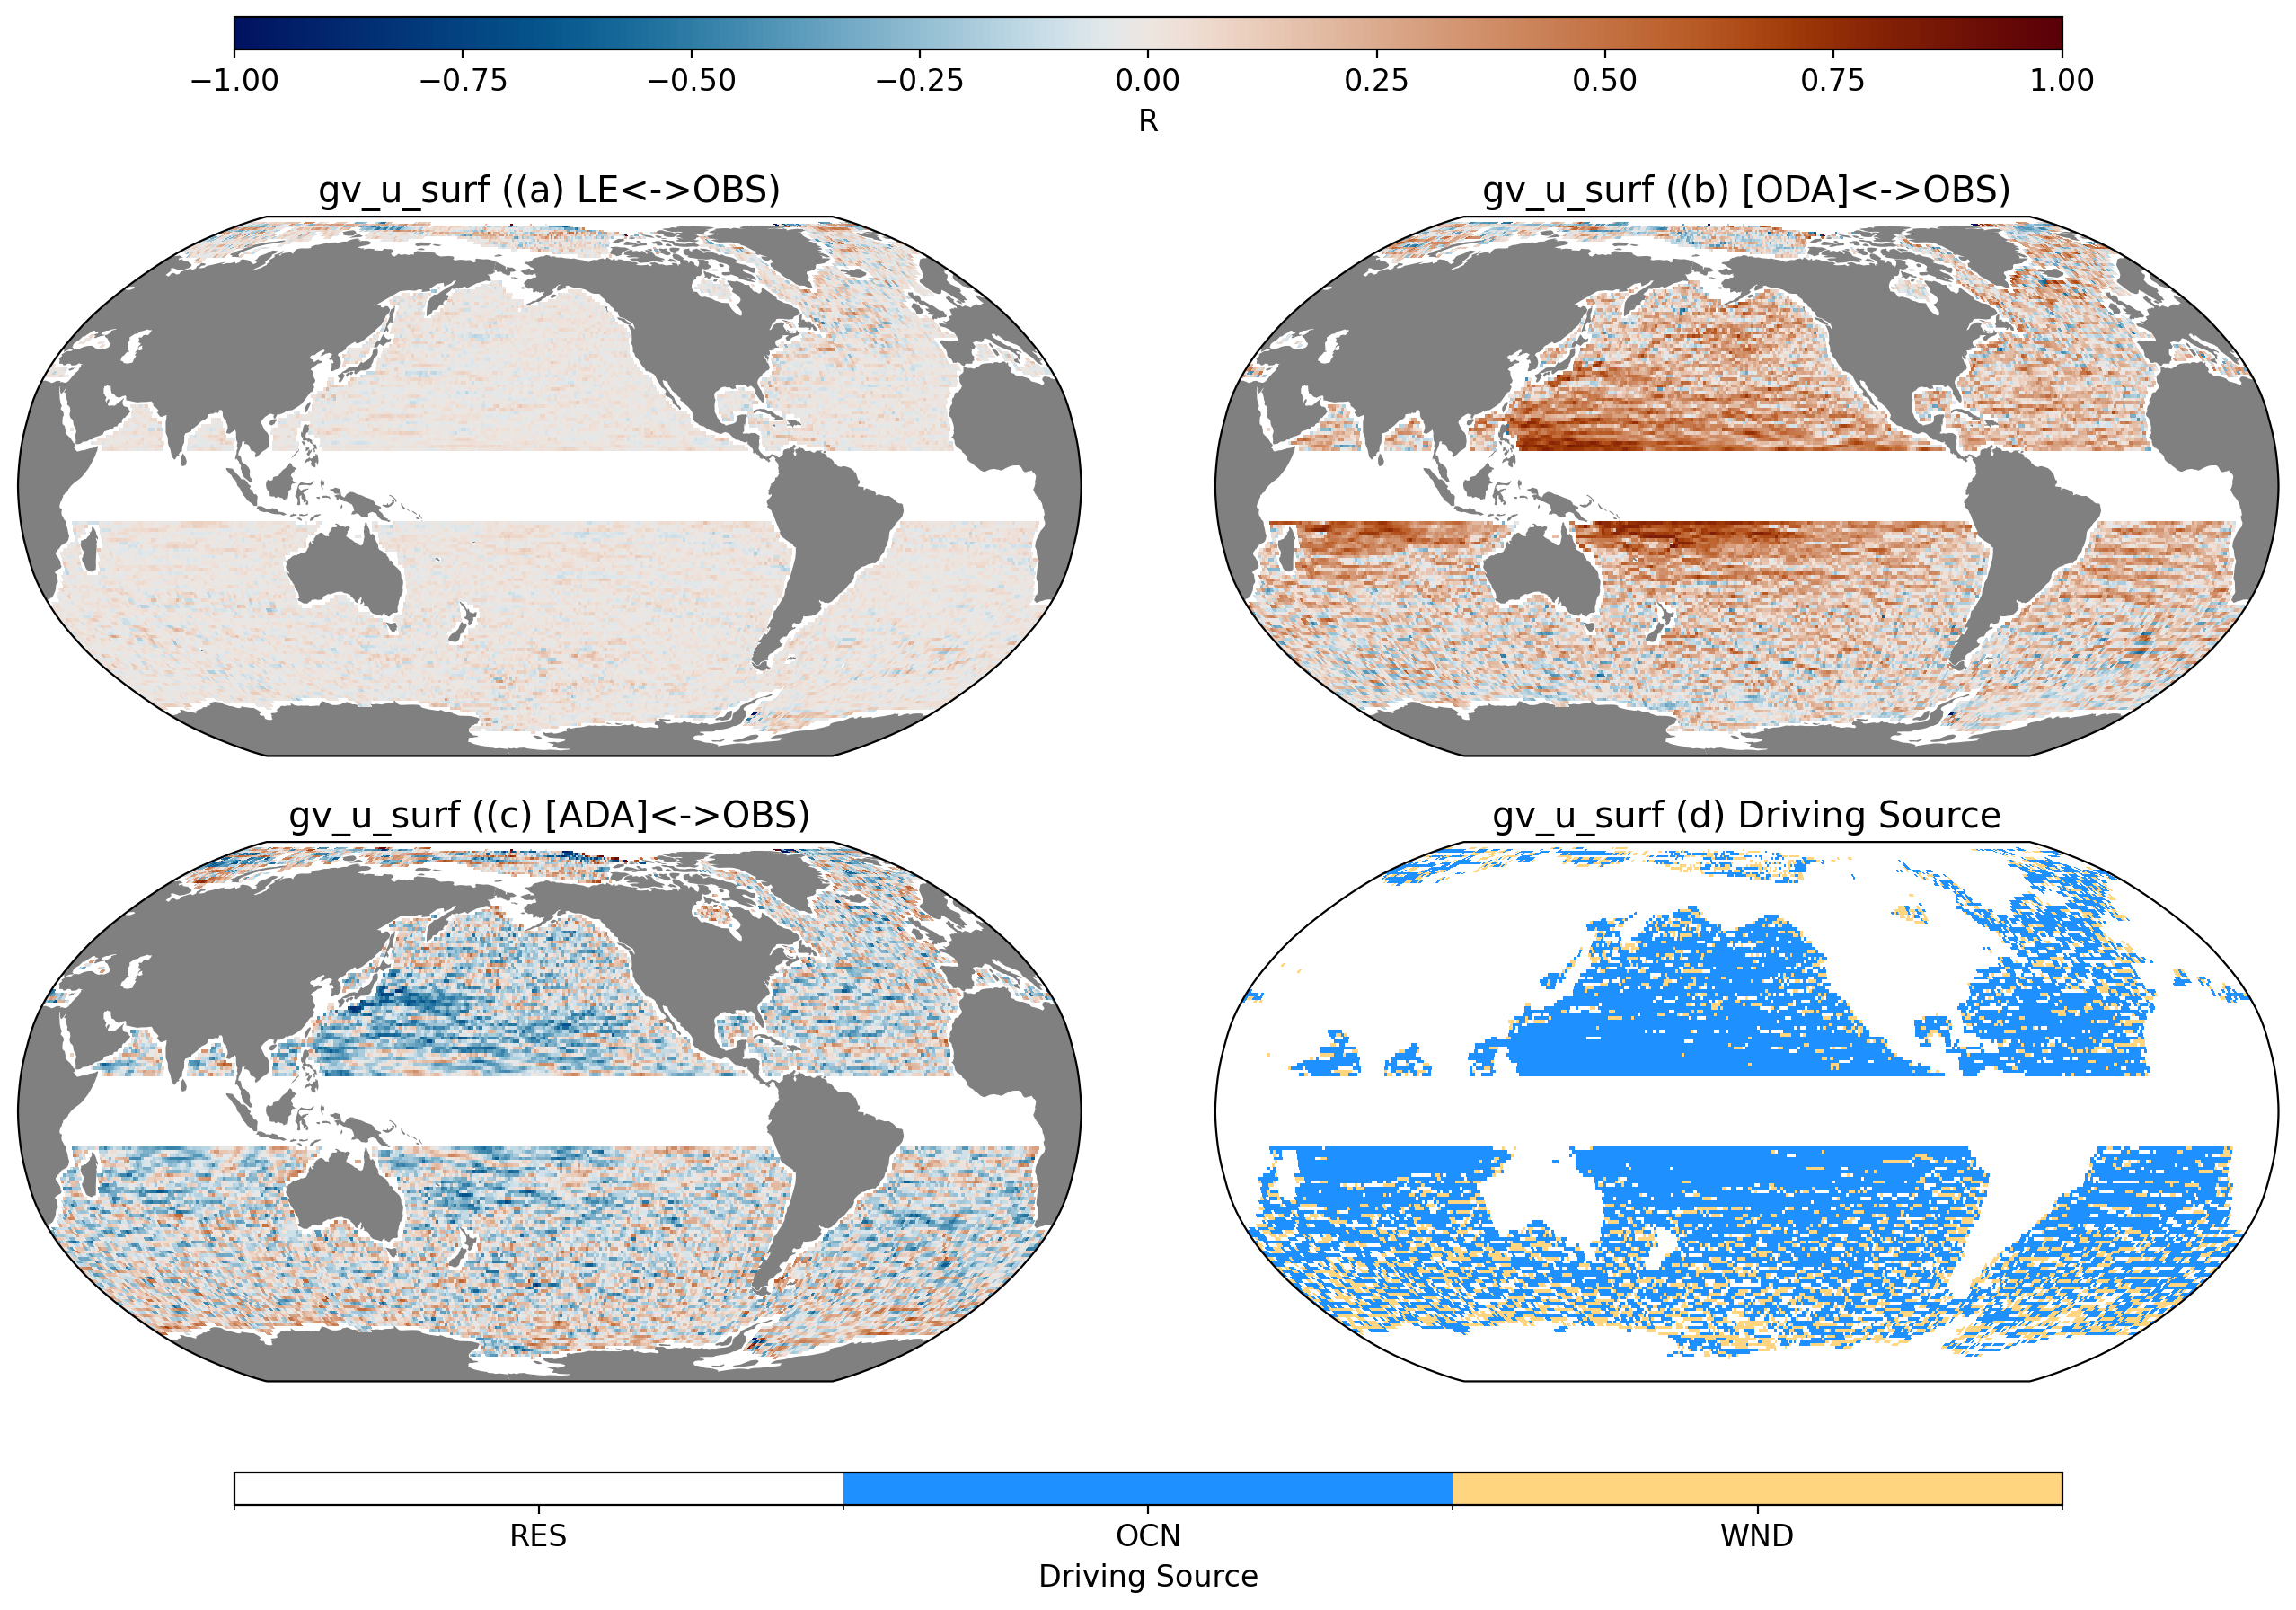

In [147]:
# gv fig (u)
from scipy.stats import ttest_1samp

land_feature = cfeature.LAND.with_scale('110m')

cfg_var_gv_u_surf.var = 'gv_u_surf'
varn=cfg_var_gv_u_surf.var
# plot for LE

projection = ccrs.Robinson(central_longitude=205)
cbar_kwargs={'orientation':'horizontal','pad':0.05,'shrink':0.7, 'label':' R ', 'aspect':33, 'extend': 'both'}

# 서브플롯 생성
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(18.5, 9), 
             dpi=200, facecolor='w', edgecolor='k', subplot_kw={'projection': projection})

data_array = corr_gv_u_surf_OBS_LE.median(dim='ens_LE')
plt1=data_array.plot.pcolormesh(ax=axes[0, 0], transform=ccrs.PlateCarree(), vmax=1, vmin=-1,cmap=cm.vik, add_colorbar=False)
axes[0, 0].set_title(f'{varn} ((a) LE<->OBS)')
axes[0, 0].add_feature(land_feature, facecolor='gray', edgecolor='none')
    
# plot for (ODA)
data_array = corr_gv_u_surf_OBS_ODA_diff.median(dim='ens_ODA')
plt1=data_array.plot.pcolormesh(ax=axes[0, 1], transform=ccrs.PlateCarree(), vmax=1, vmin=-1,cmap=cm.vik, add_colorbar=False)
axes[0, 1].set_title(f'{varn} ((b) [ODA]<->OBS)')
axes[0, 1].add_feature(land_feature, facecolor='gray', edgecolor='none')

# plot for (ADA)
data_array = corr_gv_u_surf_OBS_ADA_diff.median(dim='ens_ADA')
plt1=data_array.plot.pcolormesh(ax=axes[1, 0], transform=ccrs.PlateCarree(), vmax=1, vmin=-1,cmap=cm.vik, add_colorbar=False)
axes[1, 0].set_title(f'{varn} ((c) [ADA]<->OBS)')
axes[1, 0].add_feature(land_feature, facecolor='gray', edgecolor='none')


# plot for (WND ODA mask)
alpha = 0.10

t_stat_LE, p_values_LE = ttest_1samp(corr_gv_u_surf_OBS_LE, 0, axis=2)
ds_LE = corr_gv_u_surf_OBS_LE.median(dim='ens_LE').where(p_values_LE < alpha)

t_stat_ODA, p_values_ODA = ttest_1samp(corr_gv_u_surf_OBS_ODA_diff, 0, axis=2)
ds_ODA = corr_gv_u_surf_OBS_ODA_diff.median(dim='ens_ODA').where(p_values_ODA < alpha)

t_stat_ADA, p_values_ADA = ttest_1samp(corr_gv_u_surf_OBS_ADA_diff, 0, axis=2)
ds_ADA = corr_gv_u_surf_OBS_ADA_diff.median(dim='ens_ADA').where(p_values_ADA < alpha)

threshold = 0
mask_LE = ds_LE > threshold
mask_ODA = ds_ODA > threshold
mask_ADA = ds_ADA > threshold

ds_all = xr.Dataset(
    data_vars=dict(
        colors=(('lat', 'lon'), np.full(ds_LE.shape, 0.33))  # 'colors'라는 변수 추가
    ),
    coords=dict(
        lat=(('lat'), mask_LE.lat.data),  # DataArray의 .data 사용
        lon=(('lon'), mask_LE.lon.data)     # DataArray의 .data 사용
    )
)

# ds_all['colors'] = xr.where(ds_grid.REGION_MASK == 0, 0.0, ds_all['colors']) # 흰색
ds_all['colors'] = xr.where(mask_LE.isnull(), 0.0, ds_all['colors']) # 흰색
ds_all['colors'] = xr.where(mask_ODA & ~mask_ADA, 0.5, ds_all['colors'])  # 파란색
ds_all['colors'] = xr.where(mask_ODA & mask_ADA, 0.5, ds_all['colors'])  # 파란색
ds_all['colors'] = xr.where(~mask_ODA & mask_ADA, 1.0, ds_all['colors'])  # 주황색
ds_all['colors'] = xr.where(mask_LE & ~mask_ODA, 0, ds_all['colors'])  # 주황색

colors_custom = ['#FFFFFF',  # 흰색 (White)
          '#1E90FF',  # Dodger blue (ODA)
          '#FFD580']  # 파스텔 오렌지 (WND) 

# Define boundaries so each color covers exactly one bin:
bounds = [0, 0.5, 1, 1.5]  # or [0, 0.33, 0.66, 1] if your data is in [0..1]
cmap = mcolors.ListedColormap(colors_custom)
norm = mcolors.BoundaryNorm(bounds, cmap.N)

plt4=ds_all['colors'].plot.pcolormesh(ax=axes[1, 1], transform=ccrs.PlateCarree(), cmap=mcolors.ListedColormap(colors_custom), add_colorbar=False, norm=norm)
axes[1, 1].set_title(f'{varn} (d) Driving Source')
axes[1, 1].add_feature(land_feature, facecolor='gray', edgecolor='none')


# (a), (b), (c) 서브플롯에 대해 위쪽에 큰 컬러바 추가
cbar_a_c = fig.add_axes([0.1, 0.95, 0.55, 0.02])  # [left, bottom, width, height] 비율로 컬러바 위치와 크기 설정
cbar1 = plt.colorbar(plt1, cax=cbar_a_c, orientation='horizontal')
cbar1.set_label('R')

# (d) 서브플롯에 대해 아래쪽에 큰 컬러바 추가
cbar_d = fig.add_axes([0.1, 0.05, 0.55, 0.02])  # [left, bottom, width, height] 비율로 컬러바 위치와 크기 설정
# cbar2= plt.colorbar(plt4, cax=cbar_d, orientation='horizontal')
cbar2 = plt.colorbar(plt4, cax=cbar_d, orientation='horizontal',
                     boundaries=bounds, ticks=[0.25, 0.75, 1.25])
cbar2.set_label('Driving Source')
# num_colors = len(colors_custom)
# tick_locs = np.linspace(0.5 / num_colors, 1 - 0.5 / num_colors, num_colors)
# tick_locs = np.linspace(0.25, 0.75, 3)
# cbar2.set_ticks(tick_locs)  # 눈금 설정
cbar2.set_ticklabels(['RES', 'OCN', 'WND'])  # 눈금 레이블 설정

plt.rcParams.update({'font.size': 16})

# 전체 레이아웃 조정
plt.tight_layout(rect=[0, 0.1, 0.75, 0.9])  # 상단과 하단의 레이아웃 여백을 맞추기 위해 rect 설정
# plt.tight_layout()
plt.savefig(savefilepath +"/BGC_Pred_SFig3_gvu.tif", format='tiff', dpi=150, bbox_inches='tight')
plt.show()



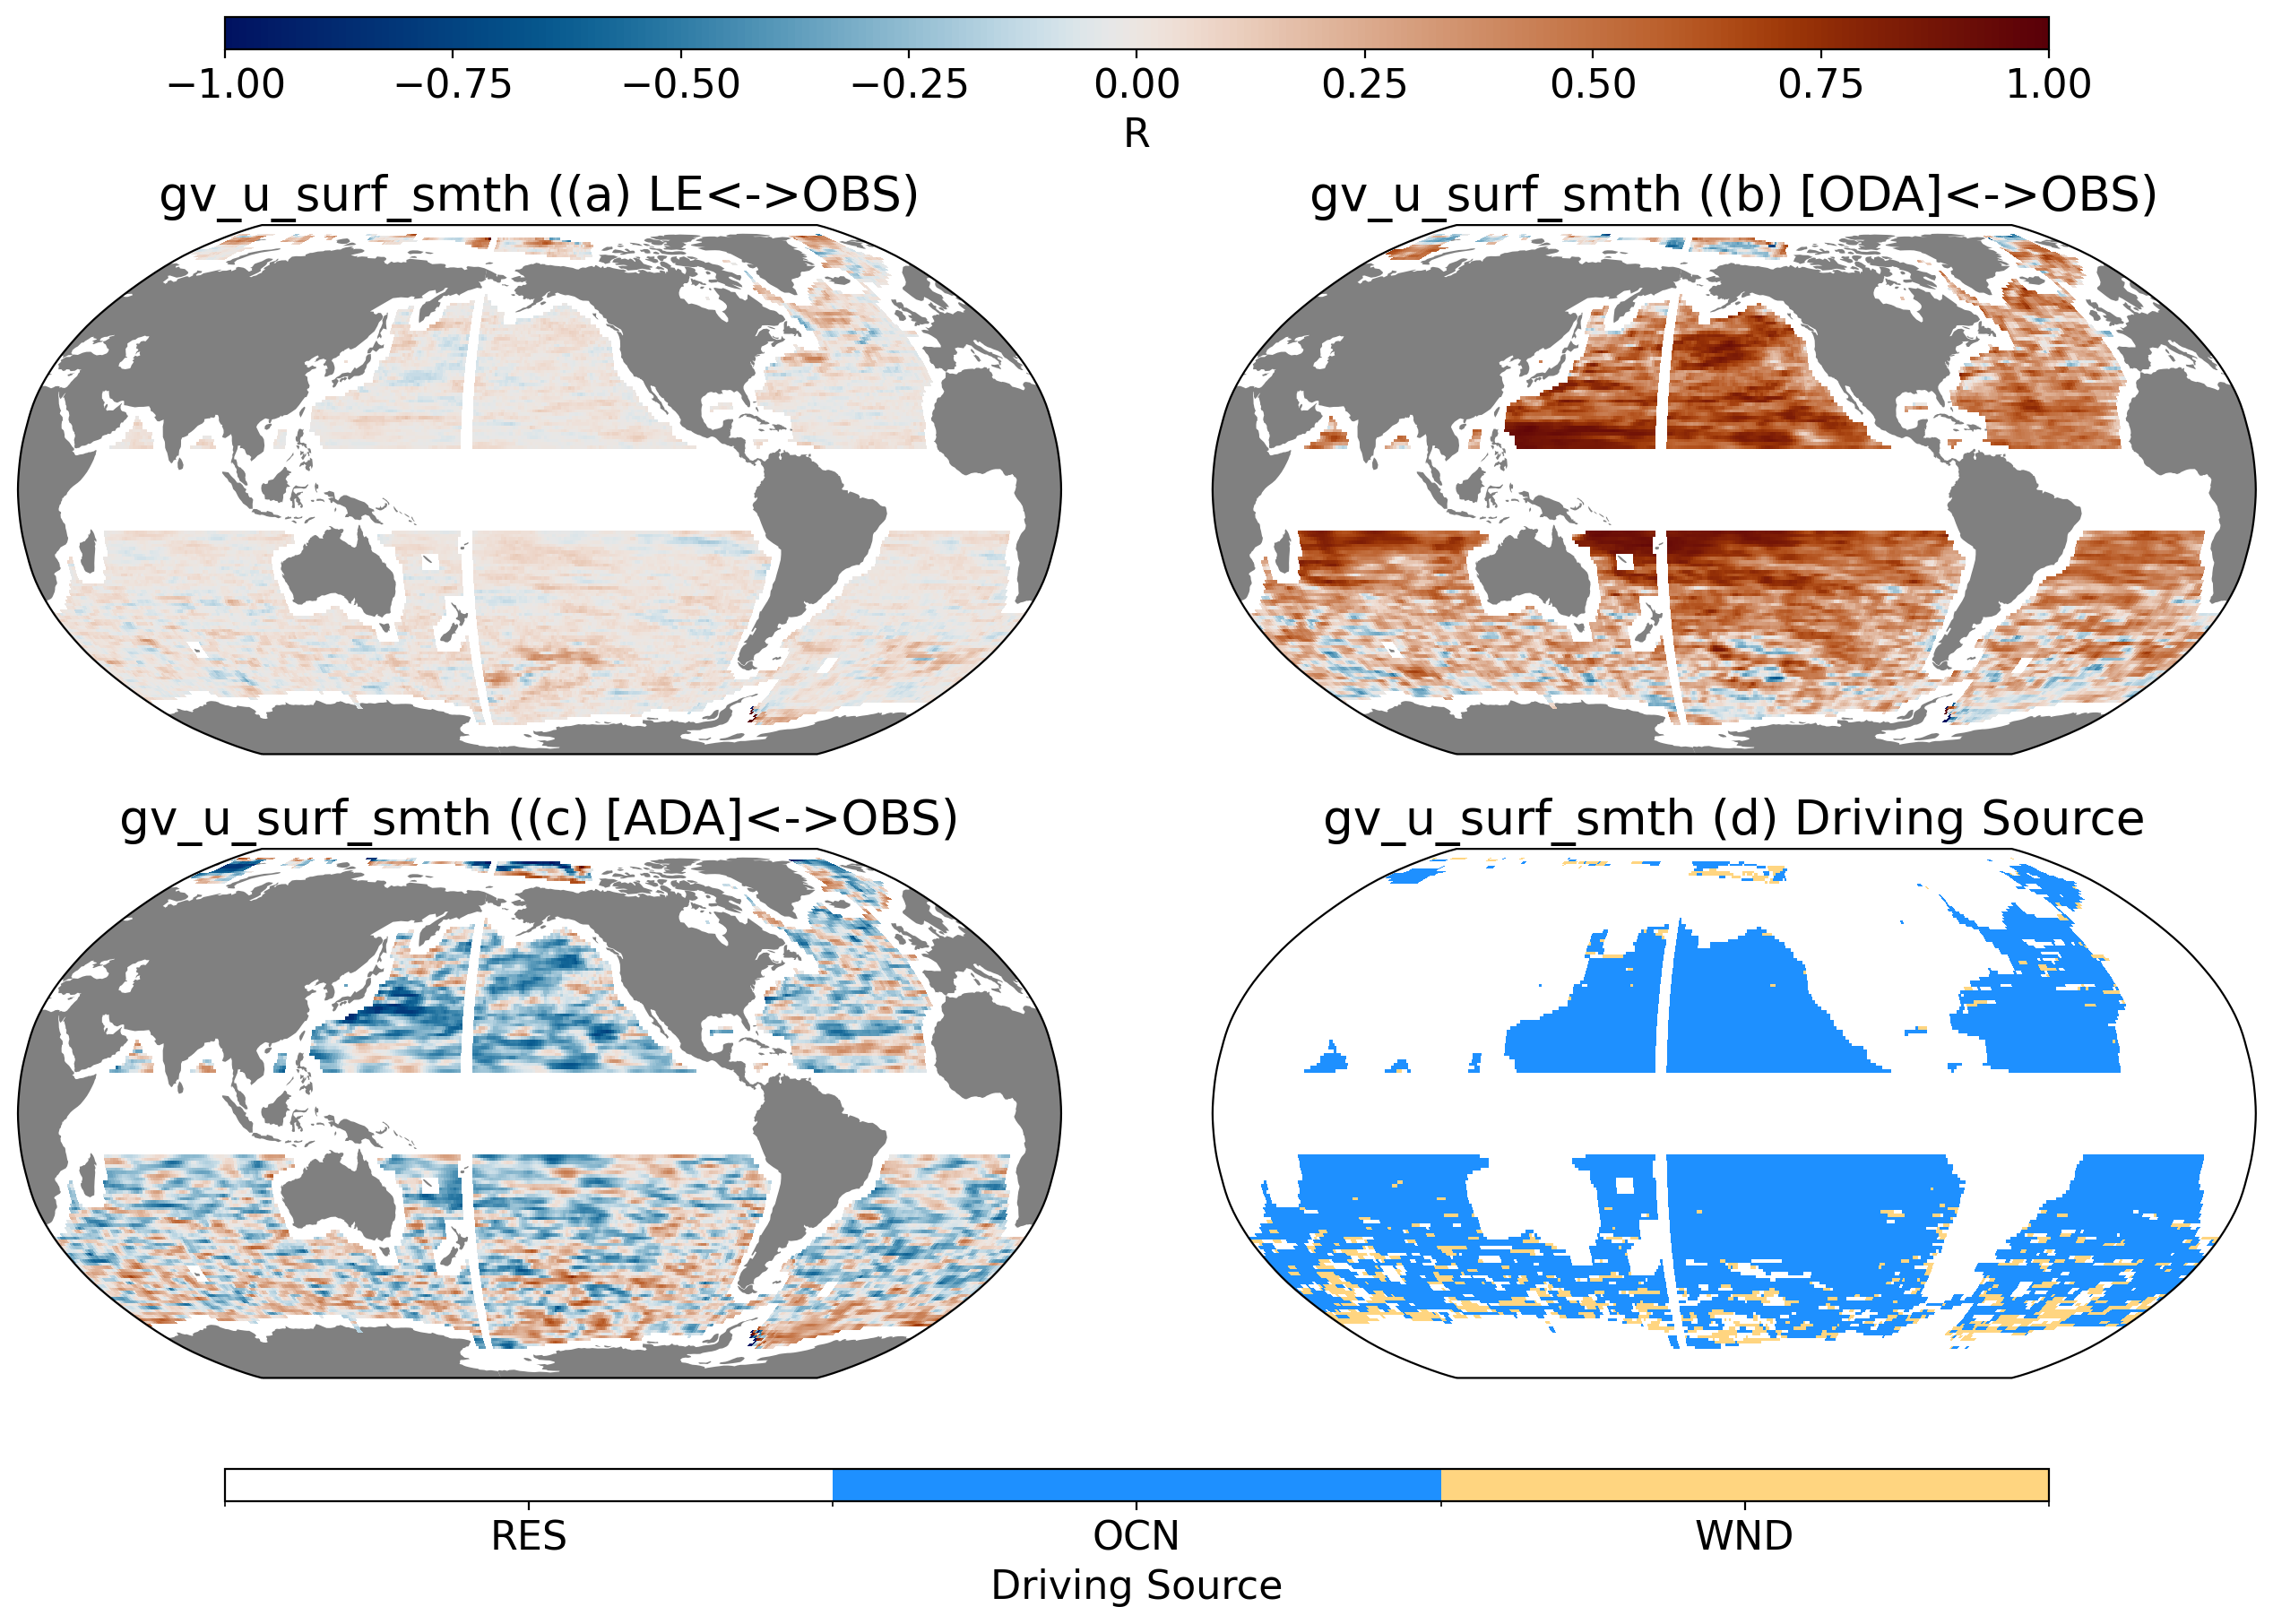

In [215]:
# gv fig (u_smth)
from scipy.stats import ttest_1samp

land_feature = cfeature.LAND.with_scale('110m')

varn='gv_u_surf_smth'
# plot for LE

projection = ccrs.Robinson(central_longitude=205)
cbar_kwargs={'orientation':'horizontal','pad':0.05,'shrink':0.7, 'label':' R ', 'aspect':33, 'extend': 'both'}

# 서브플롯 생성
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(18.5, 9), 
             dpi=200, facecolor='w', edgecolor='k', subplot_kw={'projection': projection})

data_array = corr_gv_u_surf_OBS_LE_smth.median(dim='ens_LE')
plt1=data_array.plot.pcolormesh(ax=axes[0, 0], transform=ccrs.PlateCarree(), vmax=1, vmin=-1,cmap=cm.vik, add_colorbar=False)
axes[0, 0].set_title(f'{varn} ((a) LE<->OBS)')
axes[0, 0].add_feature(land_feature, facecolor='gray', edgecolor='none')
    
# plot for (ODA)
data_array = corr_gv_u_surf_OBS_ODA_diff_smth.median(dim='ens_ODA')
plt1=data_array.plot.pcolormesh(ax=axes[0, 1], transform=ccrs.PlateCarree(), vmax=1, vmin=-1,cmap=cm.vik, add_colorbar=False)
axes[0, 1].set_title(f'{varn} ((b) [ODA]<->OBS)')
axes[0, 1].add_feature(land_feature, facecolor='gray', edgecolor='none')

# plot for (ADA)
data_array = corr_gv_u_surf_OBS_ADA_diff_smth.median(dim='ens_ADA')
plt1=data_array.plot.pcolormesh(ax=axes[1, 0], transform=ccrs.PlateCarree(), vmax=1, vmin=-1,cmap=cm.vik, add_colorbar=False)
axes[1, 0].set_title(f'{varn} ((c) [ADA]<->OBS)')
axes[1, 0].add_feature(land_feature, facecolor='gray', edgecolor='none')


# plot for (WND ODA mask)
alpha = 0.10

t_stat_LE, p_values_LE = ttest_1samp(corr_gv_u_surf_OBS_LE_smth, 0, axis=2)
ds_LE = corr_gv_u_surf_OBS_LE_smth.median(dim='ens_LE').where(p_values_LE < alpha)

t_stat_ODA, p_values_ODA = ttest_1samp(corr_gv_u_surf_OBS_ODA_diff_smth, 0, axis=2)
ds_ODA = corr_gv_u_surf_OBS_ODA_diff_smth.median(dim='ens_ODA').where(p_values_ODA < alpha)

t_stat_ADA, p_values_ADA = ttest_1samp(corr_gv_u_surf_OBS_ADA_diff_smth, 0, axis=2)
ds_ADA = corr_gv_u_surf_OBS_ADA_diff_smth.median(dim='ens_ADA').where(p_values_ADA < alpha)

threshold = 0
mask_LE = ds_LE > threshold
mask_ODA = ds_ODA > threshold
mask_ADA = ds_ADA > threshold

ds_all = xr.Dataset(
    data_vars=dict(
        colors=(('lat', 'lon'), np.full(ds_LE.shape, 0.33))  # 'colors'라는 변수 추가
    ),
    coords=dict(
        lat=(('lat'), mask_LE.lat.data),  # DataArray의 .data 사용
        lon=(('lon'), mask_LE.lon.data)     # DataArray의 .data 사용
    )
)

# ds_all['colors'] = xr.where(ds_grid.REGION_MASK == 0, 0.0, ds_all['colors']) # 흰색
ds_all['colors'] = xr.where(mask_LE.isnull(), 0.0, ds_all['colors']) # 흰색
ds_all['colors'] = xr.where(mask_ODA & ~mask_ADA, 0.5, ds_all['colors'])  # 파란색
ds_all['colors'] = xr.where(mask_ODA & mask_ADA, 0.5, ds_all['colors'])  # 파란색
ds_all['colors'] = xr.where(~mask_ODA & mask_ADA, 1.0, ds_all['colors'])  # 주황색
ds_all['colors'] = xr.where(mask_LE & ~mask_ODA, 0, ds_all['colors'])  # 주황색

colors_custom = ['#FFFFFF',  # 흰색 (White)
          '#1E90FF',  # Dodger blue (ODA)
          '#FFD580']  # 파스텔 오렌지 (WND) 

# Define boundaries so each color covers exactly one bin:
bounds = [0, 0.5, 1, 1.5]  # or [0, 0.33, 0.66, 1] if your data is in [0..1]
cmap = mcolors.ListedColormap(colors_custom)
norm = mcolors.BoundaryNorm(bounds, cmap.N)

plt4=ds_all['colors'].plot.pcolormesh(ax=axes[1, 1], transform=ccrs.PlateCarree(), cmap=mcolors.ListedColormap(colors_custom), add_colorbar=False, norm=norm)
axes[1, 1].set_title(f'{varn} (d) Driving Source')
axes[1, 1].add_feature(land_feature, facecolor='gray', edgecolor='none')


# (a), (b), (c) 서브플롯에 대해 위쪽에 큰 컬러바 추가
cbar_a_c = fig.add_axes([0.1, 0.95, 0.55, 0.02])  # [left, bottom, width, height] 비율로 컬러바 위치와 크기 설정
cbar1 = plt.colorbar(plt1, cax=cbar_a_c, orientation='horizontal')
cbar1.set_label('R')

# (d) 서브플롯에 대해 아래쪽에 큰 컬러바 추가
cbar_d = fig.add_axes([0.1, 0.05, 0.55, 0.02])  # [left, bottom, width, height] 비율로 컬러바 위치와 크기 설정
# cbar2= plt.colorbar(plt4, cax=cbar_d, orientation='horizontal')
cbar2 = plt.colorbar(plt4, cax=cbar_d, orientation='horizontal',
                     boundaries=bounds, ticks=[0.25, 0.75, 1.25])
cbar2.set_label('Driving Source')
# num_colors = len(colors_custom)
# tick_locs = np.linspace(0.5 / num_colors, 1 - 0.5 / num_colors, num_colors)
# tick_locs = np.linspace(0.25, 0.75, 3)
# cbar2.set_ticks(tick_locs)  # 눈금 설정
cbar2.set_ticklabels(['RES', 'OCN', 'WND'])  # 눈금 레이블 설정

plt.rcParams.update({'font.size': 16})

# 전체 레이아웃 조정
plt.tight_layout(rect=[0, 0.1, 0.75, 0.9])  # 상단과 하단의 레이아웃 여백을 맞추기 위해 rect 설정
# plt.tight_layout()
plt.savefig(savefilepath +"/BGC_Pred_SFig3_gvu.tif", format='tiff', dpi=150, bbox_inches='tight')
plt.show()



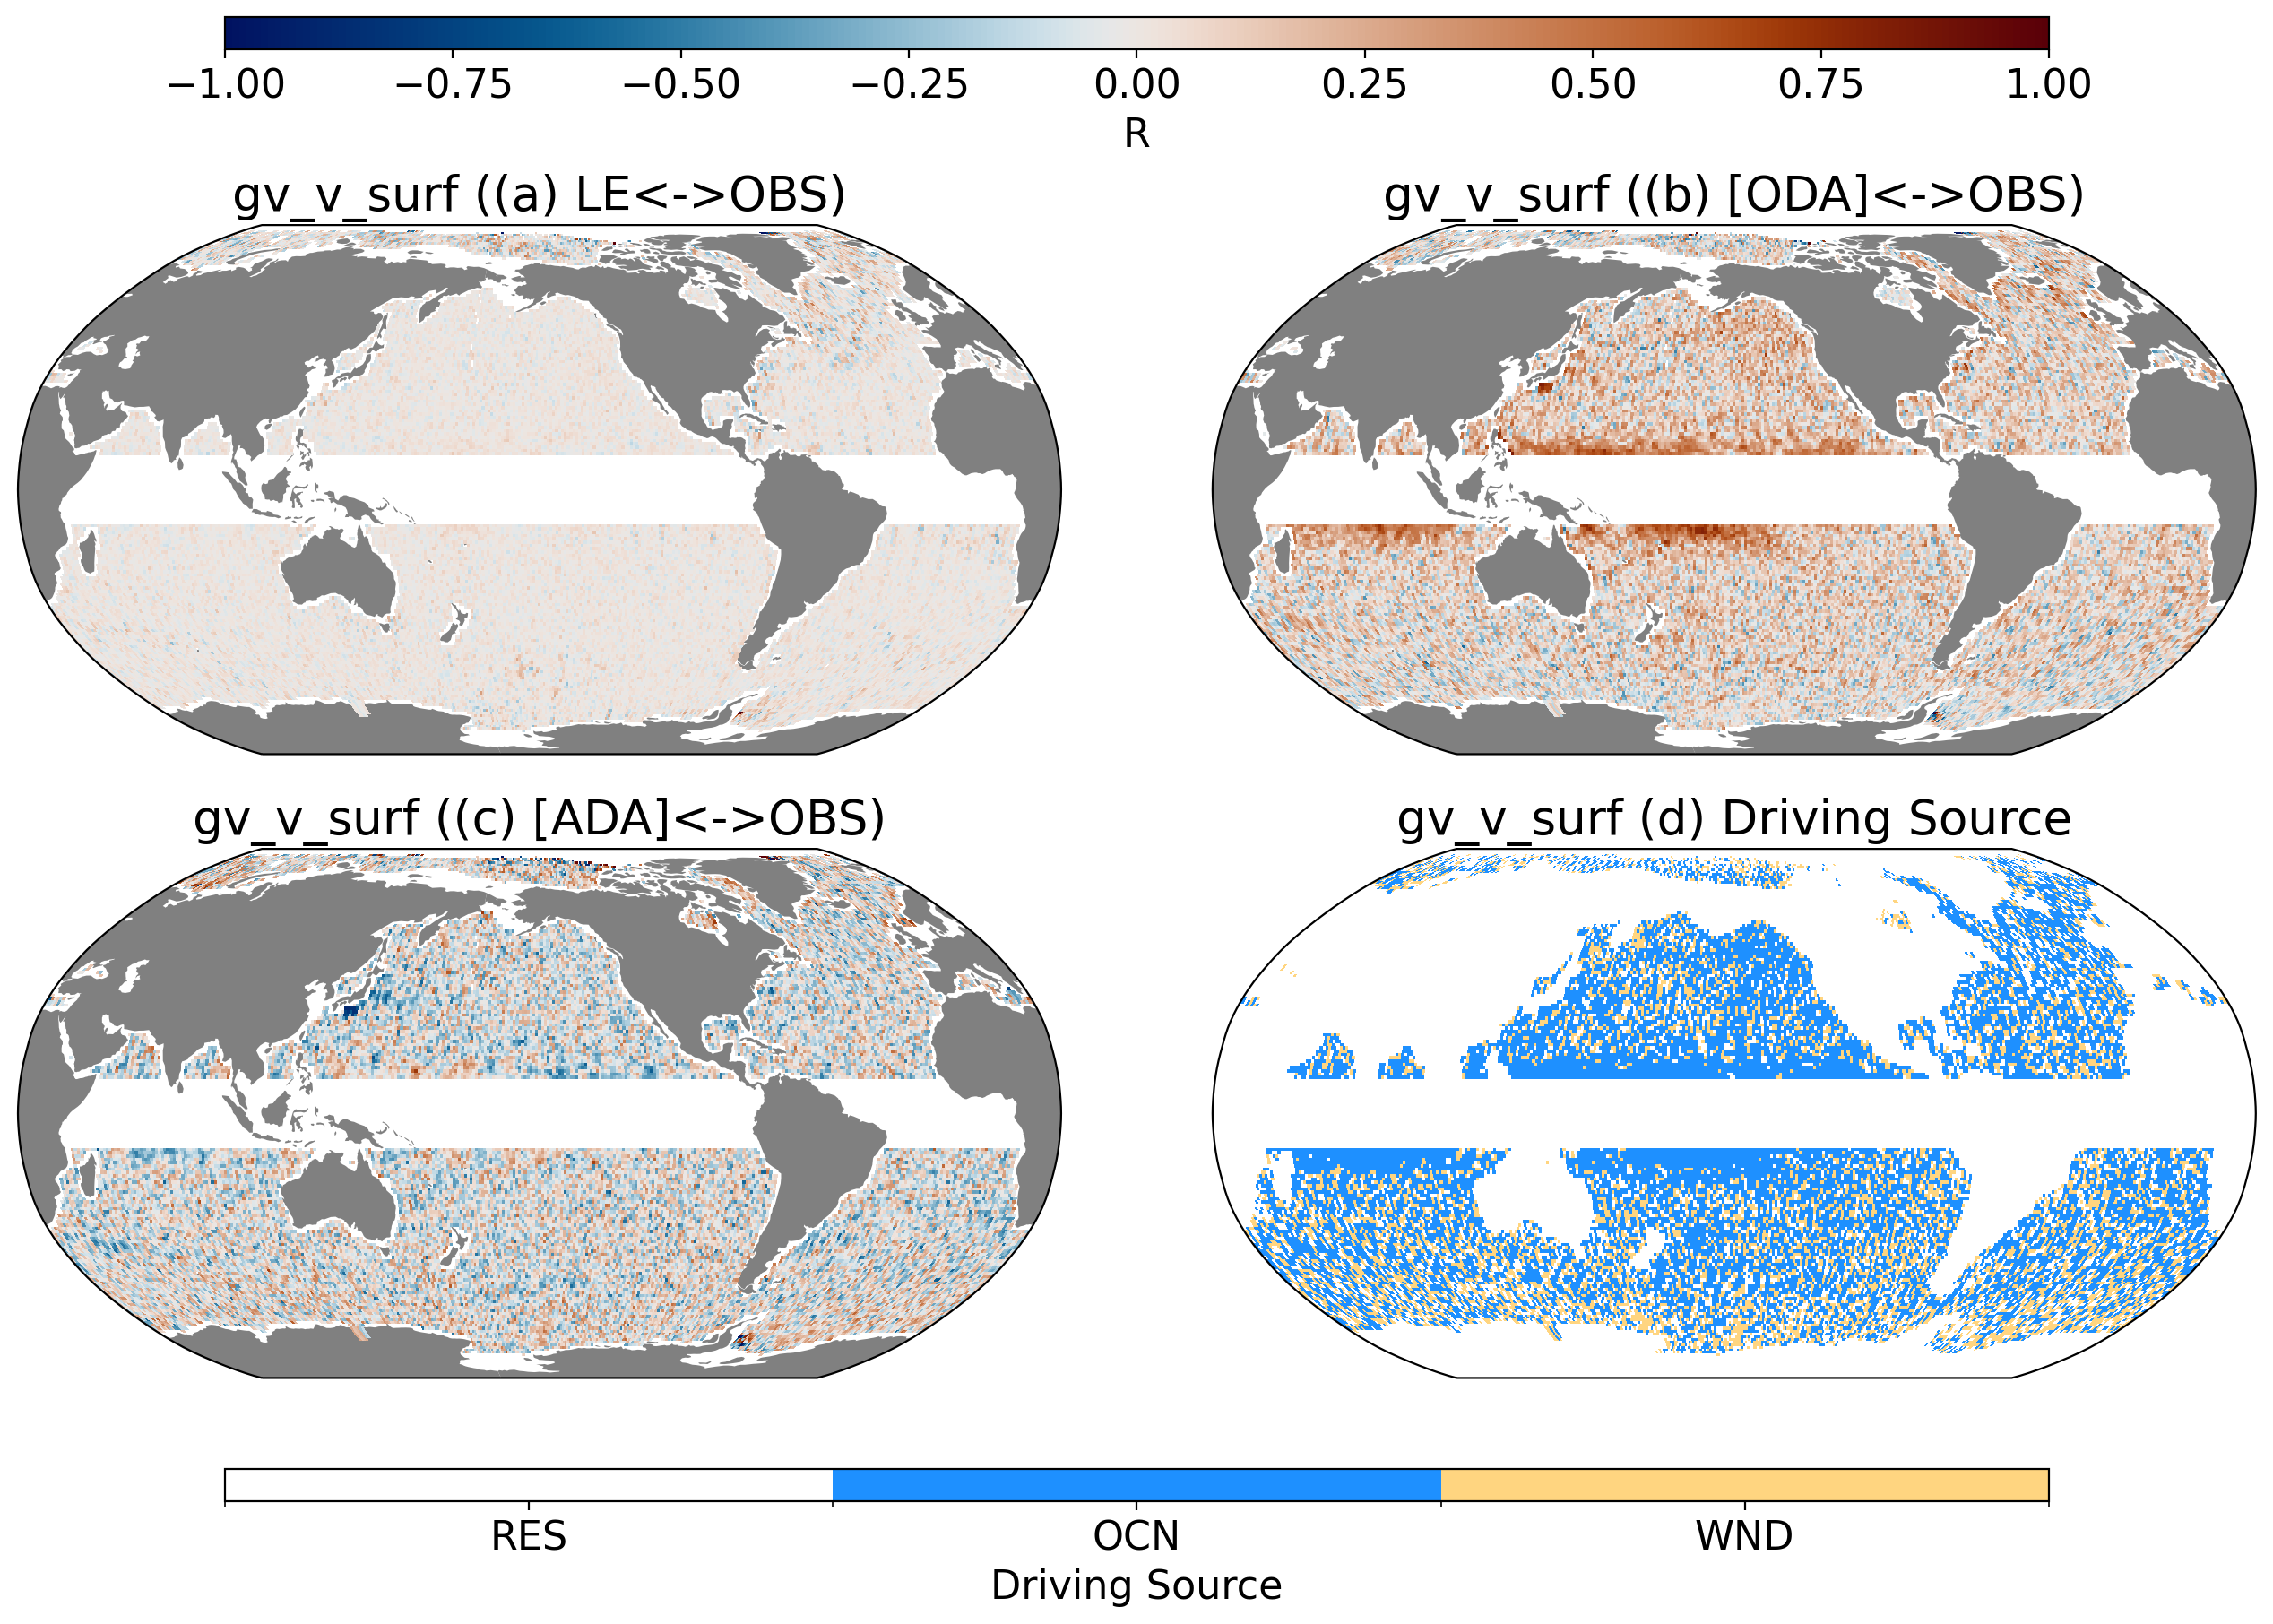

In [148]:
# gv fig (v)
from scipy.stats import ttest_1samp

land_feature = cfeature.LAND.with_scale('110m')

cfg_var_gv_v_surf.var = 'gv_v_surf'
varn=cfg_var_gv_v_surf.var
# plot for LE

projection = ccrs.Robinson(central_longitude=205)
cbar_kwargs={'orientation':'horizontal','pad':0.05,'shrink':0.7, 'label':' R ', 'aspect':33, 'extend': 'both'}

# 서브플롯 생성
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(18.5, 9), 
             dpi=200, facecolor='w', edgecolor='k', subplot_kw={'projection': projection})

data_array = corr_gv_v_surf_OBS_LE.median(dim='ens_LE')
plt1=data_array.plot.pcolormesh(ax=axes[0, 0], transform=ccrs.PlateCarree(), vmax=1, vmin=-1,cmap=cm.vik, add_colorbar=False)
axes[0, 0].set_title(f'{varn} ((a) LE<->OBS)')
axes[0, 0].add_feature(land_feature, facecolor='gray', edgecolor='none')
    
# plot for (ODA)
data_array = corr_gv_v_surf_OBS_ODA_diff.median(dim='ens_ODA')
plt1=data_array.plot.pcolormesh(ax=axes[0, 1], transform=ccrs.PlateCarree(), vmax=1, vmin=-1,cmap=cm.vik, add_colorbar=False)
axes[0, 1].set_title(f'{varn} ((b) [ODA]<->OBS)')
axes[0, 1].add_feature(land_feature, facecolor='gray', edgecolor='none')

# plot for (ADA)
data_array = corr_gv_v_surf_OBS_ADA_diff.median(dim='ens_ADA')
plt1=data_array.plot.pcolormesh(ax=axes[1, 0], transform=ccrs.PlateCarree(), vmax=1, vmin=-1,cmap=cm.vik, add_colorbar=False)
axes[1, 0].set_title(f'{varn} ((c) [ADA]<->OBS)')
axes[1, 0].add_feature(land_feature, facecolor='gray', edgecolor='none')


# plot for (WND ODA mask)
alpha = 0.10

t_stat_LE, p_values_LE = ttest_1samp(corr_gv_v_surf_OBS_LE, 0, axis=2)
ds_LE = corr_gv_v_surf_OBS_LE.median(dim='ens_LE').where(p_values_LE < alpha)

t_stat_ODA, p_values_ODA = ttest_1samp(corr_gv_v_surf_OBS_ODA_diff, 0, axis=2)
ds_ODA = corr_gv_v_surf_OBS_ODA_diff.median(dim='ens_ODA').where(p_values_ODA < alpha)

t_stat_ADA, p_values_ADA = ttest_1samp(corr_gv_v_surf_OBS_ADA_diff, 0, axis=2)
ds_ADA = corr_gv_v_surf_OBS_ADA_diff.median(dim='ens_ADA').where(p_values_ADA < alpha)

threshold = 0
mask_LE = ds_LE > threshold
mask_ODA = ds_ODA > threshold
mask_ADA = ds_ADA > threshold

ds_all = xr.Dataset(
    data_vars=dict(
        colors=(('lat', 'lon'), np.full(ds_LE.shape, 0.33))  # 'colors'라는 변수 추가
    ),
    coords=dict(
        lat=(('lat'), mask_LE.lat.data),  # DataArray의 .data 사용
        lon=(('lon'), mask_LE.lon.data)     # DataArray의 .data 사용
    )
)

# ds_all['colors'] = xr.where(ds_grid.REGION_MASK == 0, 0.0, ds_all['colors']) # 흰색
ds_all['colors'] = xr.where(mask_LE.isnull(), 0.0, ds_all['colors']) # 흰색
ds_all['colors'] = xr.where(mask_ODA & ~mask_ADA, 0.5, ds_all['colors'])  # 파란색
ds_all['colors'] = xr.where(mask_ODA & mask_ADA, 0.5, ds_all['colors'])  # 파란색
ds_all['colors'] = xr.where(~mask_ODA & mask_ADA, 1.0, ds_all['colors'])  # 주황색
ds_all['colors'] = xr.where(mask_LE & ~mask_ODA, 0, ds_all['colors'])  # 주황색

colors_custom = ['#FFFFFF',  # 흰색 (White)
          '#1E90FF',  # Dodger blue (ODA)
          '#FFD580']  # 파스텔 오렌지 (WND) 

# Define boundaries so each color covers exactly one bin:
bounds = [0, 0.5, 1, 1.5]  # or [0, 0.33, 0.66, 1] if your data is in [0..1]
cmap = mcolors.ListedColormap(colors_custom)
norm = mcolors.BoundaryNorm(bounds, cmap.N)

plt4=ds_all['colors'].plot.pcolormesh(ax=axes[1, 1], transform=ccrs.PlateCarree(), cmap=mcolors.ListedColormap(colors_custom), add_colorbar=False, norm=norm)
axes[1, 1].set_title(f'{varn} (d) Driving Source')
axes[1, 1].add_feature(land_feature, facecolor='gray', edgecolor='none')


# (a), (b), (c) 서브플롯에 대해 위쪽에 큰 컬러바 추가
cbar_a_c = fig.add_axes([0.1, 0.95, 0.55, 0.02])  # [left, bottom, width, height] 비율로 컬러바 위치와 크기 설정
cbar1 = plt.colorbar(plt1, cax=cbar_a_c, orientation='horizontal')
cbar1.set_label('R')

# (d) 서브플롯에 대해 아래쪽에 큰 컬러바 추가
cbar_d = fig.add_axes([0.1, 0.05, 0.55, 0.02])  # [left, bottom, width, height] 비율로 컬러바 위치와 크기 설정
# cbar2= plt.colorbar(plt4, cax=cbar_d, orientation='horizontal')
cbar2 = plt.colorbar(plt4, cax=cbar_d, orientation='horizontal',
                     boundaries=bounds, ticks=[0.25, 0.75, 1.25])
cbar2.set_label('Driving Source')
# num_colors = len(colors_custom)
# tick_locs = np.linspace(0.5 / num_colors, 1 - 0.5 / num_colors, num_colors)
# tick_locs = np.linspace(0.25, 0.75, 3)
# cbar2.set_ticks(tick_locs)  # 눈금 설정
cbar2.set_ticklabels(['RES', 'OCN', 'WND'])  # 눈금 레이블 설정

plt.rcParams.update({'font.size': 16})

# 전체 레이아웃 조정
plt.tight_layout(rect=[0, 0.1, 0.75, 0.9])  # 상단과 하단의 레이아웃 여백을 맞추기 위해 rect 설정
# plt.tight_layout()
plt.savefig(savefilepath +"/BGC_Pred_SFig3_gvu.tif", format='tiff', dpi=150, bbox_inches='tight')
plt.show()



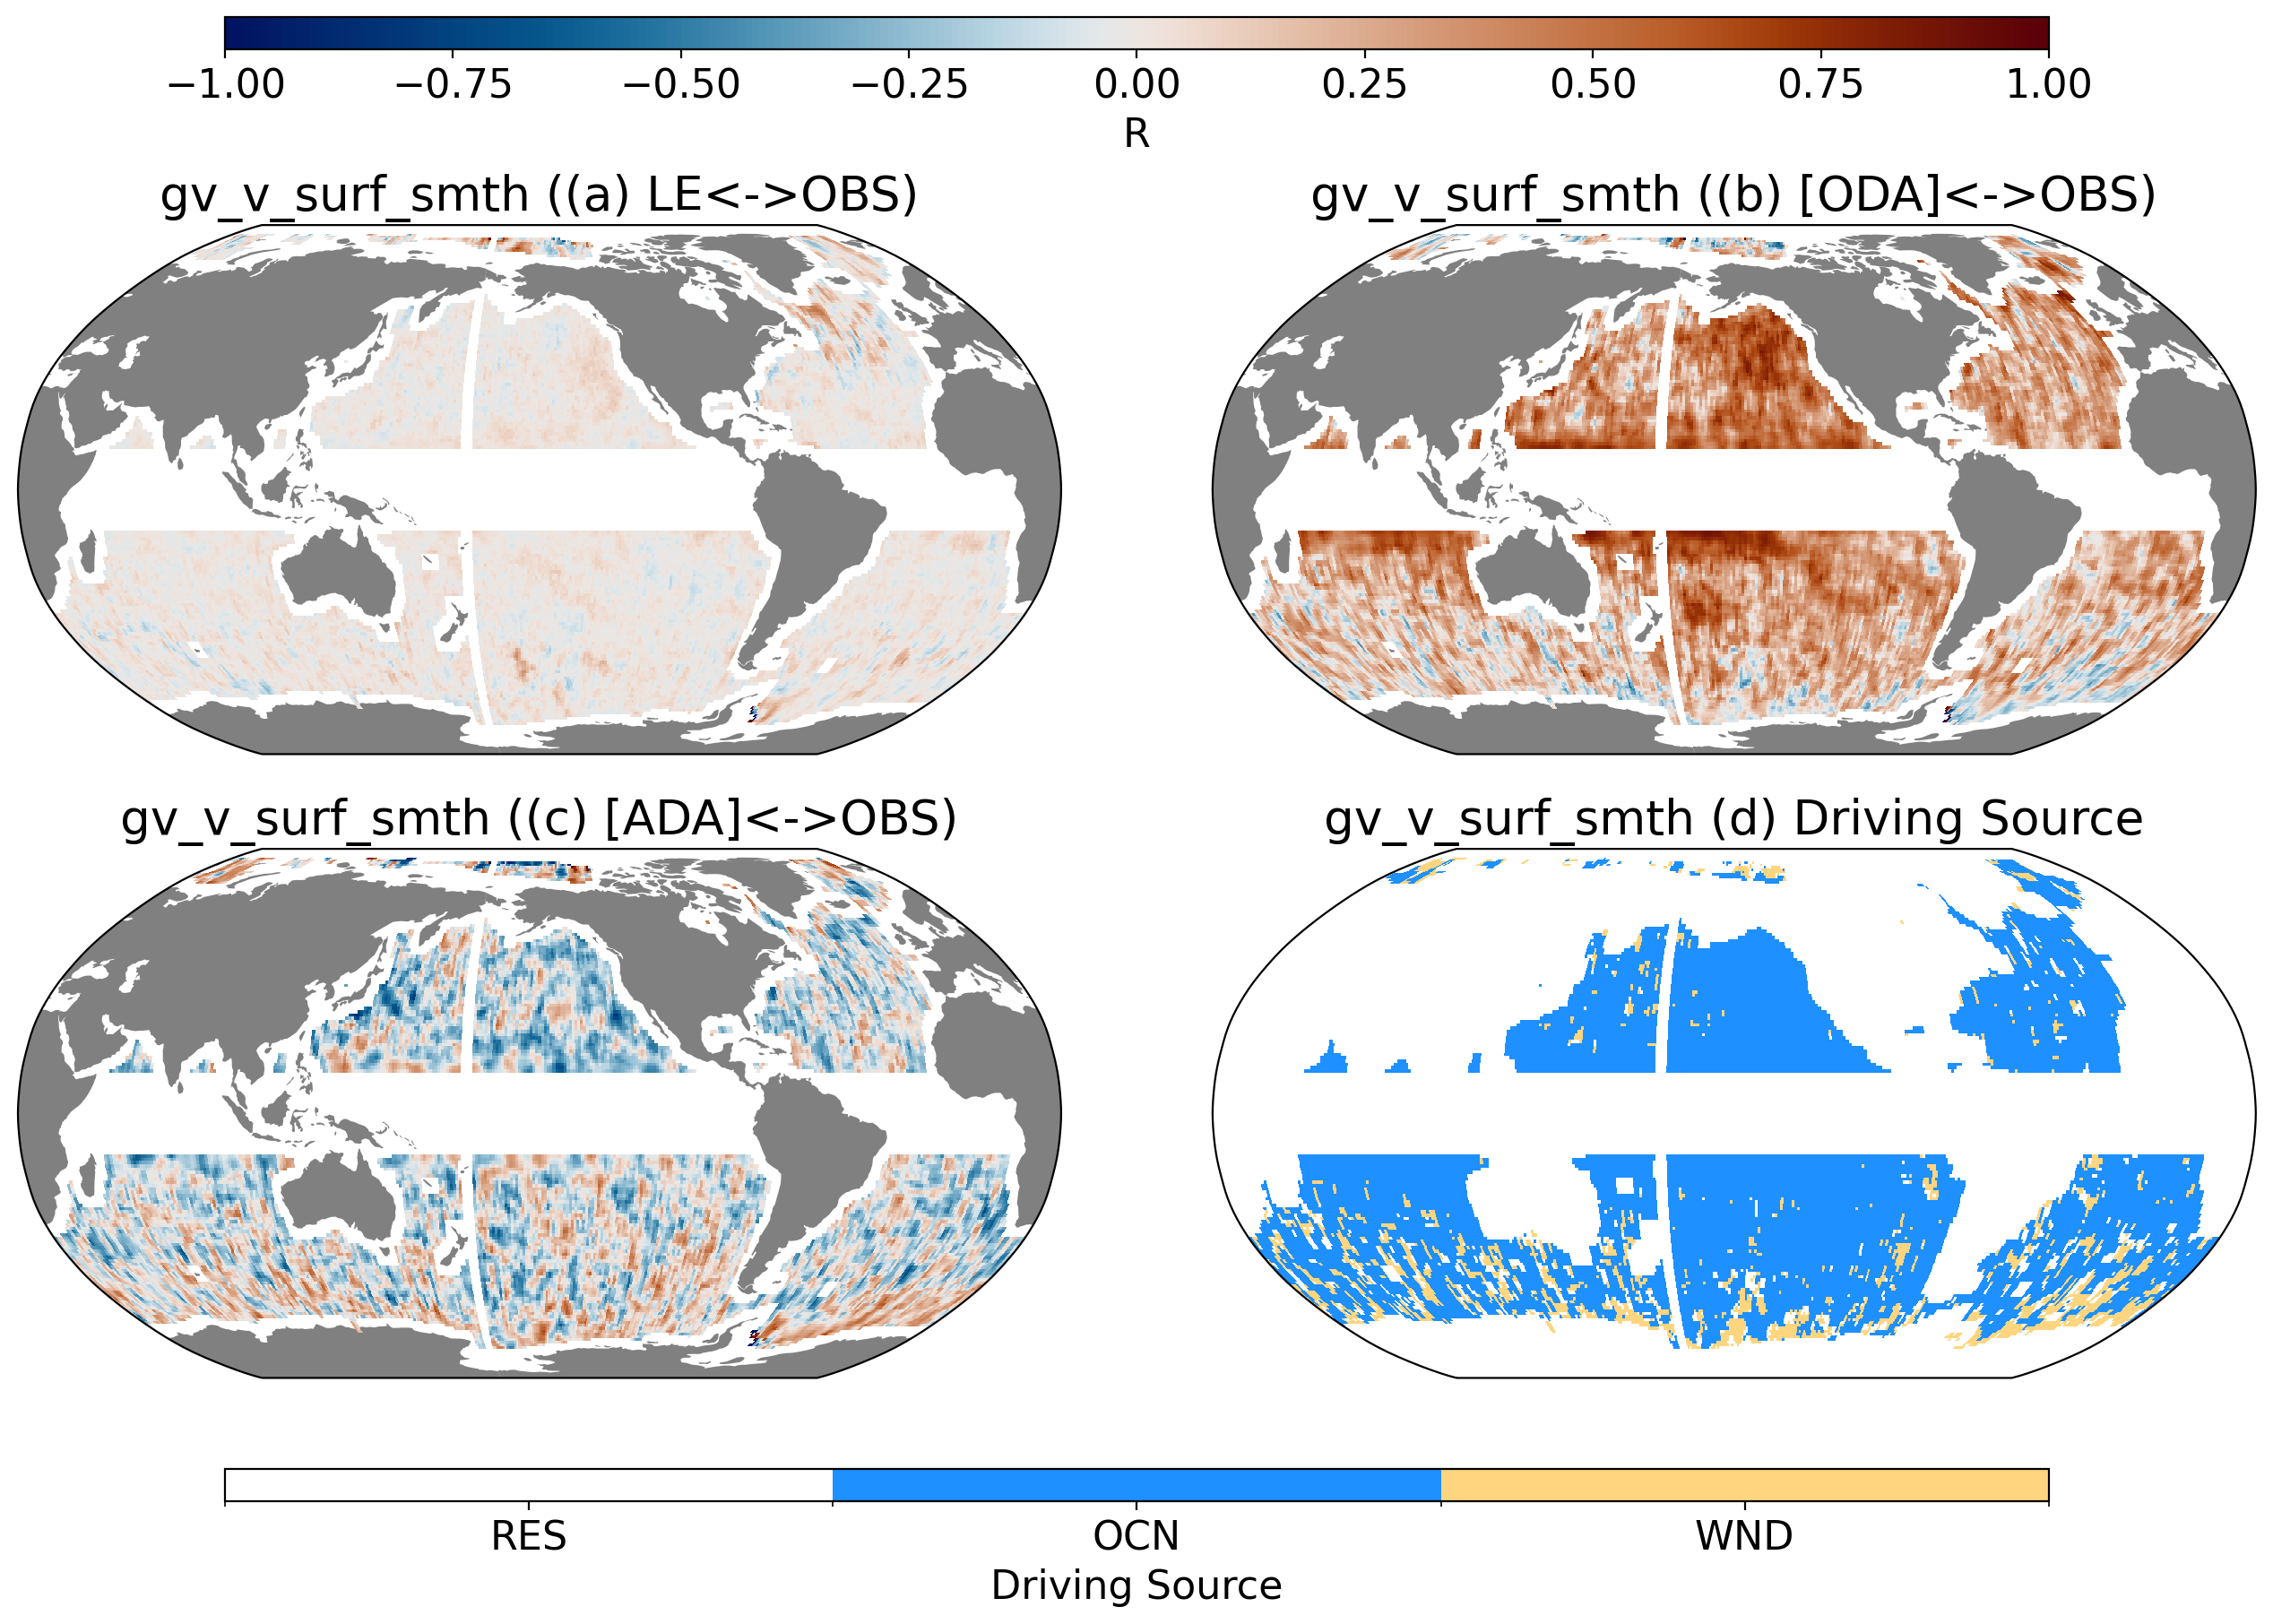

In [216]:
# gv fig (u_smth)
from scipy.stats import ttest_1samp

land_feature = cfeature.LAND.with_scale('110m')

varn='gv_v_surf_smth'
# plot for LE

projection = ccrs.Robinson(central_longitude=205)
cbar_kwargs={'orientation':'horizontal','pad':0.05,'shrink':0.7, 'label':' R ', 'aspect':33, 'extend': 'both'}

# 서브플롯 생성
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(18.5, 9), 
             dpi=200, facecolor='w', edgecolor='k', subplot_kw={'projection': projection})

data_array = corr_gv_v_surf_OBS_LE_smth.median(dim='ens_LE')
plt1=data_array.plot.pcolormesh(ax=axes[0, 0], transform=ccrs.PlateCarree(), vmax=1, vmin=-1,cmap=cm.vik, add_colorbar=False)
axes[0, 0].set_title(f'{varn} ((a) LE<->OBS)')
axes[0, 0].add_feature(land_feature, facecolor='gray', edgecolor='none')
    
# plot for (ODA)
data_array = corr_gv_v_surf_OBS_ODA_diff_smth.median(dim='ens_ODA')
plt1=data_array.plot.pcolormesh(ax=axes[0, 1], transform=ccrs.PlateCarree(), vmax=1, vmin=-1,cmap=cm.vik, add_colorbar=False)
axes[0, 1].set_title(f'{varn} ((b) [ODA]<->OBS)')
axes[0, 1].add_feature(land_feature, facecolor='gray', edgecolor='none')

# plot for (ADA)
data_array = corr_gv_v_surf_OBS_ADA_diff_smth.median(dim='ens_ADA')
plt1=data_array.plot.pcolormesh(ax=axes[1, 0], transform=ccrs.PlateCarree(), vmax=1, vmin=-1,cmap=cm.vik, add_colorbar=False)
axes[1, 0].set_title(f'{varn} ((c) [ADA]<->OBS)')
axes[1, 0].add_feature(land_feature, facecolor='gray', edgecolor='none')


# plot for (WND ODA mask)
alpha = 0.10

t_stat_LE, p_values_LE = ttest_1samp(corr_gv_v_surf_OBS_LE_smth, 0, axis=2)
ds_LE = corr_gv_v_surf_OBS_LE_smth.median(dim='ens_LE').where(p_values_LE < alpha)

t_stat_ODA, p_values_ODA = ttest_1samp(corr_gv_v_surf_OBS_ODA_diff_smth, 0, axis=2)
ds_ODA = corr_gv_v_surf_OBS_ODA_diff_smth.median(dim='ens_ODA').where(p_values_ODA < alpha)

t_stat_ADA, p_values_ADA = ttest_1samp(corr_gv_v_surf_OBS_ADA_diff_smth, 0, axis=2)
ds_ADA = corr_gv_v_surf_OBS_ADA_diff_smth.median(dim='ens_ADA').where(p_values_ADA < alpha)

threshold = 0
mask_LE = ds_LE > threshold
mask_ODA = ds_ODA > threshold
mask_ADA = ds_ADA > threshold

ds_all = xr.Dataset(
    data_vars=dict(
        colors=(('lat', 'lon'), np.full(ds_LE.shape, 0.33))  # 'colors'라는 변수 추가
    ),
    coords=dict(
        lat=(('lat'), mask_LE.lat.data),  # DataArray의 .data 사용
        lon=(('lon'), mask_LE.lon.data)     # DataArray의 .data 사용
    )
)

# ds_all['colors'] = xr.where(ds_grid.REGION_MASK == 0, 0.0, ds_all['colors']) # 흰색
ds_all['colors'] = xr.where(mask_LE.isnull(), 0.0, ds_all['colors']) # 흰색
ds_all['colors'] = xr.where(mask_ODA & ~mask_ADA, 0.5, ds_all['colors'])  # 파란색
ds_all['colors'] = xr.where(mask_ODA & mask_ADA, 0.5, ds_all['colors'])  # 파란색
ds_all['colors'] = xr.where(~mask_ODA & mask_ADA, 1.0, ds_all['colors'])  # 주황색
ds_all['colors'] = xr.where(mask_LE & ~mask_ODA, 0, ds_all['colors'])  # 주황색

colors_custom = ['#FFFFFF',  # 흰색 (White)
          '#1E90FF',  # Dodger blue (ODA)
          '#FFD580']  # 파스텔 오렌지 (WND) 

# Define boundaries so each color covers exactly one bin:
bounds = [0, 0.5, 1, 1.5]  # or [0, 0.33, 0.66, 1] if your data is in [0..1]
cmap = mcolors.ListedColormap(colors_custom)
norm = mcolors.BoundaryNorm(bounds, cmap.N)

plt4=ds_all['colors'].plot.pcolormesh(ax=axes[1, 1], transform=ccrs.PlateCarree(), cmap=mcolors.ListedColormap(colors_custom), add_colorbar=False, norm=norm)
axes[1, 1].set_title(f'{varn} (d) Driving Source')
axes[1, 1].add_feature(land_feature, facecolor='gray', edgecolor='none')


# (a), (b), (c) 서브플롯에 대해 위쪽에 큰 컬러바 추가
cbar_a_c = fig.add_axes([0.1, 0.95, 0.55, 0.02])  # [left, bottom, width, height] 비율로 컬러바 위치와 크기 설정
cbar1 = plt.colorbar(plt1, cax=cbar_a_c, orientation='horizontal')
cbar1.set_label('R')

# (d) 서브플롯에 대해 아래쪽에 큰 컬러바 추가
cbar_d = fig.add_axes([0.1, 0.05, 0.55, 0.02])  # [left, bottom, width, height] 비율로 컬러바 위치와 크기 설정
# cbar2= plt.colorbar(plt4, cax=cbar_d, orientation='horizontal')
cbar2 = plt.colorbar(plt4, cax=cbar_d, orientation='horizontal',
                     boundaries=bounds, ticks=[0.25, 0.75, 1.25])
cbar2.set_label('Driving Source')
# num_colors = len(colors_custom)
# tick_locs = np.linspace(0.5 / num_colors, 1 - 0.5 / num_colors, num_colors)
# tick_locs = np.linspace(0.25, 0.75, 3)
# cbar2.set_ticks(tick_locs)  # 눈금 설정
cbar2.set_ticklabels(['RES', 'OCN', 'WND'])  # 눈금 레이블 설정

plt.rcParams.update({'font.size': 16})

# 전체 레이아웃 조정
plt.tight_layout(rect=[0, 0.1, 0.75, 0.9])  # 상단과 하단의 레이아웃 여백을 맞추기 위해 rect 설정
# plt.tight_layout()
plt.savefig(savefilepath +"/BGC_Pred_SFig3_gvu.tif", format='tiff', dpi=150, bbox_inches='tight')
plt.show()



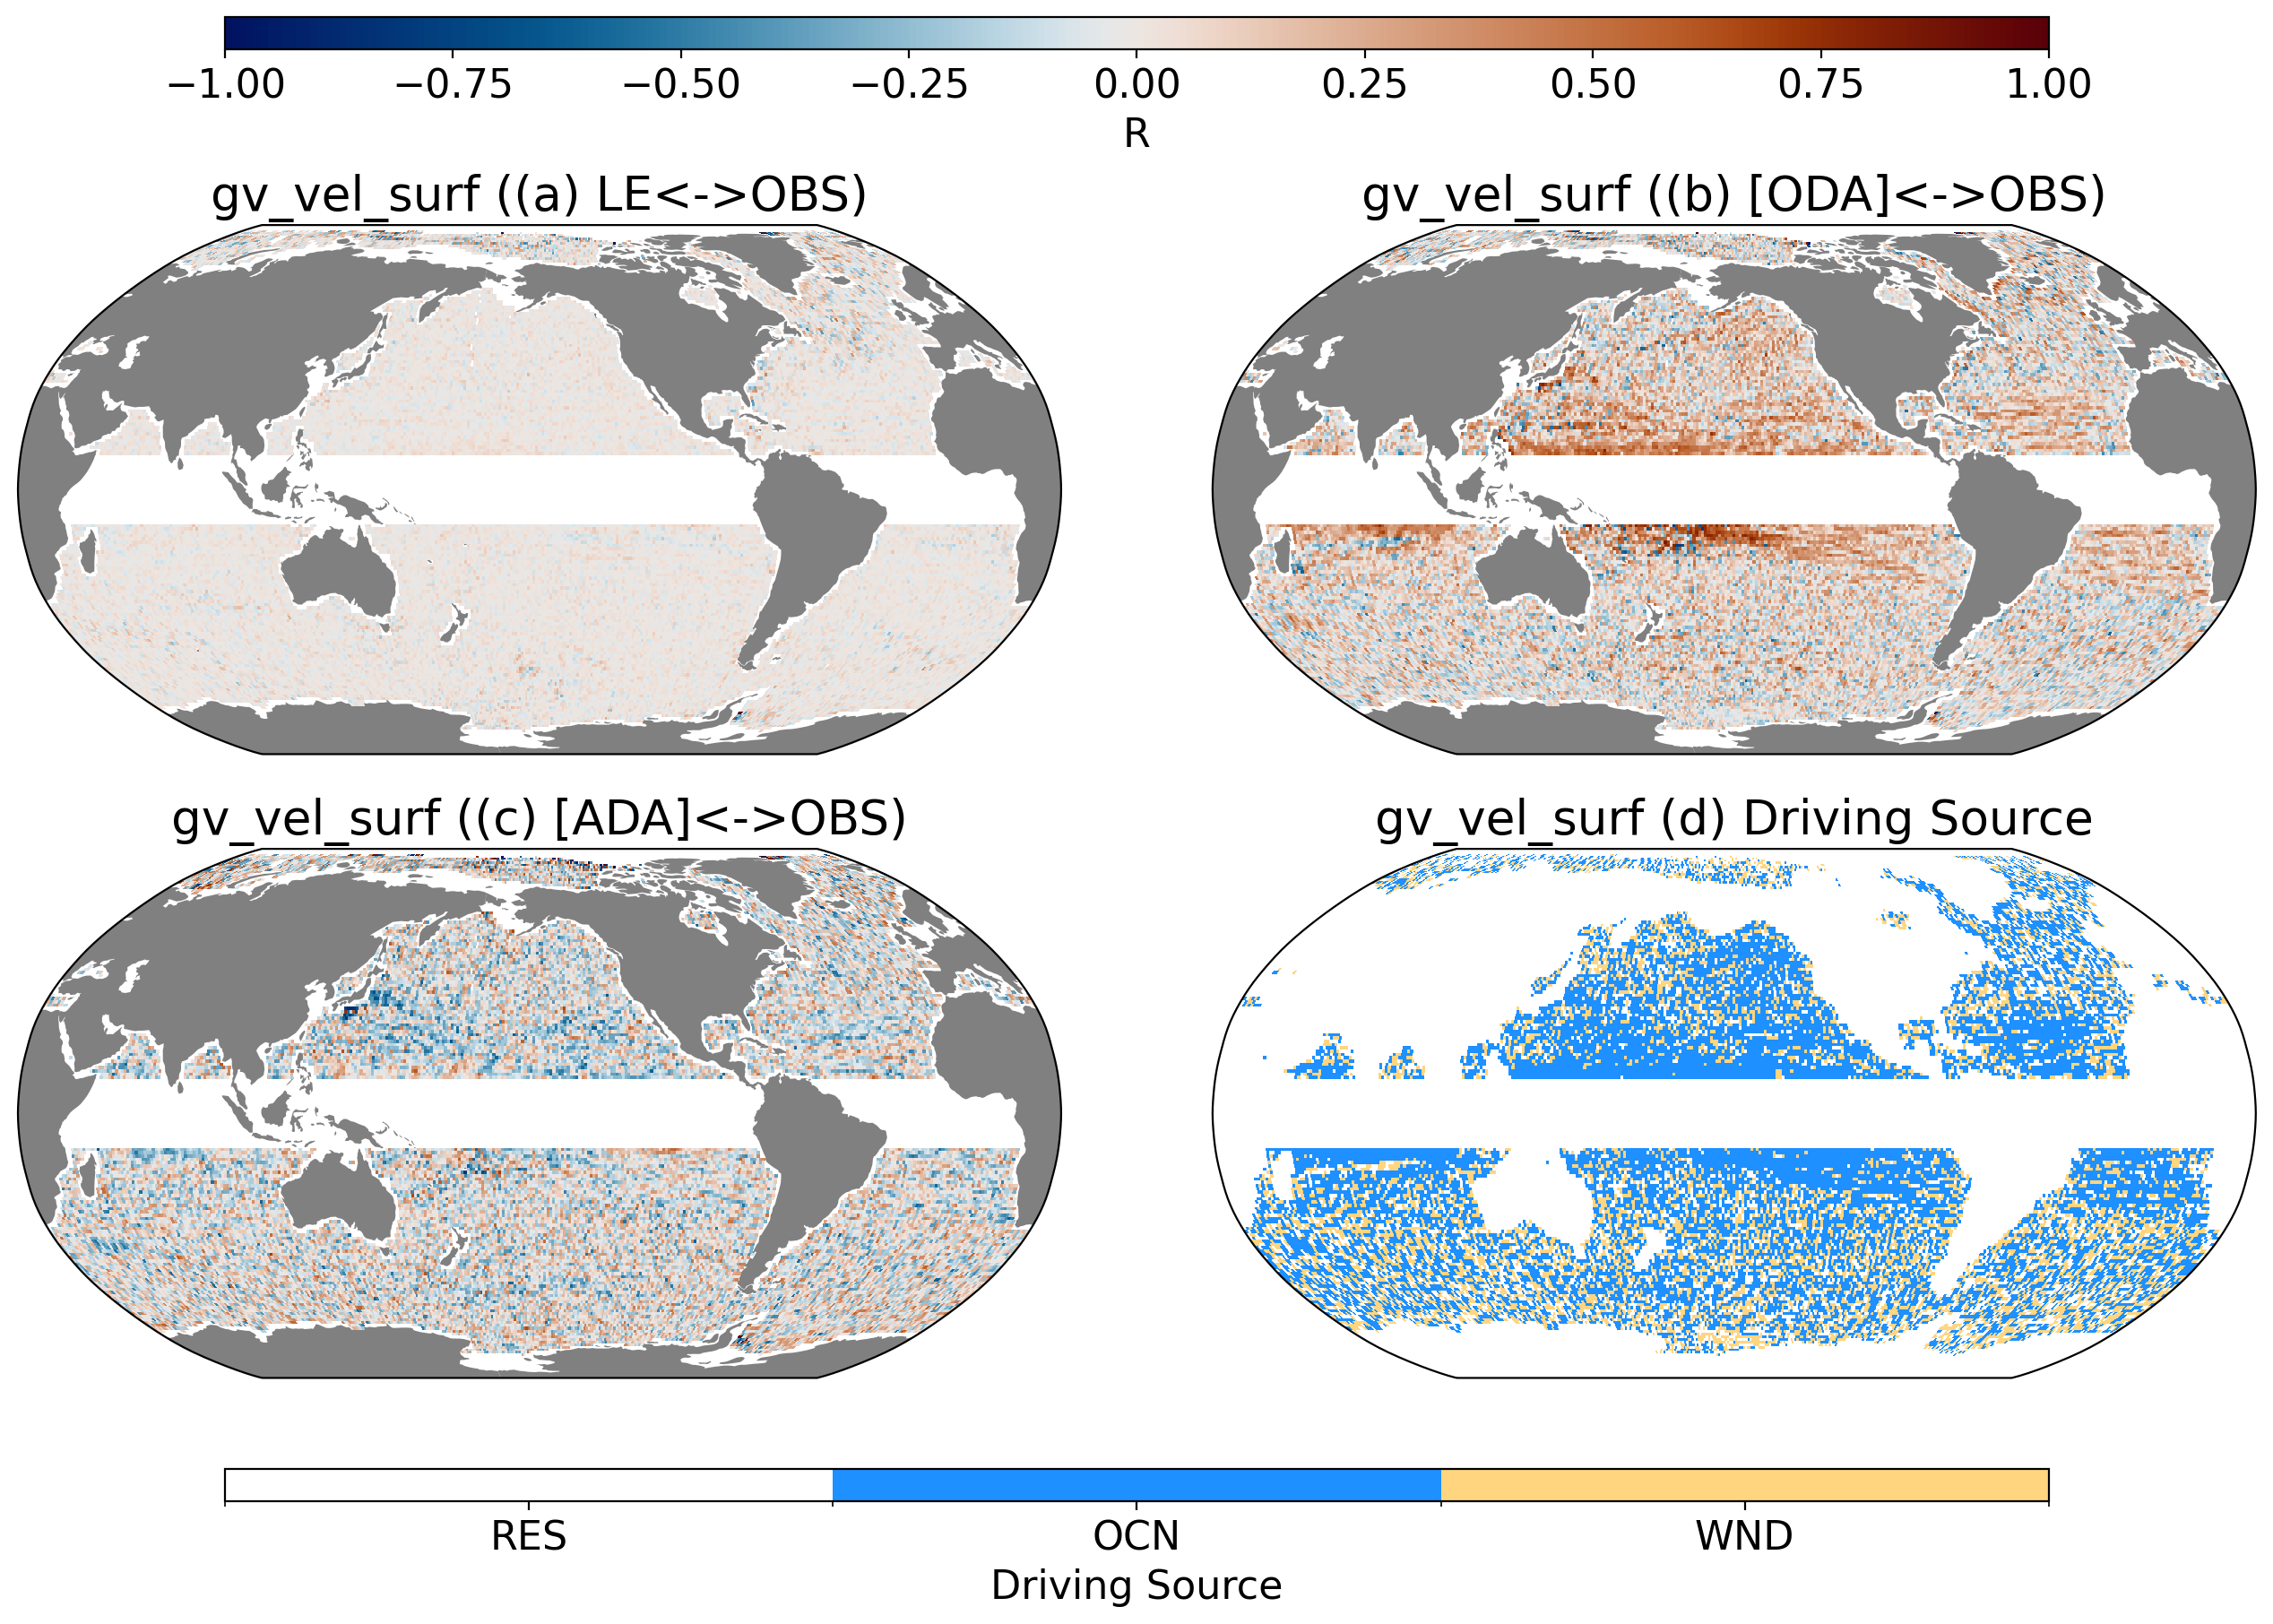

In [189]:
# gv fig (vel)
from scipy.stats import ttest_1samp

land_feature = cfeature.LAND.with_scale('110m')

cfg_var_gv_vel_surf.var = 'gv_vel_surf'
varn=cfg_var_gv_vel_surf.var
# plot for LE

projection = ccrs.Robinson(central_longitude=205)
cbar_kwargs={'orientation':'horizontal','pad':0.05,'shrink':0.7, 'label':' R ', 'aspect':33, 'extend': 'both'}

# 서브플롯 생성
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(18.5, 9), 
             dpi=200, facecolor='w', edgecolor='k', subplot_kw={'projection': projection})

data_array = corr_gv_vel_surf_OBS_LE.median(dim='ens_LE')
plt1=data_array.plot.pcolormesh(ax=axes[0, 0], transform=ccrs.PlateCarree(), vmax=1, vmin=-1,cmap=cm.vik, add_colorbar=False)
axes[0, 0].set_title(f'{varn} ((a) LE<->OBS)')
axes[0, 0].add_feature(land_feature, facecolor='gray', edgecolor='none')
    
# plot for (ODA)
data_array = corr_gv_vel_surf_OBS_ODA_diff.median(dim='ens_ODA')
plt1=data_array.plot.pcolormesh(ax=axes[0, 1], transform=ccrs.PlateCarree(), vmax=1, vmin=-1,cmap=cm.vik, add_colorbar=False)
axes[0, 1].set_title(f'{varn} ((b) [ODA]<->OBS)')
axes[0, 1].add_feature(land_feature, facecolor='gray', edgecolor='none')

# plot for (ADA)
data_array = corr_gv_vel_surf_OBS_ADA_diff.median(dim='ens_ADA')
plt1=data_array.plot.pcolormesh(ax=axes[1, 0], transform=ccrs.PlateCarree(), vmax=1, vmin=-1,cmap=cm.vik, add_colorbar=False)
axes[1, 0].set_title(f'{varn} ((c) [ADA]<->OBS)')
axes[1, 0].add_feature(land_feature, facecolor='gray', edgecolor='none')


# plot for (WND ODA mask)
alpha = 0.10

t_stat_LE, p_values_LE = ttest_1samp(corr_gv_vel_surf_OBS_LE, 0, axis=2)
ds_LE = corr_gv_vel_surf_OBS_LE.median(dim='ens_LE').where(p_values_LE < alpha)

t_stat_ODA, p_values_ODA = ttest_1samp(corr_gv_vel_surf_OBS_ODA_diff, 0, axis=2)
ds_ODA = corr_gv_vel_surf_OBS_ODA_diff.median(dim='ens_ODA').where(p_values_ODA < alpha)

t_stat_ADA, p_values_ADA = ttest_1samp(corr_gv_vel_surf_OBS_ADA_diff, 0, axis=2)
ds_ADA = corr_gv_vel_surf_OBS_ADA_diff.median(dim='ens_ADA').where(p_values_ADA < alpha)

threshold = 0
mask_LE = ds_LE > threshold
mask_ODA = ds_ODA > threshold
mask_ADA = ds_ADA > threshold

ds_all = xr.Dataset(
    data_vars=dict(
        colors=(('lat', 'lon'), np.full(ds_LE.shape, 0.33))  # 'colors'라는 변수 추가
    ),
    coords=dict(
        lat=(('lat'), mask_LE.lat.data),  # DataArray의 .data 사용
        lon=(('lon'), mask_LE.lon.data)     # DataArray의 .data 사용
    )
)

# ds_all['colors'] = xr.where(ds_grid.REGION_MASK == 0, 0.0, ds_all['colors']) # 흰색
ds_all['colors'] = xr.where(mask_LE.isnull(), 0.0, ds_all['colors']) # 흰색
ds_all['colors'] = xr.where(mask_ODA & ~mask_ADA, 0.5, ds_all['colors'])  # 파란색
ds_all['colors'] = xr.where(mask_ODA & mask_ADA, 0.5, ds_all['colors'])  # 파란색
ds_all['colors'] = xr.where(~mask_ODA & mask_ADA, 1.0, ds_all['colors'])  # 주황색
ds_all['colors'] = xr.where(mask_LE & ~mask_ODA, 0, ds_all['colors'])  # 주황색

colors_custom = ['#FFFFFF',  # 흰색 (White)
          '#1E90FF',  # Dodger blue (ODA)
          '#FFD580']  # 파스텔 오렌지 (WND) 

# Define boundaries so each color covers exactly one bin:
bounds = [0, 0.5, 1, 1.5]  # or [0, 0.33, 0.66, 1] if your data is in [0..1]
cmap = mcolors.ListedColormap(colors_custom)
norm = mcolors.BoundaryNorm(bounds, cmap.N)

plt4=ds_all['colors'].plot.pcolormesh(ax=axes[1, 1], transform=ccrs.PlateCarree(), cmap=mcolors.ListedColormap(colors_custom), add_colorbar=False, norm=norm)
axes[1, 1].set_title(f'{varn} (d) Driving Source')
axes[1, 1].add_feature(land_feature, facecolor='gray', edgecolor='none')


# (a), (b), (c) 서브플롯에 대해 위쪽에 큰 컬러바 추가
cbar_a_c = fig.add_axes([0.1, 0.95, 0.55, 0.02])  # [left, bottom, width, height] 비율로 컬러바 위치와 크기 설정
cbar1 = plt.colorbar(plt1, cax=cbar_a_c, orientation='horizontal')
cbar1.set_label('R')

# (d) 서브플롯에 대해 아래쪽에 큰 컬러바 추가
cbar_d = fig.add_axes([0.1, 0.05, 0.55, 0.02])  # [left, bottom, width, height] 비율로 컬러바 위치와 크기 설정
# cbar2= plt.colorbar(plt4, cax=cbar_d, orientation='horizontal')
cbar2 = plt.colorbar(plt4, cax=cbar_d, orientation='horizontal',
                     boundaries=bounds, ticks=[0.25, 0.75, 1.25])
cbar2.set_label('Driving Source')
# num_colors = len(colors_custom)
# tick_locs = np.linspace(0.5 / num_colors, 1 - 0.5 / num_colors, num_colors)
# tick_locs = np.linspace(0.25, 0.75, 3)
# cbar2.set_ticks(tick_locs)  # 눈금 설정
cbar2.set_ticklabels(['RES', 'OCN', 'WND'])  # 눈금 레이블 설정

plt.rcParams.update({'font.size': 16})

# 전체 레이아웃 조정
plt.tight_layout(rect=[0, 0.1, 0.75, 0.9])  # 상단과 하단의 레이아웃 여백을 맞추기 위해 rect 설정
# plt.tight_layout()
plt.savefig(savefilepath +"/BGC_Pred_SFig3_gvu.tif", format='tiff', dpi=150, bbox_inches='tight')
plt.show()



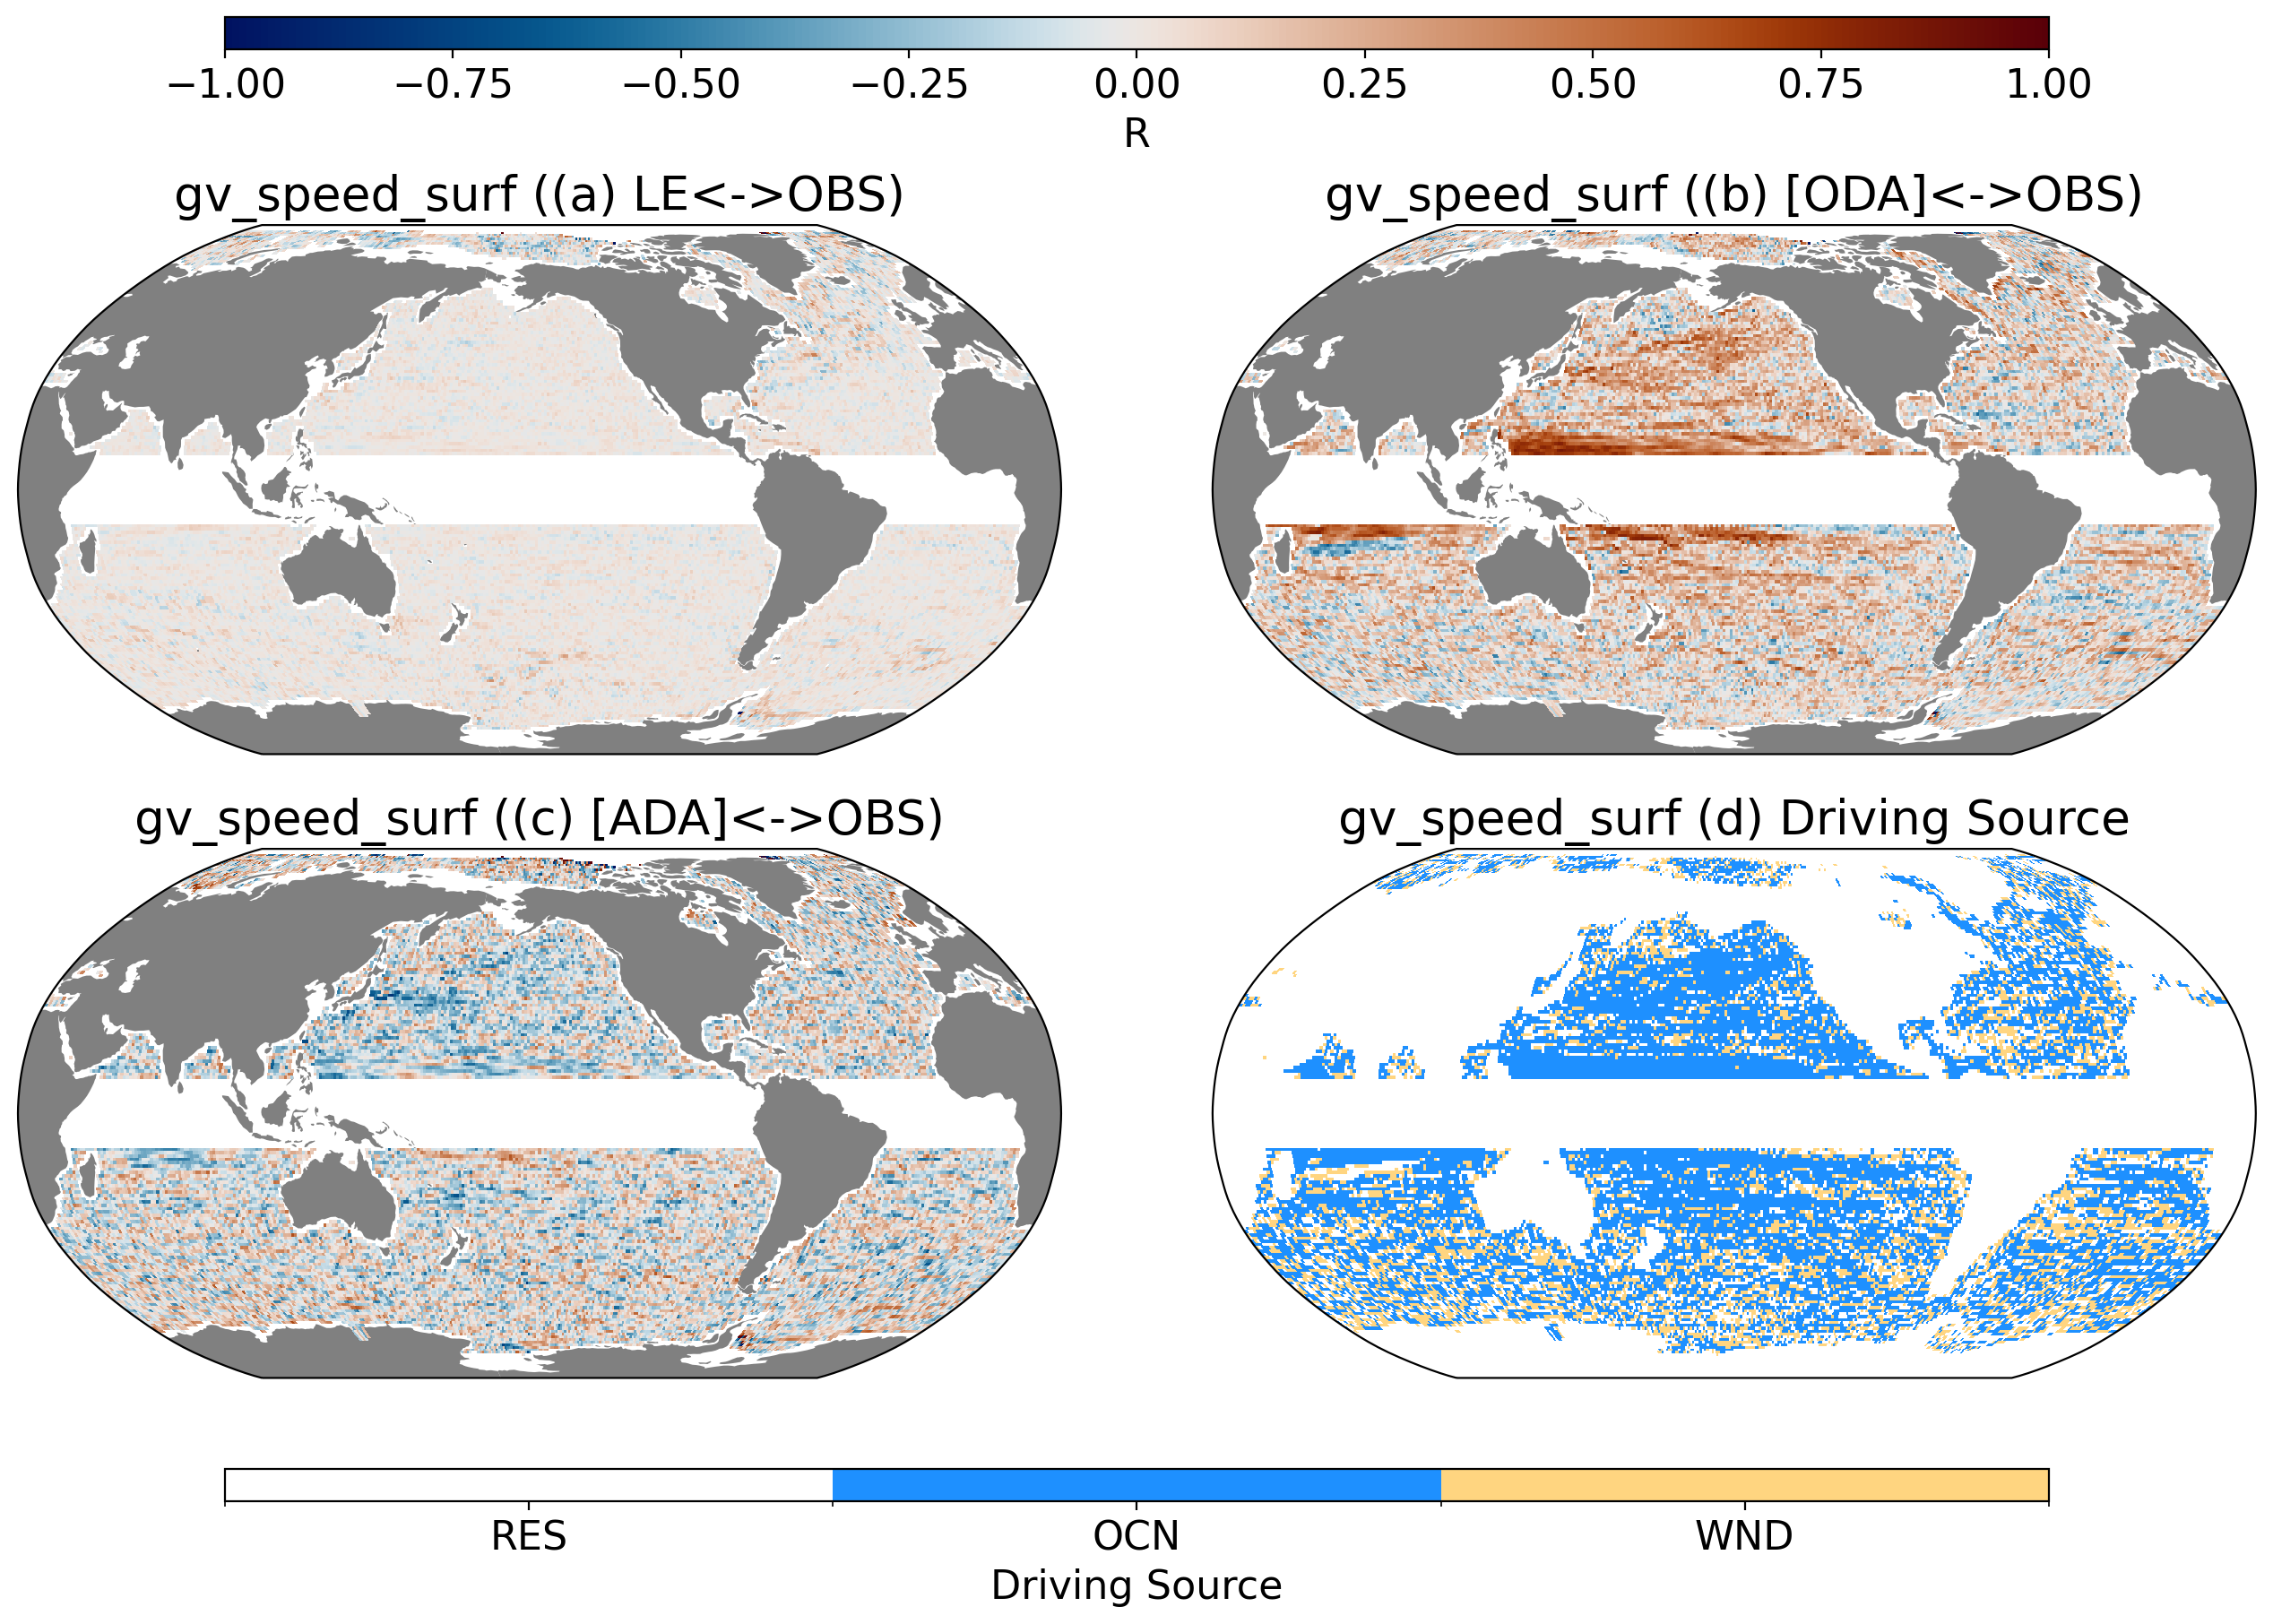

In [193]:
# gv fig (vel)
from scipy.stats import ttest_1samp

land_feature = cfeature.LAND.with_scale('110m')

cfg_var_gv_speed_surf.var = 'gv_speed_surf'
varn=cfg_var_gv_speed_surf.var
# plot for LE

projection = ccrs.Robinson(central_longitude=205)
cbar_kwargs={'orientation':'horizontal','pad':0.05,'shrink':0.7, 'label':' R ', 'aspect':33, 'extend': 'both'}

# 서브플롯 생성
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(18.5, 9), 
             dpi=200, facecolor='w', edgecolor='k', subplot_kw={'projection': projection})

data_array = corr_gv_speed_surf_OBS_LE.median(dim='ens_LE')
plt1=data_array.plot.pcolormesh(ax=axes[0, 0], transform=ccrs.PlateCarree(), vmax=1, vmin=-1,cmap=cm.vik, add_colorbar=False)
axes[0, 0].set_title(f'{varn} ((a) LE<->OBS)')
axes[0, 0].add_feature(land_feature, facecolor='gray', edgecolor='none')
    
# plot for (ODA)
data_array = corr_gv_speed_surf_OBS_ODA_diff.median(dim='ens_ODA')
plt1=data_array.plot.pcolormesh(ax=axes[0, 1], transform=ccrs.PlateCarree(), vmax=1, vmin=-1,cmap=cm.vik, add_colorbar=False)
axes[0, 1].set_title(f'{varn} ((b) [ODA]<->OBS)')
axes[0, 1].add_feature(land_feature, facecolor='gray', edgecolor='none')

# plot for (ADA)
data_array = corr_gv_speed_surf_OBS_ADA_diff.median(dim='ens_ADA')
plt1=data_array.plot.pcolormesh(ax=axes[1, 0], transform=ccrs.PlateCarree(), vmax=1, vmin=-1,cmap=cm.vik, add_colorbar=False)
axes[1, 0].set_title(f'{varn} ((c) [ADA]<->OBS)')
axes[1, 0].add_feature(land_feature, facecolor='gray', edgecolor='none')


# plot for (WND ODA mask)
alpha = 0.10

t_stat_LE, p_values_LE = ttest_1samp(corr_gv_speed_surf_OBS_LE, 0, axis=2)
ds_LE = corr_gv_speed_surf_OBS_LE.median(dim='ens_LE').where(p_values_LE < alpha)

t_stat_ODA, p_values_ODA = ttest_1samp(corr_gv_speed_surf_OBS_ODA_diff, 0, axis=2)
ds_ODA = corr_gv_speed_surf_OBS_ODA_diff.median(dim='ens_ODA').where(p_values_ODA < alpha)

t_stat_ADA, p_values_ADA = ttest_1samp(corr_gv_speed_surf_OBS_ADA_diff, 0, axis=2)
ds_ADA = corr_gv_speed_surf_OBS_ADA_diff.median(dim='ens_ADA').where(p_values_ADA < alpha)

threshold = 0
mask_LE = ds_LE > threshold
mask_ODA = ds_ODA > threshold
mask_ADA = ds_ADA > threshold

ds_all = xr.Dataset(
    data_vars=dict(
        colors=(('lat', 'lon'), np.full(ds_LE.shape, 0.33))  # 'colors'라는 변수 추가
    ),
    coords=dict(
        lat=(('lat'), mask_LE.lat.data),  # DataArray의 .data 사용
        lon=(('lon'), mask_LE.lon.data)     # DataArray의 .data 사용
    )
)

# ds_all['colors'] = xr.where(ds_grid.REGION_MASK == 0, 0.0, ds_all['colors']) # 흰색
ds_all['colors'] = xr.where(mask_LE.isnull(), 0.0, ds_all['colors']) # 흰색
ds_all['colors'] = xr.where(mask_ODA & ~mask_ADA, 0.5, ds_all['colors'])  # 파란색
ds_all['colors'] = xr.where(mask_ODA & mask_ADA, 0.5, ds_all['colors'])  # 파란색
ds_all['colors'] = xr.where(~mask_ODA & mask_ADA, 1.0, ds_all['colors'])  # 주황색
ds_all['colors'] = xr.where(mask_LE & ~mask_ODA, 0, ds_all['colors'])  # 주황색

colors_custom = ['#FFFFFF',  # 흰색 (White)
          '#1E90FF',  # Dodger blue (ODA)
          '#FFD580']  # 파스텔 오렌지 (WND) 

# Define boundaries so each color covers exactly one bin:
bounds = [0, 0.5, 1, 1.5]  # or [0, 0.33, 0.66, 1] if your data is in [0..1]
cmap = mcolors.ListedColormap(colors_custom)
norm = mcolors.BoundaryNorm(bounds, cmap.N)

plt4=ds_all['colors'].plot.pcolormesh(ax=axes[1, 1], transform=ccrs.PlateCarree(), cmap=mcolors.ListedColormap(colors_custom), add_colorbar=False, norm=norm)
axes[1, 1].set_title(f'{varn} (d) Driving Source')
axes[1, 1].add_feature(land_feature, facecolor='gray', edgecolor='none')


# (a), (b), (c) 서브플롯에 대해 위쪽에 큰 컬러바 추가
cbar_a_c = fig.add_axes([0.1, 0.95, 0.55, 0.02])  # [left, bottom, width, height] 비율로 컬러바 위치와 크기 설정
cbar1 = plt.colorbar(plt1, cax=cbar_a_c, orientation='horizontal')
cbar1.set_label('R')

# (d) 서브플롯에 대해 아래쪽에 큰 컬러바 추가
cbar_d = fig.add_axes([0.1, 0.05, 0.55, 0.02])  # [left, bottom, width, height] 비율로 컬러바 위치와 크기 설정
# cbar2= plt.colorbar(plt4, cax=cbar_d, orientation='horizontal')
cbar2 = plt.colorbar(plt4, cax=cbar_d, orientation='horizontal',
                     boundaries=bounds, ticks=[0.25, 0.75, 1.25])
cbar2.set_label('Driving Source')
# num_colors = len(colors_custom)
# tick_locs = np.linspace(0.5 / num_colors, 1 - 0.5 / num_colors, num_colors)
# tick_locs = np.linspace(0.25, 0.75, 3)
# cbar2.set_ticks(tick_locs)  # 눈금 설정
cbar2.set_ticklabels(['RES', 'OCN', 'WND'])  # 눈금 레이블 설정

plt.rcParams.update({'font.size': 16})

# 전체 레이아웃 조정
plt.tight_layout(rect=[0, 0.1, 0.75, 0.9])  # 상단과 하단의 레이아웃 여백을 맞추기 위해 rect 설정
# plt.tight_layout()
plt.savefig(savefilepath +"/BGC_Pred_SFig3_gvu.tif", format='tiff', dpi=150, bbox_inches='tight')
plt.show()



# biogeochemical variable setting

# Chl (diat, sp, diaz)

In [23]:
cfg_var_diatChl=CESM2_config()
cfg_var_diatChl.year_s=1960
cfg_var_diatChl.year_e=2020
cfg_var_diatChl.setvar('diatChl')

cfg_var_spChl=CESM2_config()
cfg_var_spChl.year_s=1960
cfg_var_spChl.year_e=2020
cfg_var_spChl.setvar('spChl')

cfg_var_diazChl=CESM2_config()
cfg_var_diazChl.year_s=1960
cfg_var_diazChl.year_e=2020
cfg_var_diazChl.setvar('diazChl')

cfg_var_diatChl_SURF=CESM2_config()
cfg_var_diatChl_SURF.year_s=1960
cfg_var_diatChl_SURF.year_e=2020
cfg_var_diatChl_SURF.setvar('diatChl_SURF')

cfg_var_spChl_SURF=CESM2_config()
cfg_var_spChl_SURF.year_s=1960
cfg_var_spChl_SURF.year_e=2020
cfg_var_spChl_SURF.setvar('spChl_SURF')

cfg_var_diazChl_SURF=CESM2_config()
cfg_var_diazChl_SURF.year_s=1960
cfg_var_diazChl_SURF.year_e=2020
cfg_var_diazChl_SURF.setvar('diazChl_SURF')

In [53]:
def process_coords_bgc_surface(
    ds, sd, ed, varname, drop=True,
    except_coord_vars=["time","lon","lat","TLONG","TLAT", "diatChl", "diazChl", "spChl"]
):
    import xcesm
    import numpy as np
    import datetime

    coord_vars = []
    for v in np.array(ds.coords):
        if v not in except_coord_vars:
            coord_vars.append(v)
    for v in np.array(ds.data_vars):
        if v not in except_coord_vars:
            coord_vars.append(v)

    if drop:
        ds = ds.drop(coord_vars)
        ds = ds.sel(time=slice(sd, ed))
        # ds = ds.isel(z_t_150m=slice(0,10)) 
        ds = ds.isel(z_t_150m=0) 
        ds_rgd = ds[varname].utils.regrid()

        new_time = ds_rgd.time - np.array([datetime.timedelta(days=15)] * len(ds.time))
        ds_rgd = ds_rgd.assign_coords(time=new_time)
        
        return ds_rgd
    else:
        return ds.set_coords(coord_vars)


def process_coords_bgc_2d(
    ds, sd, ed, varname, drop=True,
    except_coord_vars=["time","lon","lat","TLONG","TLAT","SSH", "diatChl_SURF", "diazChl_SURF", "spChl_SURF", 
                      "photoC_TOT_zint_100m", "photoC_diat_zint_100m", "photoC_diaz_zint_100m", "photoC_sp_zint_100m"]
):
    import xcesm
    import numpy as np
    import datetime

    coord_vars = []
    for v in np.array(ds.coords):
        if v not in except_coord_vars:
            coord_vars.append(v)
    for v in np.array(ds.data_vars):
        if v not in except_coord_vars:
            coord_vars.append(v)

    if drop:
        ds = ds.drop(coord_vars)
        ds = ds.sel(time=slice(sd, ed))
        ds_rgd = ds[varname].utils.regrid()

        new_time = ds_rgd.time - np.array([datetime.timedelta(days=15)] * len(ds.time))
        ds_rgd = ds_rgd.assign_coords(time=new_time)
        # ds_rgd=ds_rgd.groupby('time.year').mean(dim='time', skipna=True)

        return ds_rgd
    else:
        return ds.set_coords(coord_vars)


def process_coords_bgc_2d_daily(
    ds, sd, ed, varname, drop=True,
    except_coord_vars=["time","lon","lat","TLONG","TLAT","SSH", "diatChl_SURF", "diazChl_SURF", "spChl_SURF"]
):
    import xcesm
    import numpy as np
    import datetime

    coord_vars = []
    for v in np.array(ds.coords):
        if v not in except_coord_vars:
            coord_vars.append(v)
    for v in np.array(ds.data_vars):
        if v not in except_coord_vars:
            coord_vars.append(v)

    if drop:
        # ds = ds.drop(coord_vars)
        ds = ds.sel(time=slice(sd, ed))
        ds_rgd = ds[varname].utils.regrid()
        new_time = ds_rgd.time - np.array([datetime.timedelta(days=0.5)] * len(ds_rgd.time))
        ds_rgd = ds_rgd.assign_coords(time=new_time)
        ds_rgd = ds_rgd.resample(time='1M').mean(skipna=True)
        
        # ds = ds[varname]
              
        return ds_rgd
        # return ds
    else:
        return ds.set_coords(coord_vars)


def process_coords_bgc_surface_hcst(
    ds, sd, ed, varname, drop=True,
    except_coord_vars=["time","lon","lat","TLONG","TLAT", "diatChl", "diazChl", "spChl"]
):
    import xcesm
    import numpy as np
    import datetime

    coord_vars = []
    for v in np.array(ds.coords):
        if v not in except_coord_vars:
            coord_vars.append(v)
    for v in np.array(ds.data_vars):
        if v not in except_coord_vars:
            coord_vars.append(v)

    if drop:
        ds = ds.drop(coord_vars)
        # ds = ds.isel(z_t_150m=slice(0,10)) 
        ds = ds.isel(z_t_150m=0) 
        ds_rgd = ds[varname].utils.regrid()

        new_time = ds_rgd.time - np.array([datetime.timedelta(days=15)] * len(ds.time))
        ds_rgd = ds_rgd.assign_coords(time=new_time)
        
        return ds_rgd
    else:
        return ds.set_coords(coord_vars)


def process_coords_bgc_2d_hcst(
    ds, sd, ed, varname, drop=True,
    except_coord_vars=["time","lon","lat","TLONG","TLAT","SSH", "diatChl_SURF", "diazChl_SURF", "spChl_SURF", 
                      "photoC_TOT_zint_100m", "photoC_diat_zint_100m", "photoC_diaz_zint_100m", "photoC_sp_zint_100m"]
):
    import xcesm
    import numpy as np
    import datetime

    coord_vars = []
    for v in np.array(ds.coords):
        if v not in except_coord_vars:
            coord_vars.append(v)
    for v in np.array(ds.data_vars):
        if v not in except_coord_vars:
            coord_vars.append(v)

    if drop:
        ds = ds.drop(coord_vars)
        ds_rgd = ds[varname].utils.regrid()

        new_time = ds_rgd.time - np.array([datetime.timedelta(days=15)] * len(ds.time))
        ds_rgd = ds_rgd.assign_coords(time=new_time)
        # ds_rgd=ds_rgd.groupby('time.year').mean(dim='time', skipna=True)

        return ds_rgd
    else:
        return ds.set_coords(coord_vars)

In [25]:
# Read LE dataset (diatChl_SURF)

start_time = time.time()

cfg_var_diatChl_SURF.LE_path_load(cfg_var_diatChl_SURF.var)
cfg_var_spChl_SURF.LE_path_load(cfg_var_spChl_SURF.var)
cfg_var_diazChl_SURF.LE_path_load(cfg_var_diazChl_SURF.var)

fpath_diatChl_SURF = savefilepath + "/LE_diatChl_SURF_output*.nc"
fpath_spChl_SURF = savefilepath + "/LE_spChl_SURF_output*.nc"
fpath_diazChl_SURF = savefilepath + "/LE_diazChl_SURF_output*.nc"

if os.path.exists(savefilepath + "/LE_diazChl_SURF_output49.nc"):
    # File already exists => read it
    cfg_var_diatChl_SURF.LE_ds = xr.open_mfdataset(fpath_diatChl_SURF, combine="nested", concat_dim="ens_LE")
    cfg_var_spChl_SURF.LE_ds = xr.open_mfdataset(fpath_spChl_SURF, combine="nested", concat_dim="ens_LE")
    cfg_var_diazChl_SURF.LE_ds = xr.open_mfdataset(fpath_diazChl_SURF, combine="nested", concat_dim="ens_LE")
    
    end_time = time.time()
    elapsed_time = end_time - start_time
    print(f"Opened existing Chl data from {fpath_diatChl_SURF}")
    print('elasped time for reading LE Chls : ' + str(elapsed_time))

else:
    cfg_var_diatChl_SURF.LE_ds = []
    cfg_var_spChl_SURF.LE_ds = []
    cfg_var_diazChl_SURF.LE_ds = []
    for imem in range(0, len(cfg_var_diatChl_SURF.LE_file_list[0])):
    # for imem in range(0, 2):
        diatChl_SURF_LE_ds_tmp = xr.open_mfdataset(cfg_var_diatChl_SURF.LE_file_list[0][imem], 
                               chunks={'time': 1}, 
                               combine='nested',
                               parallel=True,
                               preprocess=lambda ds: process_coords_bgc_2d_daily(ds, start_date, end_date, 'diatChl_SURF'),
                               decode_cf=True, 
                               decode_times=True)
        
        LE_ds_a= []
        LE_ds_a.append(diatChl_SURF_LE_ds_tmp)
        LE_ds_xr = xr.concat(LE_ds_a, dim='time')
        LE_ds_xr = LE_ds_xr.expand_dims({'ens_LE': 1})
        cfg_var_diatChl_SURF.LE_ds.append(LE_ds_xr)
    
        spChl_SURF_LE_ds_tmp = xr.open_mfdataset(cfg_var_spChl_SURF.LE_file_list[0][imem], 
                               chunks={'time': 1}, 
                               combine='nested',
                               parallel=True,
                               preprocess=lambda ds: process_coords_bgc_2d_daily(ds, start_date, end_date, 'spChl_SURF'),
                               decode_cf=True, 
                               decode_times=True)
        
        LE_ds_a= []
        LE_ds_a.append(spChl_SURF_LE_ds_tmp)
        LE_ds_xr = xr.concat(LE_ds_a, dim='time')
        LE_ds_xr = LE_ds_xr.expand_dims({'ens_LE': 1})
        cfg_var_spChl_SURF.LE_ds.append(LE_ds_xr)
    
        diazChl_SURF_LE_ds_tmp = xr.open_mfdataset(cfg_var_diazChl_SURF.LE_file_list[0][imem], 
                               chunks={'time': 1}, 
                               combine='nested',
                               parallel=True,
                               preprocess=lambda ds: process_coords_bgc_2d_daily(ds, start_date, end_date, 'diazChl_SURF'),
                               decode_cf=True, 
                               decode_times=True)
        
        LE_ds_a= []
        LE_ds_a.append(diazChl_SURF_LE_ds_tmp)
        LE_ds_xr = xr.concat(LE_ds_a, dim='time')
        LE_ds_xr = LE_ds_xr.expand_dims({'ens_LE': 1})
        cfg_var_diazChl_SURF.LE_ds.append(LE_ds_xr)
    
        end_time = time.time()
        elapsed_time = end_time - start_time
        print('elasped time for reading LE, ' + str(imem) + ': ' + str(elapsed_time))
    
    cfg_var_diatChl_SURF.LE_ds = xr.concat(cfg_var_diatChl_SURF.LE_ds, dim='ens_LE')
    cfg_var_diatChl_SURF.LE_ds['ens_LE']=range(0, len(cfg_var_diatChl_SURF.LE_file_list[0]))
    # cfg_var_diatChl_SURF.LE_ds['ens_LE']=range(0, 2)
    
    cfg_var_spChl_SURF.LE_ds = xr.concat(cfg_var_spChl_SURF.LE_ds, dim='ens_LE')
    cfg_var_spChl_SURF.LE_ds['ens_LE']=range(0, len(cfg_var_spChl_SURF.LE_file_list[0]))
    
    cfg_var_diazChl_SURF.LE_ds = xr.concat(cfg_var_diazChl_SURF.LE_ds, dim='ens_LE')
    cfg_var_diazChl_SURF.LE_ds['ens_LE']=range(0, len(cfg_var_diazChl_SURF.LE_file_list[0]))
    
    for imem in range(0, len(cfg_var_diatChl_SURF.LE_file_list[0])):
        ds = cfg_var_diatChl_SURF.LE_ds.isel(ens_LE=imem)
        ds.to_netcdf(savefilepath + "/LE_diatChl_SURF_output" + str(imem) + ".nc")
        ds = cfg_var_spChl_SURF.LE_ds.isel(ens_LE=imem)
        ds.to_netcdf(savefilepath + "/LE_spChl_SURF_output" + str(imem) + ".nc")
        ds = cfg_var_diazChl_SURF.LE_ds.isel(ens_LE=imem)
        ds.to_netcdf(savefilepath + "/LE_diazChl_SURF_output" + str(imem) + ".nc")


Opened existing Chl data from /mnt/lustre/proj/kimyy/tmp_python/HCST_paper_figure_1/LE_diatChl_SURF_output*.nc
elasped time for reading LE Chls : 17.153236865997314


# sum of Chlorophyll

In [26]:
# ODA Chl

cfg_var_diatChl.ODA_ds = []
cfg_var_spChl.ODA_ds = []
cfg_var_diazChl.ODA_ds = []

start_time = time.time()

fpath_diatChl = savefilepath + "/ODA_diatChl_output*.nc"
fpath_spChl = savefilepath + "/ODA_spChl_output*.nc"
fpath_diazChl = savefilepath + "/ODA_diazChl_output*.nc"

if os.path.exists(savefilepath + "/ODA_diazChl_output19.nc"):
    # File already exists => read it
    cfg_var_diatChl.ODA_ds = xr.open_mfdataset(fpath_diatChl, combine="nested", concat_dim="ens_ODA")
    cfg_var_spChl.ODA_ds = xr.open_mfdataset(fpath_spChl, combine="nested", concat_dim="ens_ODA")
    cfg_var_diazChl.ODA_ds = xr.open_mfdataset(fpath_diazChl, combine="nested", concat_dim="ens_ODA")
    
    end_time = time.time()
    elapsed_time = end_time - start_time
    print(f"Opened existing Chl data from {fpath_diatChl}")
    print('elasped time for reading LE Chls : ' + str(elapsed_time))

else:

    cfg_var_diatChl.ODA_path_load(cfg_var_diatChl.var)
    cfg_var_spChl.ODA_path_load(cfg_var_spChl.var)
    cfg_var_diazChl.ODA_path_load(cfg_var_diazChl.var)
    
    
    for imem in range(0, len(cfg_var_diatChl.ODA_file_list[0])):
        diatChl_ODA_ds_tmp = xr.open_mfdataset(cfg_var_diatChl.ODA_file_list[0][imem], 
                               chunks={'time': 1}, 
                               combine='nested',
                               # concat_dim=[[*cfg_var_gv_PD.ODA_ensembles][imem], 'time'], 
                               parallel=True,
                               preprocess=lambda ds: process_coords_bgc_surface(ds, start_date, end_date, 'diatChl'),
                               decode_cf=True, 
                               decode_times=True)
    
        ODA_ds_a= []
        ODA_ds_a.append(diatChl_ODA_ds_tmp)
        ODA_ds_xr = xr.concat(ODA_ds_a, dim='time')
        ODA_ds_xr = ODA_ds_xr.expand_dims({'ens_ODA': 1})
        cfg_var_diatChl.ODA_ds.append(ODA_ds_xr)
    
        spChl_ODA_ds_tmp = xr.open_mfdataset(cfg_var_spChl.ODA_file_list[0][imem], 
                               chunks={'time': 1}, 
                               combine='nested',
                               # concat_dim=[[*cfg_var_gv_PD.ODA_ensembles][imem], 'time'], 
                               parallel=True,
                               preprocess=lambda ds: process_coords_bgc_surface(ds, start_date, end_date, 'spChl'),
                               decode_cf=True, 
                               decode_times=True)
    
        ODA_ds_a= []
        ODA_ds_a.append(spChl_ODA_ds_tmp)
        ODA_ds_xr = xr.concat(ODA_ds_a, dim='time')
        ODA_ds_xr = ODA_ds_xr.expand_dims({'ens_ODA': 1})
        cfg_var_spChl.ODA_ds.append(ODA_ds_xr)
    
        diazChl_ODA_ds_tmp = xr.open_mfdataset(cfg_var_diazChl.ODA_file_list[0][imem], 
                               chunks={'time': 1}, 
                               combine='nested',
                               # concat_dim=[[*cfg_var_gv_PD.ODA_ensembles][imem], 'time'], 
                               parallel=True,
                               preprocess=lambda ds: process_coords_bgc_surface(ds, start_date, end_date, 'diazChl'),
                               decode_cf=True, 
                               decode_times=True)
    
        ODA_ds_a= []
        ODA_ds_a.append(diazChl_ODA_ds_tmp)
        ODA_ds_xr = xr.concat(ODA_ds_a, dim='time')
        ODA_ds_xr = ODA_ds_xr.expand_dims({'ens_ODA': 1})
        cfg_var_diazChl.ODA_ds.append(ODA_ds_xr)
    
        end_time = time.time()
        elapsed_time = end_time - start_time
        print('elasped time for reading ODA Chls, ' + str(imem) + ': ' + str(elapsed_time))
    
    
    
    cfg_var_diatChl.ODA_ds = xr.concat(cfg_var_diatChl.ODA_ds, dim='ens_ODA')
    cfg_var_diatChl.ODA_ds['ens_ODA']=range(0, len(cfg_var_diatChl.ODA_file_list[0]))
    cfg_var_spChl.ODA_ds = xr.concat(cfg_var_spChl.ODA_ds, dim='ens_ODA')
    cfg_var_spChl.ODA_ds['ens_ODA']=range(0, len(cfg_var_spChl.ODA_file_list[0]))
    cfg_var_diazChl.ODA_ds = xr.concat(cfg_var_diazChl.ODA_ds, dim='ens_ODA')
    cfg_var_diazChl.ODA_ds['ens_ODA']=range(0, len(cfg_var_diazChl.ODA_file_list[0]))
    
    for imem in range(0, len(cfg_var_diatChl.ODA_file_list[0])):
        ds = cfg_var_diatChl.ODA_ds.isel(ens_ODA=imem)
        ds.to_netcdf(savefilepath + "/ODA_diatChl_output" + str(imem) + ".nc")
        ds = cfg_var_spChl.ODA_ds.isel(ens_ODA=imem)
        ds.to_netcdf(savefilepath + "/ODA_spChl_output" + str(imem) + ".nc")
        ds = cfg_var_diazChl.ODA_ds.isel(ens_ODA=imem)
        ds.to_netcdf(savefilepath + "/ODA_diazChl_output" + str(imem) + ".nc")

Opened existing Chl data from /mnt/lustre/proj/kimyy/tmp_python/HCST_paper_figure_1/ODA_diatChl_output*.nc
elasped time for reading LE Chls : 5.132236003875732


In [27]:
os.path.exists(savefilepath + "/ADA_diazChl_output09.nc")
savefilepath + "/ADA_diazChl_output09.nc"

'/mnt/lustre/proj/kimyy/tmp_python/HCST_paper_figure_1/ADA_diazChl_output09.nc'

In [28]:
# ADA Chl

cfg_var_diatChl.ADA_ds = []
cfg_var_spChl.ADA_ds = []
cfg_var_diazChl.ADA_ds = []

start_time = time.time()

fpath_diatChl = savefilepath + "/ADA_diatChl_output*.nc"
fpath_spChl = savefilepath + "/ADA_spChl_output*.nc"
fpath_diazChl = savefilepath + "/ADA_diazChl_output*.nc"

if os.path.exists(savefilepath + "/ADA_diazChl_output9.nc"):
    # File already exists => read it
    cfg_var_diatChl.ADA_ds = xr.open_mfdataset(fpath_diatChl, combine="nested", concat_dim="ens_ADA")
    cfg_var_spChl.ADA_ds = xr.open_mfdataset(fpath_spChl, combine="nested", concat_dim="ens_ADA")
    cfg_var_diazChl.ADA_ds = xr.open_mfdataset(fpath_diazChl, combine="nested", concat_dim="ens_ADA")
    
    end_time = time.time()
    elapsed_time = end_time - start_time
    print(f"Opened existing Chl data from {fpath_diatChl}")
    print('elasped time for reading ADA Chls : ' + str(elapsed_time))

else:

    cfg_var_diatChl.ADA_path_load(cfg_var_diatChl.var)
    cfg_var_spChl.ADA_path_load(cfg_var_spChl.var)
    cfg_var_diazChl.ADA_path_load(cfg_var_diazChl.var)
    
    
    for imem in range(0, len(cfg_var_diatChl.ADA_file_list[0])):
        diatChl_ADA_ds_tmp = xr.open_mfdataset(cfg_var_diatChl.ADA_file_list[0][imem], 
                               chunks={'time': 1}, 
                               combine='nested',
                               parallel=True,
                               preprocess=lambda ds: process_coords_bgc_surface(ds, start_date, end_date, 'diatChl'),
                               decode_cf=True, 
                               decode_times=True)
    
        ADA_ds_a= []
        ADA_ds_a.append(diatChl_ADA_ds_tmp)
        ADA_ds_xr = xr.concat(ADA_ds_a, dim='time')
        ADA_ds_xr = ADA_ds_xr.expand_dims({'ens_ADA': 1})
        cfg_var_diatChl.ADA_ds.append(ADA_ds_xr)
    
        spChl_ADA_ds_tmp = xr.open_mfdataset(cfg_var_spChl.ADA_file_list[0][imem], 
                               chunks={'time': 1}, 
                               combine='nested',
                               parallel=True,
                               preprocess=lambda ds: process_coords_bgc_surface(ds, start_date, end_date, 'spChl'),
                               decode_cf=True, 
                               decode_times=True)
    
        ADA_ds_a= []
        ADA_ds_a.append(spChl_ADA_ds_tmp)
        ADA_ds_xr = xr.concat(ADA_ds_a, dim='time')
        ADA_ds_xr = ADA_ds_xr.expand_dims({'ens_ADA': 1})
        cfg_var_spChl.ADA_ds.append(ADA_ds_xr)
    
        diazChl_ADA_ds_tmp = xr.open_mfdataset(cfg_var_diazChl.ADA_file_list[0][imem], 
                               chunks={'time': 1}, 
                               combine='nested',
                               parallel=True,
                               preprocess=lambda ds: process_coords_bgc_surface(ds, start_date, end_date, 'diazChl'),
                               decode_cf=True, 
                               decode_times=True)
    
        ADA_ds_a= []
        ADA_ds_a.append(diazChl_ADA_ds_tmp)
        ADA_ds_xr = xr.concat(ADA_ds_a, dim='time')
        ADA_ds_xr = ADA_ds_xr.expand_dims({'ens_ADA': 1})
        cfg_var_diazChl.ADA_ds.append(ADA_ds_xr)
    
        end_time = time.time()
        elapsed_time = end_time - start_time
        print('elasped time for reading ADA Chls, ' + str(imem) + ': ' + str(elapsed_time))
    
    
    
    cfg_var_diatChl.ADA_ds = xr.concat(cfg_var_diatChl.ADA_ds, dim='ens_ADA')
    cfg_var_diatChl.ADA_ds['ens_ADA']=range(0, len(cfg_var_diatChl.ADA_file_list[0]))
    cfg_var_spChl.ADA_ds = xr.concat(cfg_var_spChl.ADA_ds, dim='ens_ADA')
    cfg_var_spChl.ADA_ds['ens_ADA']=range(0, len(cfg_var_spChl.ADA_file_list[0]))
    cfg_var_diazChl.ADA_ds = xr.concat(cfg_var_diazChl.ADA_ds, dim='ens_ADA')
    cfg_var_diazChl.ADA_ds['ens_ADA']=range(0, len(cfg_var_diazChl.ADA_file_list[0]))
    
    for imem in range(0, len(cfg_var_diatChl.ADA_file_list[0])):
        ds = cfg_var_diatChl.ADA_ds.isel(ens_ADA=imem)
        ds.to_netcdf(savefilepath + "/ADA_diatChl_output" + str(imem) + ".nc")
        ds = cfg_var_spChl.ADA_ds.isel(ens_ADA=imem)
        ds.to_netcdf(savefilepath + "/ADA_spChl_output" + str(imem) + ".nc")
        ds = cfg_var_diazChl.ADA_ds.isel(ens_ADA=imem)
        ds.to_netcdf(savefilepath + "/ADA_diazChl_output" + str(imem) + ".nc")

    # elasped time for reading ADA Chls, 9: 742.7325215339661

Opened existing Chl data from /mnt/lustre/proj/kimyy/tmp_python/HCST_paper_figure_1/ADA_diatChl_output*.nc
elasped time for reading ADA Chls : 2.557682514190674


In [29]:
# HCST Chls

cfg_var_diatChl.HCST_ds = []
cfg_var_spChl.HCST_ds = []
cfg_var_diazChl.HCST_ds = []

fpath_diatChl = savefilepath + "/HCST_diatChl_output*.nc"
fpath_spChl = savefilepath + "/HCST_spChl_output*.nc"
fpath_diazChl = savefilepath + "/HCST_diazChl_output*.nc"


start_time = time.time()

if os.path.exists(savefilepath + "/HCST_diazChl_output19.nc"):
    # File already exists => read it
    cfg_var_diatChl.HCST_ds = xr.open_mfdataset(fpath_diatChl, combine="nested", concat_dim="ens_HCST")
    cfg_var_spChl.HCST_ds = xr.open_mfdataset(fpath_spChl, combine="nested", concat_dim="ens_HCST")
    cfg_var_diazChl.HCST_ds = xr.open_mfdataset(fpath_diazChl, combine="nested", concat_dim="ens_HCST")

    end_time = time.time()
    elapsed_time = end_time - start_time
    print(f"Opened existing Chl data from {fpath_diatChl}")
    print('elasped time for reading HCST : ' + str(elapsed_time))

else:
    cfg_var_diatChl.HCST_path_load(cfg_var_diatChl.var)
    cfg_var_spChl.HCST_path_load(cfg_var_spChl.var)
    cfg_var_diazChl.HCST_path_load(cfg_var_diazChl.var)

    for iyear in range(0, len(cfg_var_diatChl.HCST_file_list)):
        diatChl_HCST_ds_tmp = xr.open_mfdataset(cfg_var_diatChl.HCST_file_list[iyear], 
                               chunks={'time': 1}, 
                               combine='nested',
                               concat_dim=[[*cfg_var_diatChl.HCST_ensembles], 'time'], 
                               parallel=True,
                               preprocess=lambda ds: process_coords_bgc_surface(ds, start_date, end_date, 'diatChl'),
                               decode_cf=True, 
                               decode_times=True)
    
        diatChl_HCST_ds_tmp = diatChl_HCST_ds_tmp.rename({"time": "lmonths"})
        diatChl_HCST_ds_tmp['lmonths']=range(1,61)
        HCST_ds_a= []
        HCST_ds_a.append(diatChl_HCST_ds_tmp)
        HCST_ds_xr = xr.concat(HCST_ds_a, dim='lmonths')
        HCST_ds_xr = HCST_ds_xr.expand_dims({'iyear': 1})
        cfg_var_diatChl.HCST_ds.append(HCST_ds_xr)

        spChl_HCST_ds_tmp = xr.open_mfdataset(cfg_var_spChl.HCST_file_list[iyear], 
                               chunks={'time': 1}, 
                               combine='nested',
                               concat_dim=[[*cfg_var_spChl.HCST_ensembles], 'time'], 
                               parallel=True,
                               preprocess=lambda ds: process_coords_bgc_surface(ds, start_date, end_date, 'spChl'),
                               decode_cf=True, 
                               decode_times=True)
    
        spChl_HCST_ds_tmp = spChl_HCST_ds_tmp.rename({"time": "lmonths"})
        spChl_HCST_ds_tmp['lmonths']=range(1,61)
        HCST_ds_a= []
        HCST_ds_a.append(spChl_HCST_ds_tmp)
        HCST_ds_xr = xr.concat(HCST_ds_a, dim='lmonths')
        HCST_ds_xr = HCST_ds_xr.expand_dims({'iyear': 1})
        cfg_var_spChl.HCST_ds.append(HCST_ds_xr)

        diazChl_HCST_ds_tmp = xr.open_mfdataset(cfg_var_diazChl.HCST_file_list[iyear], 
                               chunks={'time': 1}, 
                               combine='nested',
                               concat_dim=[[*cfg_var_diazChl.HCST_ensembles], 'time'], 
                               parallel=True,
                               preprocess=lambda ds: process_coords_bgc_surface(ds, start_date, end_date, 'diazChl'),
                               decode_cf=True, 
                               decode_times=True)
    
        diazChl_HCST_ds_tmp = diazChl_HCST_ds_tmp.rename({"time": "lmonths"})
        diazChl_HCST_ds_tmp['lmonths']=range(1,61)
        HCST_ds_a= []
        HCST_ds_a.append(diazChl_HCST_ds_tmp)
        HCST_ds_xr = xr.concat(HCST_ds_a, dim='lmonths')
        HCST_ds_xr = HCST_ds_xr.expand_dims({'iyear': 1})
        cfg_var_diazChl.HCST_ds.append(HCST_ds_xr)
    
        end_time = time.time()
        elapsed_time = end_time - start_time
        print('elasped time for reading HCST Chl, ' + str(iyear) + ': ' + str(elapsed_time))
    
    cfg_var_diatChl.HCST_ds = xr.concat(cfg_var_diatChl.HCST_ds, dim='iyear')
    cfg_var_diatChl.HCST_ds = cfg_var_diatChl.HCST_ds.rename({"concat_dim": "ens_HCST"})
    cfg_var_diatChl.HCST_ds['ens_HCST']=range(0, len(cfg_var_diatChl.HCST_file_list[0]))
    cfg_var_diatChl.HCST_ds['iyear']=range(cfg_var_diatChl.year_s, cfg_var_diatChl.year_e+1)

    cfg_var_spChl.HCST_ds = xr.concat(cfg_var_spChl.HCST_ds, dim='iyear')
    cfg_var_spChl.HCST_ds = cfg_var_spChl.HCST_ds.rename({"concat_dim": "ens_HCST"})
    cfg_var_spChl.HCST_ds['ens_HCST']=range(0, len(cfg_var_spChl.HCST_file_list[0]))
    cfg_var_spChl.HCST_ds['iyear']=range(cfg_var_spChl.year_s, cfg_var_spChl.year_e+1)

    cfg_var_diazChl.HCST_ds = xr.concat(cfg_var_diazChl.HCST_ds, dim='iyear')
    cfg_var_diazChl.HCST_ds = cfg_var_diazChl.HCST_ds.rename({"concat_dim": "ens_HCST"})
    cfg_var_diazChl.HCST_ds['ens_HCST']=range(0, len(cfg_var_diazChl.HCST_file_list[0]))
    cfg_var_diazChl.HCST_ds['iyear']=range(cfg_var_diazChl.year_s, cfg_var_diazChl.year_e+1)
    
    # save temporary file (HCST)
    for imem in range(0, len(cfg_var_diatChl.HCST_file_list[0])):
        ds = cfg_var_diatChl.HCST_ds.isel(ens_HCST=imem)
        ds.to_netcdf(savefilepath + "/HCST_diatChl_output" + str(imem) + ".nc")
        ds = cfg_var_spChl.HCST_ds.isel(ens_HCST=imem)
        ds.to_netcdf(savefilepath + "/HCST_spChl_output" + str(imem) + ".nc")
        ds = cfg_var_diazChl.HCST_ds.isel(ens_HCST=imem)
        ds.to_netcdf(savefilepath + "/HCST_diatChl_output" + str(imem) + ".nc")
    
    # save with deflation
    # ds.to_netcdf(savefilepath + "/test" + ".nc", engine="netcdf4", encoding={"diatChl": {"zlib": True, "complevel": 4}})



Opened existing Chl data from /mnt/lustre/proj/kimyy/tmp_python/HCST_paper_figure_1/HCST_diatChl_output*.nc
elasped time for reading HCST : 3.2804062366485596


In [30]:
cfg_var_sumChl=CESM2_config()
cfg_var_sumChl.year_s=1960
cfg_var_sumChl.year_e=2020
cfg_var_sumChl.var='sumChl'
cfg_var_sumChl.LE_ds = []
cfg_var_sumChl.LE_ds = cfg_var_diatChl_SURF.LE_ds['diatChl_SURF'] + cfg_var_spChl_SURF.LE_ds['spChl_SURF'] + cfg_var_diazChl_SURF.LE_ds['diazChl_SURF']
cfg_var_sumChl.ODA_ds = []
cfg_var_sumChl.ODA_ds = cfg_var_diatChl.ODA_ds['diatChl'] + cfg_var_spChl.ODA_ds['spChl'] + cfg_var_diazChl.ODA_ds['diazChl']
cfg_var_sumChl.ADA_ds = []
cfg_var_sumChl.ADA_ds = cfg_var_diatChl.ADA_ds['diatChl'] + cfg_var_spChl.ADA_ds['spChl'] + cfg_var_diazChl.ADA_ds['diazChl']
cfg_var_sumChl.HCST_ds = []
cfg_var_sumChl.HCST_ds = cfg_var_diatChl.HCST_ds['diatChl'] + cfg_var_spChl.HCST_ds['spChl'] + cfg_var_diazChl.HCST_ds['diazChl']


In [31]:
# Observation

# get observation filelist
cfg_var_sumChl.OBS_rootdir='/mnt/lustre/proj/kimyy/Observation';
cfg_var_sumChl.OBS_var='CHL'
cfg_var_sumChl.OBS_dataname='CMEMS'
cfg_var_sumChl.OBS_mondir= cfg_var_sumChl.OBS_rootdir + '/' +  cfg_var_sumChl.OBS_dataname + '/GlobColour/' + 'monthly_reg_pop' + '/' + cfg_var_sumChl.OBS_var
OBS_file_list=[]
OBS_ens_files=[]
OBS_files=[]    
command='ls ' + cfg_var_sumChl.OBS_mondir + '/*reg_*.nc'
# print(command)
OBS_files_raw = subprocess.check_output(command, shell=True, text=True)
OBS_files= [entry for entry in OBS_files_raw.split('\n') if entry]
OBS_files = sorted(OBS_files)
# Filter the files based on your criteria
OBS_filtered_files = []
for fname in OBS_files:
    # print(fname)  # Debugging: print each file name
    match1 = re_mod.search(r'.(\d{4})', fname)
    # Ensure the regex matches and then check the year range
    if match1:
        year1 = int(match1.group(1))
        if year1 >= cfg_var_sumChl.year_s and year1 <= cfg_var_sumChl.year_e:
            fpath= fname
            # print(fpath)
            OBS_filtered_files.append(fpath)
OBS_ens_files.append(OBS_filtered_files)
OBS_file_list.append(OBS_ens_files)
cfg_var_sumChl.OBS_file_list=OBS_file_list


# Read Observation dataset (Chls)
start_time = time.time()

cfg_var_sumChl.OBS_ds = xr.open_mfdataset(cfg_var_sumChl.OBS_file_list[0][0], 
                       chunks={'time': 12}, 
                       parallel=True,
                       decode_cf=True, 
                       decode_times=True,)
cfg_var_sumChl.OBS_ds = cfg_var_sumChl.OBS_ds.rename({cfg_var_sumChl.OBS_var: cfg_var_sumChl.var})

cfg_var_sumChl.OBS_ds = cfg_var_sumChl.OBS_ds[cfg_var_sumChl.var].utils.regrid()

if cfg_var_sumChl.var=='sumChl':
    cfg_var_sumChl.OBS_ds=cfg_var_sumChl.OBS_ds.assign_coords(time=cfg_var_sumChl.OBS_ds.sel(time=slice("1998-01-01", "2020-12-31")).time) #1993~2020
elif cfg_var_photoC_TOT_100m.var=='photoC_TOT_100m':
    cfg_var_photoC_TOT_100m.OBS_ds=cfg_var_photoC_TOT_100m.OBS_ds.assign_coords(time=cfg_var_photoC_TOT_100m.OBS_ds.sel(time=slice("1999-01-01", "2020-12-31")).time) #1999~2020

# cfg_var_sumChl.OBS_ds=cfg_var_sumChl.OBS_ds.groupby('time.year').mean(dim='time', skipna=True)
# cfg_var_sumChl.OBS_ds = cfg_var_sumChl.OBS_ds.assign_coords(time=cfg_var_sumChl.ODA_ds.year)
cfg_var_sumChl.OBS_ds = cfg_var_sumChl.OBS_ds.assign_coords(time=cfg_var_sumChl.ODA_ds.sel(time=slice("1998-01-01", "2020-12-31")).time)

cfg_var_sumChl.OBS_mask=cfg_var_sumChl.OBS_ds/cfg_var_sumChl.OBS_ds

cfg_var_sumChl.OBS_ds_yearly = cfg_var_sumChl.OBS_ds.groupby('time.year').mean(dim='time', skipna=True)


end_time = time.time()
elapsed_time = end_time - start_time
print('elasped time for reading OBS: ' + str(elapsed_time))



elasped time for reading OBS: 33.82411575317383


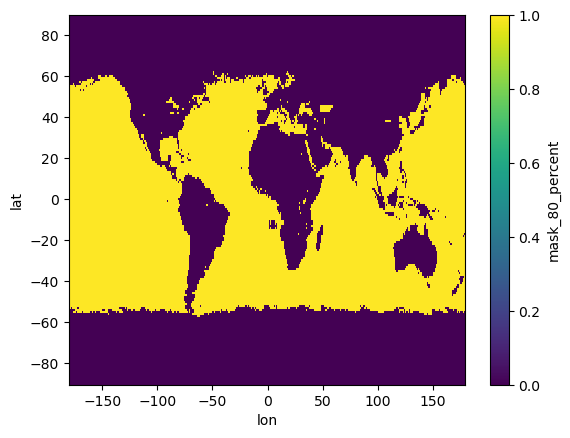

In [32]:

valid_data_count = (~cfg_var_sumChl.OBS_mask.isnull()).sum(dim='time')
total_time_steps = cfg_var_sumChl.OBS_ds['time'].size
threshold = 0.8
mask = (valid_data_count / total_time_steps) >= threshold
cfg_var_sumChl.OBS_ds['mask_80_percent'] = mask
cfg_var_sumChl.OBS_ds['mask_80_percent'].compute()
cfg_var_sumChl.OBS_ds['mask_80_percent'].plot.pcolormesh()


In [35]:
# observ-masked dataset
cfg_var_sumChl.ODA_ds_obs_masked=cfg_var_sumChl.ODA_ds.sel(time=slice("1998-01-01", "2020-12-31")) * cfg_var_sumChl.OBS_mask.values
cfg_var_sumChl.ODA_ds_obs_masked_yearly= cfg_var_sumChl.ODA_ds_obs_masked.groupby('time.year').mean(dim='time', skipna=True)

cfg_var_sumChl.ADA_ds_obs_masked=cfg_var_sumChl.ADA_ds.sel(time=slice("1998-01-01", "2020-12-31")) * cfg_var_sumChl.OBS_mask.values
cfg_var_sumChl.ADA_ds_obs_masked_yearly= cfg_var_sumChl.ADA_ds_obs_masked.groupby('time.year').mean(dim='time', skipna=True)

cfg_var_sumChl.LE_ds_obs_masked=cfg_var_sumChl.LE_ds.sel(time=slice("1998-01-01", "2020-12-31")) * cfg_var_sumChl.OBS_mask.values
cfg_var_sumChl.LE_ds_obs_masked_yearly= cfg_var_sumChl.LE_ds_obs_masked.groupby('time.year').mean(dim='time', skipna=True)

cfg_var_sumChl.HCST_ds_obs_masked=cfg_var_sumChl.HCST_ds.sel(iyear=slice("1997-01-01", "2020-12-31")).sel(lmonths=slice(1,12))
da_stacked = cfg_var_sumChl.HCST_ds_obs_masked.stack(time=("iyear","lmonths"))
da_stacked = da_stacked.reset_index("time")  # iyear, lmonths become coords
n_time = da_stacked.sizes["time"]  
da_stacked = da_stacked.assign_coords(time=cfg_var_sumChl.ODA_ds.sel(time=slice("1998-01-01", "2020-12-31")).time)
da_stacked = da_stacked.drop_vars(["iyear","lmonths"])
da_stacked=da_stacked * cfg_var_sumChl.OBS_mask
cfg_var_sumChl.HCST_ds_obs_masked_yearly= da_stacked.groupby('time.year').mean(dim='time', skipna=True)

In [36]:
# get rolling mean variables (Chl)
cfg_var_sumChl.OBS_ds_4yr = cfg_var_sumChl.OBS_ds_yearly.rolling(year=4, min_periods=4).mean()
obs_rolling_time_mean = cfg_var_sumChl.OBS_ds_yearly['year'].rolling(year=4, min_periods=4).mean()
cfg_var_sumChl.OBS_ds_4yr = cfg_var_sumChl.OBS_ds_4yr.assign_coords(year=obs_rolling_time_mean)
valid_index = np.where(~np.isnan(cfg_var_sumChl.OBS_ds_4yr['year']))[0]
cfg_var_sumChl.OBS_ds_4yr = cfg_var_sumChl.OBS_ds_4yr.isel(year=valid_index)

cfg_var_sumChl.ODA_ds_4yr = cfg_var_sumChl.ODA_ds_obs_masked_yearly.rolling(year=4, min_periods=4).mean()
obs_rolling_time_mean = cfg_var_sumChl.ODA_ds_obs_masked_yearly['year'].rolling(year=4, min_periods=4).mean()
cfg_var_sumChl.ODA_ds_4yr = cfg_var_sumChl.ODA_ds_4yr.assign_coords(year=obs_rolling_time_mean)
valid_index = np.where(~np.isnan(cfg_var_sumChl.ODA_ds_4yr['year']))[0]
cfg_var_sumChl.ODA_ds_4yr = cfg_var_sumChl.ODA_ds_4yr.isel(year=valid_index)

cfg_var_sumChl.ADA_ds_4yr = cfg_var_sumChl.ADA_ds_obs_masked_yearly.rolling(year=4, min_periods=4).mean()
obs_rolling_time_mean = cfg_var_sumChl.ADA_ds_obs_masked_yearly['year'].rolling(year=4, min_periods=4).mean()
cfg_var_sumChl.ADA_ds_4yr = cfg_var_sumChl.ADA_ds_4yr.assign_coords(year=obs_rolling_time_mean)
valid_index = np.where(~np.isnan(cfg_var_sumChl.ADA_ds_4yr['year']))[0]
cfg_var_sumChl.ADA_ds_4yr = cfg_var_sumChl.ADA_ds_4yr.isel(year=valid_index)

cfg_var_sumChl.LE_ds_4yr = cfg_var_sumChl.LE_ds_obs_masked_yearly.rolling(year=4, min_periods=4).mean()
obs_rolling_time_mean = cfg_var_sumChl.LE_ds_obs_masked_yearly['year'].rolling(year=4, min_periods=4).mean()
cfg_var_sumChl.LE_ds_4yr = cfg_var_sumChl.LE_ds_4yr.assign_coords(year=obs_rolling_time_mean)
valid_index = np.where(~np.isnan(cfg_var_sumChl.LE_ds_4yr['year']))[0]
cfg_var_sumChl.LE_ds_4yr = cfg_var_sumChl.LE_ds_4yr.isel(year=valid_index)

# Suppose:
#  hcst_da_ly25 has dims (ens_HCST=20, iyear=19, lmonths=48, lat=180, lon=360)
#  iyear in [1998..2016, etc.]
#  cfg_var_sumChl.OBS_mask has (time=276, lat=180, lon=360) spanning e.g. 1998-01..2020-12

hcst_da_ly25=cfg_var_sumChl.HCST_ds.sel(iyear=slice("1996-01-01", "2016-12-31"), lmonths=slice(13, 60))
hcst_da_ly25

final_list = []

for iy in range(1997, 2017):
    # 1) define the time offset for your obs_mask
    #    e.g. if iyear=1997 => mask time slice from 0..47
    #        if iyear=1998 => mask time slice from 12..59, etc.
    offset = (iy - 1997) * 12
    # slice 48 months
    obs_mask_iy = cfg_var_sumChl.OBS_mask.isel(time=slice(offset, offset + 48))

    # 2) pick matching iyear from hcst_da_ly25
    #    That means iCond = (iyear dimension equals this integer)
    #    Then select lmonths=0..47 as well, or rely on the original shape
    hcst_one_year = hcst_da_ly25.sel(iyear=iy)  # shape => (ens_HCST=20, lmonths=48, lat=180, lon=360)

    # 3) Align obs_mask_iy with your data’s lat/lon
    #    obs_mask_iy has dims (time=48, lat=180, lon=360)
    #    hcst_one_year has dims (lmonths=48, lat=180, lon=360)
    # Potentially rename obs_mask_iy dim "time"->"lmonths"
    obs_mask_iy = obs_mask_iy.rename(time="lmonths")
    obs_mask_iy['lmonths']=hcst_one_year['lmonths']
    
    # 4) Multiply them
    masked_data = hcst_one_year * obs_mask_iy

    # 5) (Optional) store them in a list or do partial assignment
    final_list.append(masked_data)

# If you want to combine them back along iyear dimension:
da_concat = xr.concat(final_list, dim="iyear")
da_concat["iyear"] = np.arange(1997,2017)  # or actual year array
cfg_var_sumChl.HCST_ds_4yr=da_concat.mean(dim='lmonths')
cfg_var_sumChl.HCST_ds_4yr=cfg_var_sumChl.HCST_ds_4yr.rename(iyear="year")
cfg_var_sumChl.HCST_ds_4yr['year']=cfg_var_sumChl.OBS_ds_4yr['year']

In [43]:
# get skills
corr_sumChl_OBS_LE = xr.corr(cfg_var_sumChl.OBS_ds_yearly, cfg_var_sumChl.LE_ds_obs_masked_yearly, dim='year').compute()
corr_sumChl_OBS_ODA = xr.corr(cfg_var_sumChl.OBS_ds_yearly, cfg_var_sumChl.ODA_ds_obs_masked_yearly, dim='year').compute()
corr_sumChl_OBS_ODA_diff = xr.corr(cfg_var_sumChl.OBS_ds_yearly, cfg_var_sumChl.ODA_ds_obs_masked_yearly-cfg_var_sumChl.LE_ds_obs_masked_yearly.mean(dim='ens_LE'), dim='year').compute()
corr_sumChl_OBS_ADA = xr.corr(cfg_var_sumChl.OBS_ds_yearly, cfg_var_sumChl.ADA_ds_obs_masked_yearly, dim='year').compute()
corr_sumChl_OBS_ADA_diff = xr.corr(cfg_var_sumChl.OBS_ds_yearly, cfg_var_sumChl.ADA_ds_obs_masked_yearly-cfg_var_sumChl.ODA_ds_obs_masked_yearly.mean(dim='ens_ODA'), dim='year').compute()
corr_sumChl_OBS_HCST = xr.corr(cfg_var_sumChl.OBS_ds_yearly, cfg_var_sumChl.HCST_ds_obs_masked_yearly, dim='year').compute()

# wrong way to get (collected ly2~5 from different initialized year hindcast set)
# corr_OBS_HCST_ly25 = xr.corr(cfg_var_sumChl.OBS_ds_yearly, cfg_var_sumChl.HCST_ds_obs_masked_yearly.isel(ly=slice(1,5)).mean(dim='ly'), dim='year').compute()

corr_sumChl_OBS_HCST_ly25 = xr.corr(cfg_var_sumChl.OBS_ds_4yr, cfg_var_sumChl.HCST_ds_4yr, dim='year').compute()
corr_OBS_LE_ly25 = xr.corr(cfg_var_sumChl.OBS_ds_4yr, cfg_var_sumChl.LE_ds_4yr, dim='year').compute()
corr_sumChl_OBS_ODA_ly25 = xr.corr(cfg_var_sumChl.OBS_ds_4yr, cfg_var_sumChl.ODA_ds_4yr, dim='year').compute()

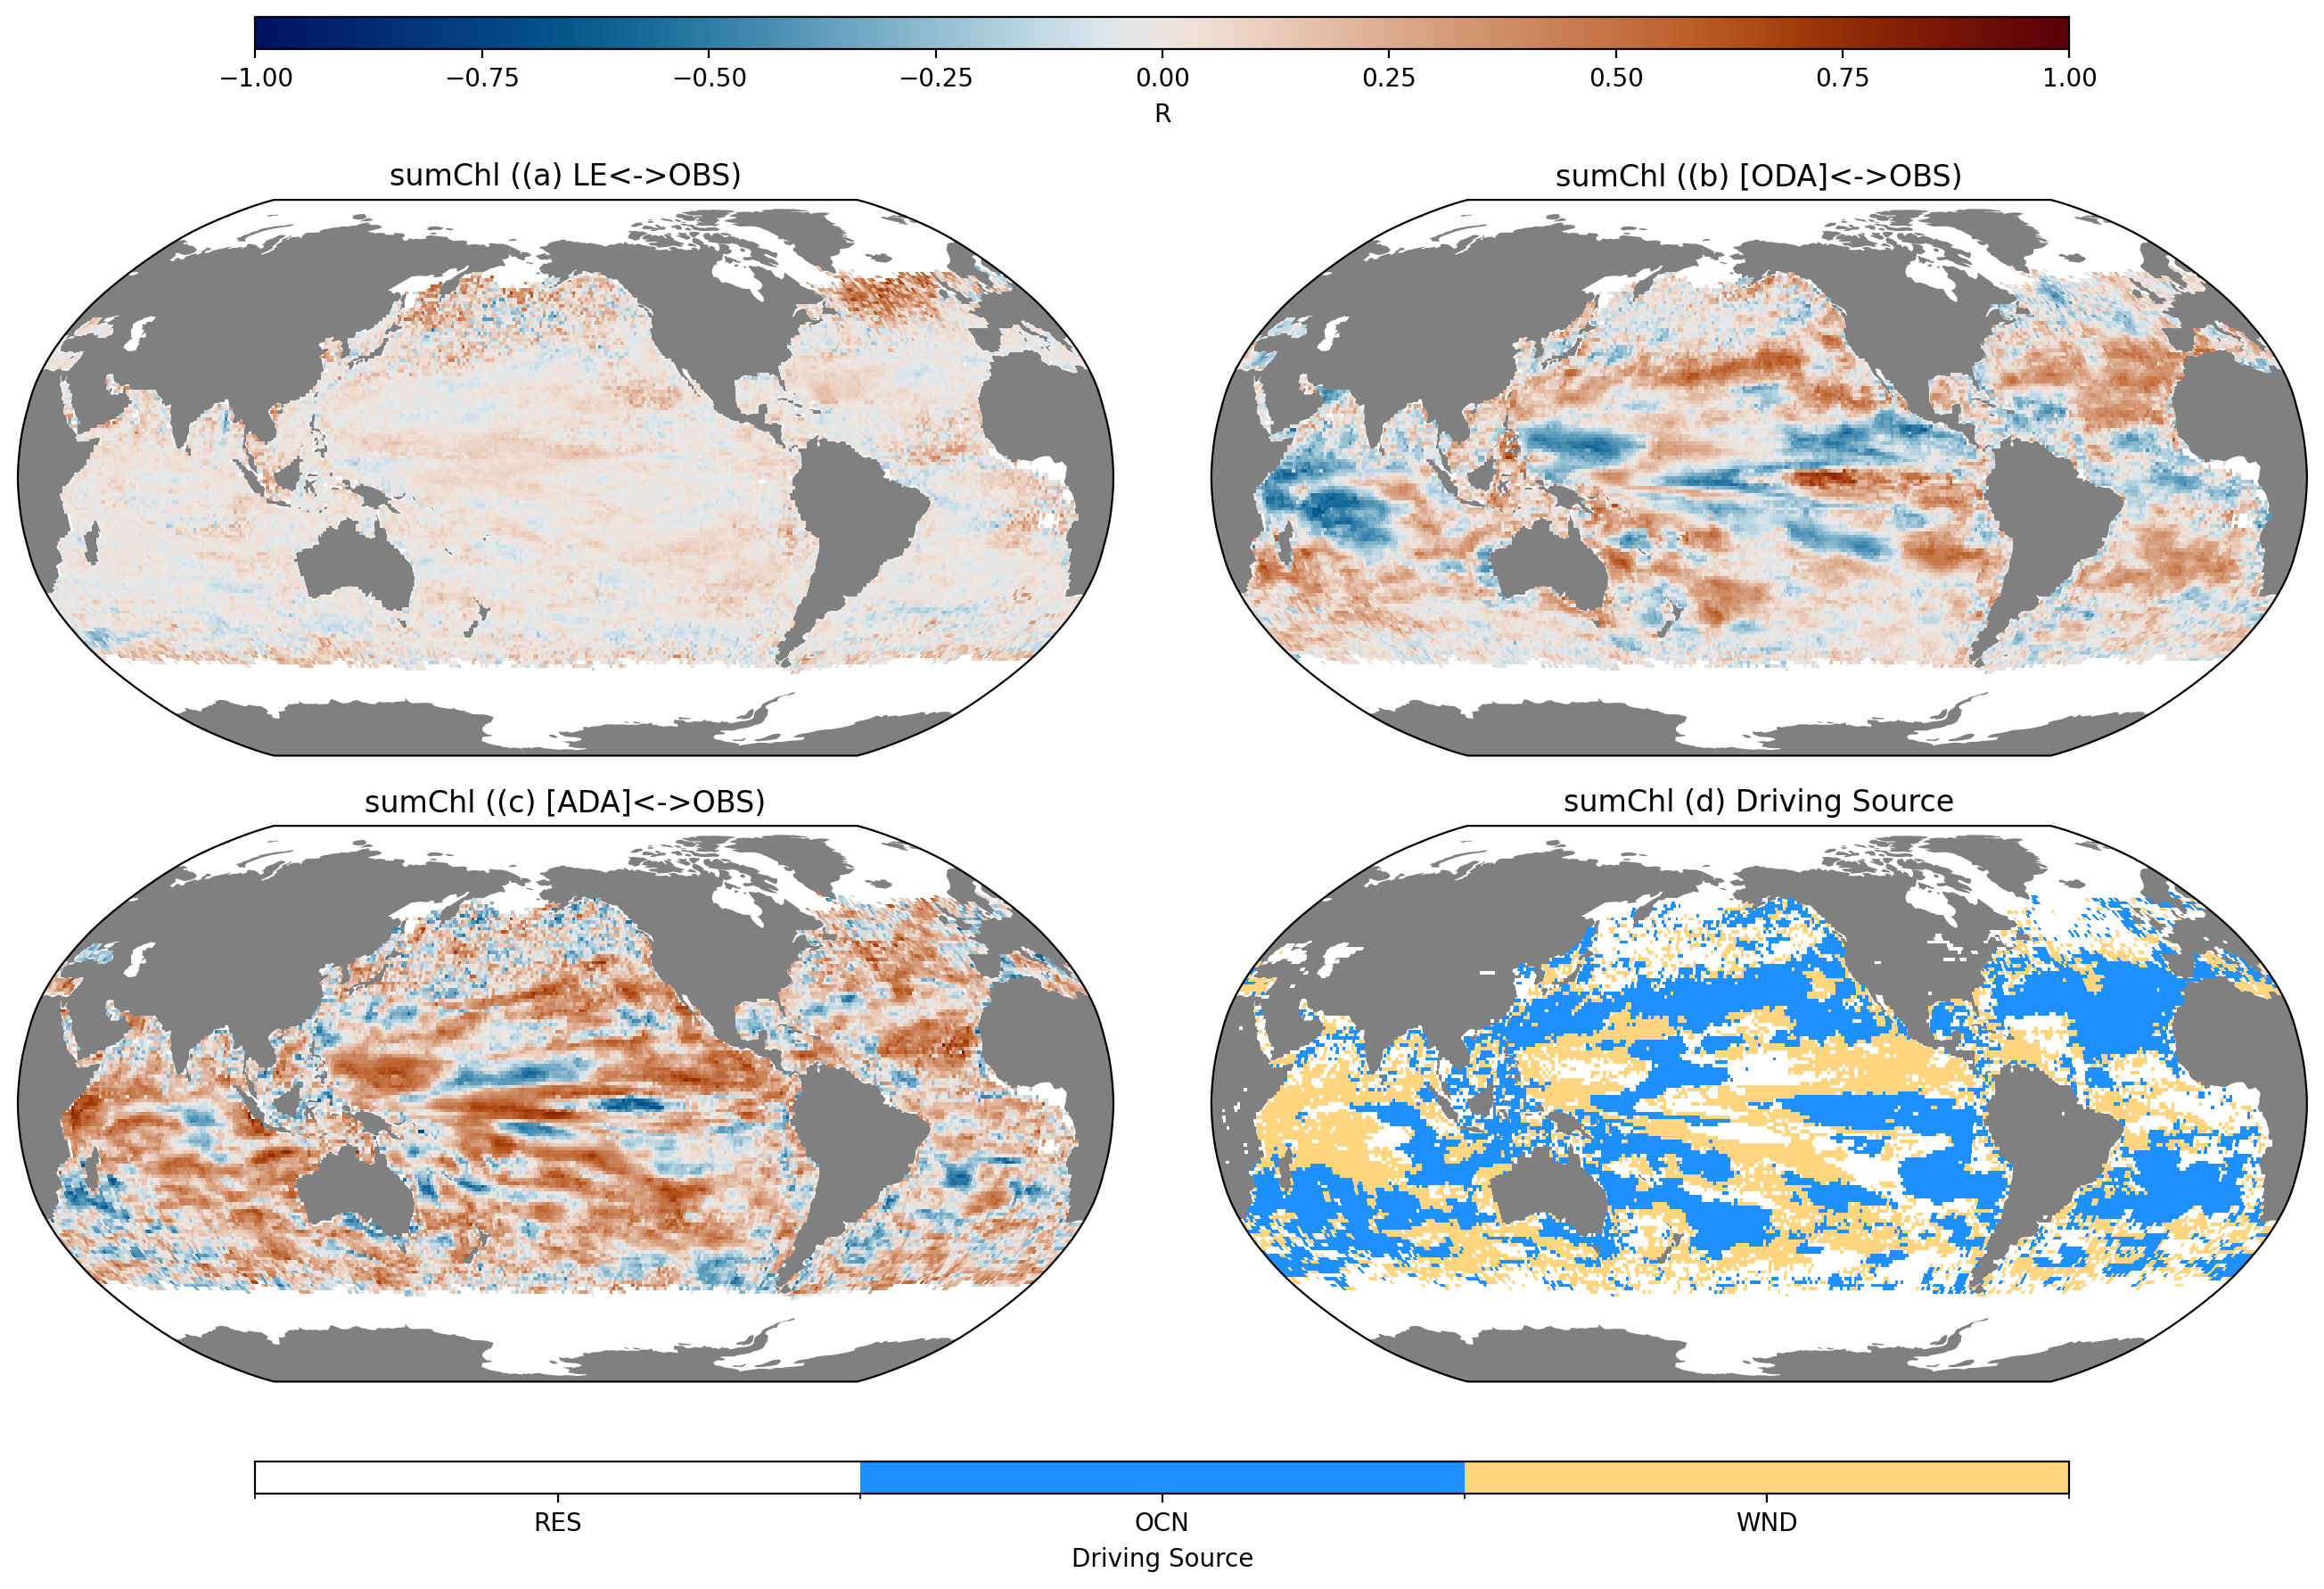

In [44]:
from scipy.stats import ttest_1samp

land_feature = cfeature.LAND.with_scale('110m')


varn=cfg_var_sumChl.var
# plot for LE

projection = ccrs.Robinson(central_longitude=205)
cbar_kwargs={'orientation':'horizontal','pad':0.05,'shrink':0.7, 'label':' R ', 'aspect':33, 'extend': 'both'}

# 서브플롯 생성
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(18.5, 9), 
             dpi=200, facecolor='w', edgecolor='k', subplot_kw={'projection': projection})

data_array = corr_sumChl_OBS_LE.median(dim='ens_LE')
data_array = data_array.where(cfg_var_sumChl.OBS_ds['mask_80_percent'] == 1, np.NaN)
plt1=data_array.plot.pcolormesh(ax=axes[0, 0], transform=ccrs.PlateCarree(), vmax=1, vmin=-1,cmap=cm.vik, add_colorbar=False)
axes[0, 0].set_title(f'{varn} ((a) LE<->OBS)')
axes[0, 0].add_feature(land_feature, facecolor='gray', edgecolor='none')
    
# plot for (ODA)
data_array = corr_sumChl_OBS_ODA_diff.median(dim='ens_ODA')
data_array = data_array.where(cfg_var_sumChl.OBS_ds['mask_80_percent'] == 1, np.NaN)
plt1=data_array.plot.pcolormesh(ax=axes[0, 1], transform=ccrs.PlateCarree(), vmax=1, vmin=-1,cmap=cm.vik, add_colorbar=False)
axes[0, 1].set_title(f'{varn} ((b) [ODA]<->OBS)')
axes[0, 1].add_feature(land_feature, facecolor='gray', edgecolor='none')

# plot for (ADA)
data_array = corr_sumChl_OBS_ADA_diff.median(dim='ens_ADA')
data_array = data_array.where(cfg_var_sumChl.OBS_ds['mask_80_percent'] == 1, np.NaN)
plt1=data_array.plot.pcolormesh(ax=axes[1, 0], transform=ccrs.PlateCarree(), vmax=1, vmin=-1,cmap=cm.vik, add_colorbar=False)
axes[1, 0].set_title(f'{varn} ((c) [ADA]<->OBS)')
axes[1, 0].add_feature(land_feature, facecolor='gray', edgecolor='none')


# plot for (WND ODA mask)
alpha = 0.10

t_stat_LE, p_values_LE = ttest_1samp(corr_sumChl_OBS_LE, 0, axis=2)
ds_LE = corr_sumChl_OBS_LE.median(dim='ens_LE').where(p_values_LE < alpha)

t_stat_ODA, p_values_ODA = ttest_1samp(corr_sumChl_OBS_ODA_diff, 0, axis=2)
ds_ODA = corr_sumChl_OBS_ODA_diff.median(dim='ens_ODA').where(p_values_ODA < alpha)

t_stat_ADA, p_values_ADA = ttest_1samp(corr_sumChl_OBS_ADA_diff, 0, axis=2)
ds_ADA = corr_sumChl_OBS_ADA_diff.median(dim='ens_ADA').where(p_values_ADA < alpha)

threshold = 0
mask_LE = ds_LE > threshold
mask_ODA = ds_ODA > threshold
mask_ADA = ds_ADA > threshold

ds_all = xr.Dataset(
    data_vars=dict(
        colors=(('lat', 'lon'), np.full(ds_LE.shape, 0.33))  # 'colors'라는 변수 추가
    ),
    coords=dict(
        lat=(('lat'), mask_LE.lat.data),  # DataArray의 .data 사용
        lon=(('lon'), mask_LE.lon.data)     # DataArray의 .data 사용
    )
)

# ds_all['colors'] = xr.where(ds_grid.REGION_MASK == 0, 0.0, ds_all['colors']) # 흰색
ds_all['colors'] = xr.where(mask_LE.isnull(), 0.0, ds_all['colors']) # 흰색
ds_all['colors'] = xr.where(mask_ODA & ~mask_ADA, 0.5, ds_all['colors'])  # 파란색
ds_all['colors'] = xr.where(mask_ODA & mask_ADA, 0.5, ds_all['colors'])  # 파란색
ds_all['colors'] = xr.where(~mask_ODA & mask_ADA, 1.0, ds_all['colors'])  # 주황색
ds_all['colors'] = xr.where(mask_LE & ~mask_ODA, 0, ds_all['colors'])  # 주황색

colors_custom = ['#FFFFFF',  # 흰색 (White)
          '#1E90FF',  # Dodger blue (ODA)
          '#FFD580']  # 파스텔 오렌지 (WND) 

ds_all = ds_all.where(cfg_var_sumChl.OBS_ds['mask_80_percent'] == 1, np.NaN)

# Define boundaries so each color covers exactly one bin:
bounds = [0, 0.5, 1, 1.5]  # or [0, 0.33, 0.66, 1] if your data is in [0..1]
cmap = mcolors.ListedColormap(colors_custom)
norm = mcolors.BoundaryNorm(bounds, cmap.N)

plt4=ds_all['colors'].plot.pcolormesh(ax=axes[1, 1], transform=ccrs.PlateCarree(), cmap=mcolors.ListedColormap(colors_custom), add_colorbar=False, norm=norm)
axes[1, 1].set_title(f'{varn} (d) Driving Source')
axes[1, 1].add_feature(land_feature, facecolor='gray', edgecolor='none')


# (a), (b), (c) 서브플롯에 대해 위쪽에 큰 컬러바 추가
cbar_a_c = fig.add_axes([0.1, 0.95, 0.55, 0.02])  # [left, bottom, width, height] 비율로 컬러바 위치와 크기 설정
cbar1 = plt.colorbar(plt1, cax=cbar_a_c, orientation='horizontal')
cbar1.set_label('R')

# (d) 서브플롯에 대해 아래쪽에 큰 컬러바 추가
cbar_d = fig.add_axes([0.1, 0.05, 0.55, 0.02])  # [left, bottom, width, height] 비율로 컬러바 위치와 크기 설정
# cbar2= plt.colorbar(plt4, cax=cbar_d, orientation='horizontal')
cbar2 = plt.colorbar(plt4, cax=cbar_d, orientation='horizontal',
                     boundaries=bounds, ticks=[0.25, 0.75, 1.25])
cbar2.set_label('Driving Source')
# num_colors = len(colors_custom)
# tick_locs = np.linspace(0.5 / num_colors, 1 - 0.5 / num_colors, num_colors)
# tick_locs = np.linspace(0.25, 0.75, 3)
# cbar2.set_ticks(tick_locs)  # 눈금 설정
cbar2.set_ticklabels(['RES', 'OCN', 'WND'])  # 눈금 레이블 설정

plt.rcParams.update({'font.size': 12})

# 전체 레이아웃 조정
plt.tight_layout(rect=[0, 0.1, 0.75, 0.9])  # 상단과 하단의 레이아웃 여백을 맞추기 위해 rect 설정
# plt.tight_layout()
plt.savefig(savefilepath +"/BGC_Pred_Fig1.tif", format='tiff', dpi=150, bbox_inches='tight')
plt.show()



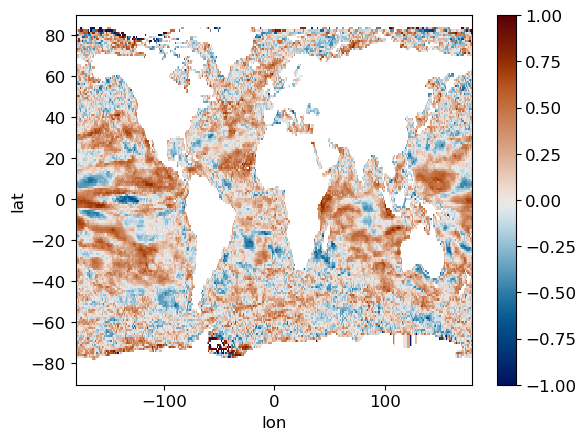

In [45]:
# check correlations
# corr_OBS_ODA.median(dim='ens_ODA').plot.pcolormesh(cmap=cm.vik, vmin=-1, vmax=1)
# corr_OBS_ODA_ly25.median(dim='ens_ODA').plot.pcolormesh(cmap=cm.vik)
# corr_OBS_ODA_diff.median(dim='ens_ODA').plot.pcolormesh(cmap=cm.vik)
# corr_OBS_ODA.median(dim='ens_ODA').plot.pcolormesh(cmap=cm.vik)
corr_OBS_ADA_diff.median(dim='ens_ADA').plot.pcolormesh(cmap=cm.vik)
# corr_OBS_ADA.median(dim='ens_ADA').plot.pcolormesh()
# corr_OBS_HCST.isel(ly=0).median(dim='ens_HCST').plot.pcolormesh(cmap=cm.vik, vmin=-1, vmax=1)
# corr_OBS_HCST_ly25.median(dim='ens_HCST').plot.pcolormesh(cmap=cm.vik, vmin=-1, vmax=1)
# corr_OBS_LE.median(dim='ens_LE').plot.pcolormesh()

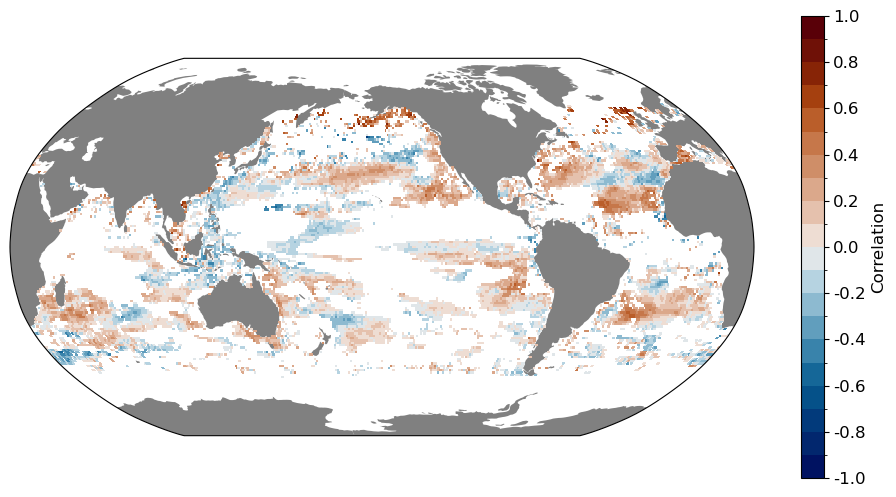

In [46]:
# example ly2_5 skill

fig, axes = plt.subplots(nrows=1, ncols=1, 
                         figsize=(12,6),
                         facecolor='w', 
                         edgecolor='k', 
                         subplot_kw={'projection': projection})

data_array = corr_OBS_HCST_ly25.median(dim='ens_HCST')
data_array = data_array.where(mask_ODA == 1, np.NaN)
data_array = data_array.where(cfg_var_sumChl.OBS_ds['mask_80_percent'] == 1, np.NaN)

N = 19
t_value = data_array * np.sqrt((N - 2) / (1 - data_array**2)) 
p_value = 2 * (1 - t.cdf(abs(t_value), df=N - 2)) 
# data_array = data_array.where(p_value < 0.34, np.NaN)

levels = np.linspace(-1, 1, 21)
ticklevels = np.linspace(-1, 1, 11).round(2)

# levels = np.linspace(-0.5, 0.5, 11)
# ticklevels = np.linspace(-0.5, 0.5, 11).round(2)

plt1 = data_array.plot.pcolormesh(
    ax=axes, 
    transform=ccrs.PlateCarree(),
    cmap=cm.vik, 
    vmin=-0.1, 
    vmax=0.1,
    levels=levels,        # <--- discrete intervals
    add_colorbar=False    # We will create our own colorbar below
)

axes.add_feature(land_feature, facecolor='gray', edgecolor='none')

# Now make a colorbar with the exact ticks you want
cbar = plt.colorbar(plt1, ax=axes)
cbar.set_ticks(ticklevels)
cbar.set_ticklabels(ticklevels)
cbar.set_label('Correlation')

plt.show()

In [47]:
# critical r with alpha=0.1, alpha=0.34
N = 19
alpha = 0.34  # two-sided, so alpha/2 = 0.05
df = N - 2

# 1) Find t_crit for a two-sided test at alpha=0.1
t_crit = t.ppf(1 - alpha/2, df)  # e.g., ppf(0.95) for the upper 5% tail

# 2) Solve for the correlation threshold
rho_crit = np.sqrt(t_crit**2 / ((N - 2) + t_crit**2))
print(f"N={N}, alpha={alpha}, df={df}")
print(f"t_crit = {t_crit:.3f}")
print(f"Correlation threshold ≈ ±{rho_crit:.3f}")

N=19, alpha=0.34, df=17
t_crit = 0.982
Correlation threshold ≈ ±0.232


# NPP (Total, diat, sp, diaz)

In [48]:
# set NPP
cfg_var_photoC_TOT_zint_100m=CESM2_config()
cfg_var_photoC_TOT_zint_100m.year_s=1960
cfg_var_photoC_TOT_zint_100m.year_e=2020

cfg_var_photoC_TOT_zint_100m.setvar('photoC_TOT_zint_100m')

In [49]:
# Read LE dataset (NPP)

start_time = time.time()

cfg_var_photoC_TOT_zint_100m.LE_path_load(cfg_var_photoC_TOT_zint_100m.var)
cfg_var_photoC_TOT_zint_100m.LE_ds = xr.open_mfdataset(cfg_var_photoC_TOT_zint_100m.LE_file_list[0], 
                       chunks={'time': 12}, 
                       combine='nested', 
                       concat_dim=[[*cfg_var_photoC_TOT_zint_100m.LE_ensembles], 'time'], 
                       parallel=True,
                       preprocess=lambda ds: process_coords_bgc_2d(ds, start_date, end_date, 'photoC_TOT_zint_100m'),
                       decode_cf=True, 
                       decode_times=True)      


cfg_var_photoC_TOT_zint_100m.LE_ds = cfg_var_photoC_TOT_zint_100m.LE_ds.rename({"concat_dim": "ens_LE"})
cfg_var_photoC_TOT_zint_100m.LE_ds=cfg_var_photoC_TOT_zint_100m.LE_ds.compute()

end_time = time.time()
elapsed_time = end_time - start_time
print('elasped time for reading LE: ' + str(elapsed_time))

elasped time for reading LE: 116.60773062705994


In [50]:
# Read ODA dataset (NPP)

cfg_var_photoC_TOT_zint_100m.ODA_ds = []

start_time = time.time()

cfg_var_photoC_TOT_zint_100m.ODA_path_load(cfg_var_photoC_TOT_zint_100m.var)

for imem in range(0, len(cfg_var_photoC_TOT_zint_100m.ODA_file_list[0])):
    photoC_TOT_zint_100m_ODA_ds_tmp = xr.open_mfdataset(cfg_var_photoC_TOT_zint_100m.ODA_file_list[0][imem], 
                           chunks={'time': 1}, 
                           combine='nested',
                           parallel=True,
                           preprocess=lambda ds: process_coords_bgc_2d(ds, start_date, end_date, 'photoC_TOT_zint_100m'),
                           decode_cf=True, 
                           decode_times=True)


    ODA_ds_a= []
    ODA_ds_a.append(photoC_TOT_zint_100m_ODA_ds_tmp)
    ODA_ds_xr = xr.concat(ODA_ds_a, dim='time')
    ODA_ds_xr = ODA_ds_xr.expand_dims({'ens_ODA': 1})
    cfg_var_photoC_TOT_zint_100m.ODA_ds.append(ODA_ds_xr)

    end_time = time.time()
    elapsed_time = end_time - start_time
    print('elasped time for reading ODA, ' + str(imem) + ': ' + str(elapsed_time))

cfg_var_photoC_TOT_zint_100m.ODA_ds = xr.concat(cfg_var_photoC_TOT_zint_100m.ODA_ds, dim='ens_ODA')
cfg_var_photoC_TOT_zint_100m.ODA_ds['ens_ODA']=range(0, len(cfg_var_photoC_TOT_zint_100m.ODA_file_list[0]))


elasped time for reading ODA, 0: 10.862346410751343
elasped time for reading ODA, 1: 20.038567543029785
elasped time for reading ODA, 2: 28.61125135421753
elasped time for reading ODA, 3: 37.74790620803833
elasped time for reading ODA, 4: 47.12745022773743
elasped time for reading ODA, 5: 56.08651399612427
elasped time for reading ODA, 6: 64.96585869789124
elasped time for reading ODA, 7: 73.86541318893433
elasped time for reading ODA, 8: 82.8770124912262
elasped time for reading ODA, 9: 92.24898886680603
elasped time for reading ODA, 10: 100.87084579467773
elasped time for reading ODA, 11: 109.54346489906311
elasped time for reading ODA, 12: 118.3410153388977
elasped time for reading ODA, 13: 127.21292090415955
elasped time for reading ODA, 14: 136.19179248809814
elasped time for reading ODA, 15: 145.20122408866882
elasped time for reading ODA, 16: 154.07113218307495
elasped time for reading ODA, 17: 163.6990122795105
elasped time for reading ODA, 18: 173.393869638443
elasped time for

In [51]:
#Read ADA dataset (NPP)

start_time = time.time()

cfg_var_photoC_TOT_zint_100m.ADA_path_load(cfg_var_photoC_TOT_zint_100m.var)
cfg_var_photoC_TOT_zint_100m.ADA_ds = xr.open_mfdataset(cfg_var_photoC_TOT_zint_100m.ADA_file_list[0], 
                       chunks={'time': 12}, 
                       combine='nested',
                       concat_dim=[[*cfg_var_photoC_TOT_zint_100m.ADA_ensembles], 'time'], 
                       parallel=True,
                       preprocess=lambda ds: process_coords_bgc_2d(ds, start_date, end_date, 'photoC_TOT_zint_100m'),
                       decode_cf=True, 
                       decode_times=True)      


cfg_var_photoC_TOT_zint_100m.ADA_ds = cfg_var_photoC_TOT_zint_100m.ADA_ds.rename({"concat_dim": "ens_ADA"})
cfg_var_photoC_TOT_zint_100m.ADA_ds=cfg_var_photoC_TOT_zint_100m.ADA_ds.compute()

end_time = time.time()
elapsed_time = end_time - start_time
print('elasped time for reading ADA: ' + str(elapsed_time))

elasped time for reading ADA: 24.585737228393555


In [54]:
# Read HCST dataset (NPP)

cfg_var_photoC_TOT_zint_100m.HCST_ds = []

start_time = time.time()

cfg_var_photoC_TOT_zint_100m.HCST_path_load(cfg_var_photoC_TOT_zint_100m.var)

for iyear in range(0, len(cfg_var_photoC_TOT_zint_100m.HCST_file_list)):
    photoC_TOT_zint_100m_HCST_ds_tmp = xr.open_mfdataset(cfg_var_photoC_TOT_zint_100m.HCST_file_list[iyear], 
                           chunks={'time': 1}, 
                           combine='nested',
                           concat_dim=[[*cfg_var_photoC_TOT_zint_100m.HCST_ensembles], 'time'], 
                           parallel=True,
                           preprocess=lambda ds: process_coords_bgc_2d_hcst(ds, start_date, end_date, 'photoC_TOT_zint_100m'),
                           decode_cf=True, 
                           decode_times=True)

    photoC_TOT_zint_100m_HCST_ds_tmp = photoC_TOT_zint_100m_HCST_ds_tmp.rename({"time": "lmonths"})
    photoC_TOT_zint_100m_HCST_ds_tmp['lmonths']=range(1,61)
    HCST_ds_a= []
    HCST_ds_a.append(photoC_TOT_zint_100m_HCST_ds_tmp)
    HCST_ds_xr = xr.concat(HCST_ds_a, dim='lmonths')
    HCST_ds_xr = HCST_ds_xr.expand_dims({'iyear': 1})
    cfg_var_photoC_TOT_zint_100m.HCST_ds.append(HCST_ds_xr)

    end_time = time.time()
    elapsed_time = end_time - start_time
    print('elasped time for reading HCST Chl, ' + str(iyear) + ': ' + str(elapsed_time))

cfg_var_photoC_TOT_zint_100m.HCST_ds = xr.concat(cfg_var_photoC_TOT_zint_100m.HCST_ds, dim='iyear')
cfg_var_photoC_TOT_zint_100m.HCST_ds = cfg_var_photoC_TOT_zint_100m.HCST_ds.rename({"concat_dim": "ens_HCST"})
cfg_var_photoC_TOT_zint_100m.HCST_ds['ens_HCST']=range(0, len(cfg_var_photoC_TOT_zint_100m.HCST_file_list[0]))
cfg_var_photoC_TOT_zint_100m.HCST_ds['iyear']=range(cfg_var_photoC_TOT_zint_100m.year_s, cfg_var_photoC_TOT_zint_100m.year_e+1)
    
 


elasped time for reading HCST Chl, 0: 41.01848602294922
elasped time for reading HCST Chl, 1: 46.21767783164978
elasped time for reading HCST Chl, 2: 51.936392307281494
elasped time for reading HCST Chl, 3: 57.3533730506897
elasped time for reading HCST Chl, 4: 62.707722425460815
elasped time for reading HCST Chl, 5: 68.81931567192078
elasped time for reading HCST Chl, 6: 74.39991974830627
elasped time for reading HCST Chl, 7: 80.74509596824646
elasped time for reading HCST Chl, 8: 86.42048192024231
elasped time for reading HCST Chl, 9: 92.47394132614136
elasped time for reading HCST Chl, 10: 98.00487041473389
elasped time for reading HCST Chl, 11: 103.57986688613892
elasped time for reading HCST Chl, 12: 108.81701445579529
elasped time for reading HCST Chl, 13: 114.37558579444885
elasped time for reading HCST Chl, 14: 120.714608669281
elasped time for reading HCST Chl, 15: 126.67755508422852
elasped time for reading HCST Chl, 16: 132.5428183078766
elasped time for reading HCST Chl, 17

In [55]:
# Observation (NPP)

# get observation filelist
cfg_var_photoC_TOT_zint_100m.OBS_rootdir='/mnt/lustre/proj/kimyy/Observation';
cfg_var_photoC_TOT_zint_100m.OBS_var='PP'
cfg_var_photoC_TOT_zint_100m.OBS_dataname='CMEMS'
cfg_var_photoC_TOT_zint_100m.OBS_mondir= cfg_var_photoC_TOT_zint_100m.OBS_rootdir + '/' +  cfg_var_photoC_TOT_zint_100m.OBS_dataname + '/GlobColour/' + 'monthly_reg_pop' + '/' + cfg_var_photoC_TOT_zint_100m.OBS_var
OBS_file_list=[]
OBS_ens_files=[]
OBS_files=[]    
command='ls ' + cfg_var_photoC_TOT_zint_100m.OBS_mondir + '/*reg_*.nc'
# print(command)
OBS_files_raw = subprocess.check_output(command, shell=True, text=True)
OBS_files= [entry for entry in OBS_files_raw.split('\n') if entry]
OBS_files = sorted(OBS_files)
# Filter the files based on your criteria
OBS_filtered_files = []
for fname in OBS_files:
    # print(fname)  # Debugging: print each file name
    match1 = re_mod.search(r'.(\d{4})', fname)
    # Ensure the regex matches and then check the year range
    if match1:
        year1 = int(match1.group(1))
        if year1 >= cfg_var_photoC_TOT_zint_100m.year_s and year1 <= cfg_var_photoC_TOT_zint_100m.year_e:
            fpath= fname
            # print(fpath)
            OBS_filtered_files.append(fpath)
OBS_ens_files.append(OBS_filtered_files)
OBS_file_list.append(OBS_ens_files)
cfg_var_photoC_TOT_zint_100m.OBS_file_list=OBS_file_list


# Read Observation dataset (Chls)
start_time = time.time()

cfg_var_photoC_TOT_zint_100m.OBS_ds = xr.open_mfdataset(cfg_var_photoC_TOT_zint_100m.OBS_file_list[0][0], 
                       chunks={'time': 12}, 
                       parallel=True,
                       decode_cf=True, 
                       decode_times=True,)
cfg_var_photoC_TOT_zint_100m.OBS_ds = cfg_var_photoC_TOT_zint_100m.OBS_ds.rename({cfg_var_photoC_TOT_zint_100m.OBS_var: cfg_var_photoC_TOT_zint_100m.var})

cfg_var_photoC_TOT_zint_100m.OBS_ds = cfg_var_photoC_TOT_zint_100m.OBS_ds[cfg_var_photoC_TOT_zint_100m.var].utils.regrid()

if cfg_var_photoC_TOT_zint_100m.var=='photoC_TOT_zint_100m':
    cfg_var_photoC_TOT_zint_100m.OBS_ds=cfg_var_photoC_TOT_zint_100m.OBS_ds.assign_coords(time=cfg_var_photoC_TOT_zint_100m.OBS_ds.sel(time=slice("1998-01-01", "2020-12-31")).time) #1993~2020
elif cfg_var_photoC_TOT_100m.var=='photoC_TOT_100m':
    cfg_var_photoC_TOT_100m.OBS_ds=cfg_var_photoC_TOT_100m.OBS_ds.assign_coords(time=cfg_var_photoC_TOT_100m.OBS_ds.sel(time=slice("1999-01-01", "2020-12-31")).time) #1999~2020

cfg_var_photoC_TOT_zint_100m.OBS_ds = cfg_var_photoC_TOT_zint_100m.OBS_ds.assign_coords(time=cfg_var_photoC_TOT_zint_100m.ODA_ds.sel(time=slice("1998-01-01", "2020-12-31")).time)

cfg_var_photoC_TOT_zint_100m.OBS_mask=cfg_var_photoC_TOT_zint_100m.OBS_ds/cfg_var_photoC_TOT_zint_100m.OBS_ds

cfg_var_photoC_TOT_zint_100m.OBS_ds_yearly = cfg_var_photoC_TOT_zint_100m.OBS_ds.groupby('time.year').mean(dim='time', skipna=True)


end_time = time.time()
elapsed_time = end_time - start_time
print('elasped time for reading OBS: ' + str(elapsed_time))



elasped time for reading OBS: 31.097689867019653


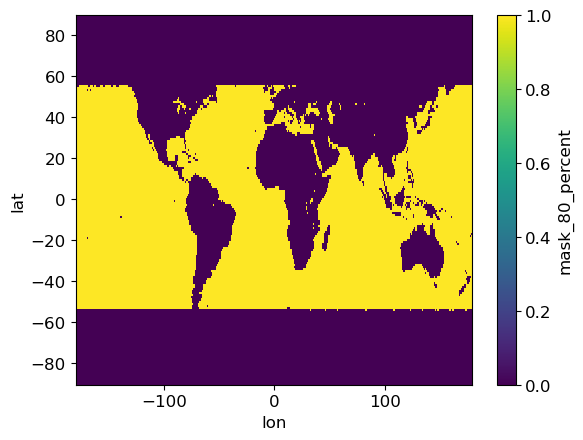

In [57]:
# mask_80percent, NPP
valid_data_count = (~cfg_var_photoC_TOT_zint_100m.OBS_mask.isnull()).sum(dim='time')
total_time_steps = cfg_var_photoC_TOT_zint_100m.OBS_ds['time'].size
threshold = 0.8
mask = (valid_data_count / total_time_steps) >= threshold
cfg_var_photoC_TOT_zint_100m.OBS_ds['mask_80_percent'] = mask
cfg_var_photoC_TOT_zint_100m.OBS_ds['mask_80_percent'].compute()
cfg_var_photoC_TOT_zint_100m.OBS_ds['mask_80_percent'].plot.pcolormesh()

In [58]:
# observ-masked dataset (NPP)
cfg_var_photoC_TOT_zint_100m.ODA_ds_obs_masked=cfg_var_photoC_TOT_zint_100m.ODA_ds.sel(time=slice("1998-01-01", "2020-12-31")) * cfg_var_photoC_TOT_zint_100m.OBS_mask.values
cfg_var_photoC_TOT_zint_100m.ODA_ds_obs_masked_yearly= cfg_var_photoC_TOT_zint_100m.ODA_ds_obs_masked.groupby('time.year').mean(dim='time', skipna=True)

cfg_var_photoC_TOT_zint_100m.ADA_ds_obs_masked=cfg_var_photoC_TOT_zint_100m.ADA_ds.sel(time=slice("1998-01-01", "2020-12-31")) * cfg_var_photoC_TOT_zint_100m.OBS_mask.values
cfg_var_photoC_TOT_zint_100m.ADA_ds_obs_masked_yearly= cfg_var_photoC_TOT_zint_100m.ADA_ds_obs_masked.groupby('time.year').mean(dim='time', skipna=True)

cfg_var_photoC_TOT_zint_100m.LE_ds_obs_masked=cfg_var_photoC_TOT_zint_100m.LE_ds.sel(time=slice("1998-01-01", "2020-12-31")) * cfg_var_photoC_TOT_zint_100m.OBS_mask.values
cfg_var_photoC_TOT_zint_100m.LE_ds_obs_masked_yearly= cfg_var_photoC_TOT_zint_100m.LE_ds_obs_masked.groupby('time.year').mean(dim='time', skipna=True)

cfg_var_photoC_TOT_zint_100m.HCST_ds_obs_masked=cfg_var_photoC_TOT_zint_100m.HCST_ds.sel(iyear=slice("1997-01-01", "2020-12-31")).sel(lmonths=slice(1,12))
da_stacked = cfg_var_photoC_TOT_zint_100m.HCST_ds_obs_masked.stack(time=("iyear","lmonths"))
da_stacked = da_stacked.reset_index("time")  # iyear, lmonths become coords
n_time = da_stacked.sizes["time"]  
da_stacked = da_stacked.assign_coords(time=cfg_var_photoC_TOT_zint_100m.ODA_ds.sel(time=slice("1998-01-01", "2020-12-31")).time)
da_stacked = da_stacked.drop_vars(["iyear","lmonths"])
da_stacked=da_stacked * cfg_var_photoC_TOT_zint_100m.OBS_mask
cfg_var_photoC_TOT_zint_100m.HCST_ds_obs_masked_yearly= da_stacked.groupby('time.year').mean(dim='time', skipna=True)

In [59]:
# get rolling mean variables (NPP)
cfg_var_photoC_TOT_zint_100m.OBS_ds_4yr = cfg_var_photoC_TOT_zint_100m.OBS_ds_yearly.rolling(year=4, min_periods=4).mean()
obs_rolling_time_mean = cfg_var_photoC_TOT_zint_100m.OBS_ds_yearly['year'].rolling(year=4, min_periods=4).mean()
cfg_var_photoC_TOT_zint_100m.OBS_ds_4yr = cfg_var_photoC_TOT_zint_100m.OBS_ds_4yr.assign_coords(year=obs_rolling_time_mean)
valid_index = np.where(~np.isnan(cfg_var_photoC_TOT_zint_100m.OBS_ds_4yr['year']))[0]
cfg_var_photoC_TOT_zint_100m.OBS_ds_4yr = cfg_var_photoC_TOT_zint_100m.OBS_ds_4yr.isel(year=valid_index)

cfg_var_photoC_TOT_zint_100m.ODA_ds_4yr = cfg_var_photoC_TOT_zint_100m.ODA_ds_obs_masked_yearly.rolling(year=4, min_periods=4).mean()
obs_rolling_time_mean = cfg_var_photoC_TOT_zint_100m.ODA_ds_obs_masked_yearly['year'].rolling(year=4, min_periods=4).mean()
cfg_var_photoC_TOT_zint_100m.ODA_ds_4yr = cfg_var_photoC_TOT_zint_100m.ODA_ds_4yr.assign_coords(year=obs_rolling_time_mean)
valid_index = np.where(~np.isnan(cfg_var_photoC_TOT_zint_100m.ODA_ds_4yr['year']))[0]
cfg_var_photoC_TOT_zint_100m.ODA_ds_4yr = cfg_var_photoC_TOT_zint_100m.ODA_ds_4yr.isel(year=valid_index)

cfg_var_photoC_TOT_zint_100m.ADA_ds_4yr = cfg_var_photoC_TOT_zint_100m.ADA_ds_obs_masked_yearly.rolling(year=4, min_periods=4).mean()
obs_rolling_time_mean = cfg_var_photoC_TOT_zint_100m.ADA_ds_obs_masked_yearly['year'].rolling(year=4, min_periods=4).mean()
cfg_var_photoC_TOT_zint_100m.ADA_ds_4yr = cfg_var_photoC_TOT_zint_100m.ADA_ds_4yr.assign_coords(year=obs_rolling_time_mean)
valid_index = np.where(~np.isnan(cfg_var_photoC_TOT_zint_100m.ADA_ds_4yr['year']))[0]
cfg_var_photoC_TOT_zint_100m.ADA_ds_4yr = cfg_var_photoC_TOT_zint_100m.ADA_ds_4yr.isel(year=valid_index)

cfg_var_photoC_TOT_zint_100m.LE_ds_4yr = cfg_var_photoC_TOT_zint_100m.LE_ds_obs_masked_yearly.rolling(year=4, min_periods=4).mean()
obs_rolling_time_mean = cfg_var_photoC_TOT_zint_100m.LE_ds_obs_masked_yearly['year'].rolling(year=4, min_periods=4).mean()
cfg_var_photoC_TOT_zint_100m.LE_ds_4yr = cfg_var_photoC_TOT_zint_100m.LE_ds_4yr.assign_coords(year=obs_rolling_time_mean)
valid_index = np.where(~np.isnan(cfg_var_photoC_TOT_zint_100m.LE_ds_4yr['year']))[0]
cfg_var_photoC_TOT_zint_100m.LE_ds_4yr = cfg_var_photoC_TOT_zint_100m.LE_ds_4yr.isel(year=valid_index)

# Suppose:
#  hcst_da_ly25 has dims (ens_HCST=20, iyear=19, lmonths=48, lat=180, lon=360)
#  iyear in [1998..2016, etc.]
#  cfg_var_photoC_TOT_zint_100m.OBS_mask has (time=276, lat=180, lon=360) spanning e.g. 1998-01..2020-12

hcst_da_ly25=cfg_var_photoC_TOT_zint_100m.HCST_ds.sel(iyear=slice("1996-01-01", "2016-12-31"), lmonths=slice(13, 60))
hcst_da_ly25

final_list = []

for iy in range(1997, 2017):
    # 1) define the time offset for your obs_mask
    #    e.g. if iyear=1997 => mask time slice from 0..47
    #        if iyear=1998 => mask time slice from 12..59, etc.
    offset = (iy - 1997) * 12
    # slice 48 months
    obs_mask_iy = cfg_var_photoC_TOT_zint_100m.OBS_mask.isel(time=slice(offset, offset + 48))

    # 2) pick matching iyear from hcst_da_ly25
    #    That means iCond = (iyear dimension equals this integer)
    #    Then select lmonths=0..47 as well, or rely on the original shape
    hcst_one_year = hcst_da_ly25.sel(iyear=iy)  # shape => (ens_HCST=20, lmonths=48, lat=180, lon=360)

    # 3) Align obs_mask_iy with your data’s lat/lon
    #    obs_mask_iy has dims (time=48, lat=180, lon=360)
    #    hcst_one_year has dims (lmonths=48, lat=180, lon=360)
    # Potentially rename obs_mask_iy dim "time"->"lmonths"
    obs_mask_iy = obs_mask_iy.rename(time="lmonths")
    obs_mask_iy['lmonths']=hcst_one_year['lmonths']
    
    # 4) Multiply them
    masked_data = hcst_one_year * obs_mask_iy

    # 5) (Optional) store them in a list or do partial assignment
    final_list.append(masked_data)

# If you want to combine them back along iyear dimension:
da_concat = xr.concat(final_list, dim="iyear")
da_concat["iyear"] = np.arange(1997,2017)  # or actual year array
cfg_var_photoC_TOT_zint_100m.HCST_ds_4yr=da_concat.mean(dim='lmonths')
cfg_var_photoC_TOT_zint_100m.HCST_ds_4yr=cfg_var_photoC_TOT_zint_100m.HCST_ds_4yr.rename(iyear="year")
cfg_var_photoC_TOT_zint_100m.HCST_ds_4yr['year']=cfg_var_photoC_TOT_zint_100m.OBS_ds_4yr['year']

In [66]:
# get skills (NPP)
corr_photoC_TOT_zint_100m_OBS_LE = xr.corr(cfg_var_photoC_TOT_zint_100m.OBS_ds_yearly, cfg_var_photoC_TOT_zint_100m.LE_ds_obs_masked_yearly, dim='year').compute()
corr_photoC_TOT_zint_100m_OBS_ODA = xr.corr(cfg_var_photoC_TOT_zint_100m.OBS_ds_yearly, cfg_var_photoC_TOT_zint_100m.ODA_ds_obs_masked_yearly['photoC_TOT_zint_100m'], dim='year').compute()
corr_photoC_TOT_zint_100m_OBS_ODA_diff = xr.corr(cfg_var_photoC_TOT_zint_100m.OBS_ds_yearly, cfg_var_photoC_TOT_zint_100m.ODA_ds_obs_masked_yearly['photoC_TOT_zint_100m']-cfg_var_photoC_TOT_zint_100m.LE_ds_obs_masked_yearly.mean(dim='ens_LE'), dim='year').compute()
corr_photoC_TOT_zint_100m_OBS_ADA = xr.corr(cfg_var_photoC_TOT_zint_100m.OBS_ds_yearly, cfg_var_photoC_TOT_zint_100m.ADA_ds_obs_masked_yearly, dim='year').compute()
corr_photoC_TOT_zint_100m_OBS_ADA_diff = xr.corr(cfg_var_photoC_TOT_zint_100m.OBS_ds_yearly, cfg_var_photoC_TOT_zint_100m.ADA_ds_obs_masked_yearly-cfg_var_photoC_TOT_zint_100m.ODA_ds_obs_masked_yearly['photoC_TOT_zint_100m'].mean(dim='ens_ODA'), dim='year').compute()
corr_photoC_TOT_zint_100m_OBS_HCST = xr.corr(cfg_var_photoC_TOT_zint_100m.OBS_ds_yearly, cfg_var_photoC_TOT_zint_100m.HCST_ds_obs_masked_yearly, dim='year').compute()

# wrong way to get (collected ly2~5 from different initialized year hindcast set)
# corr_OBS_HCST_ly25 = xr.corr(cfg_var_photoC_TOT_zint_100m.OBS_ds_yearly, cfg_var_photoC_TOT_zint_100m.HCST_ds_obs_masked_yearly.isel(ly=slice(1,5)).mean(dim='ly'), dim='year').compute()

corr_photoC_TOT_zint_100m_OBS_HCST_ly25 = xr.corr(cfg_var_photoC_TOT_zint_100m.OBS_ds_4yr, cfg_var_photoC_TOT_zint_100m.HCST_ds_4yr, dim='year').compute()
corr_OBS_LE_ly25 = xr.corr(cfg_var_photoC_TOT_zint_100m.OBS_ds_4yr, cfg_var_photoC_TOT_zint_100m.LE_ds_4yr, dim='year').compute()
corr_photoC_TOT_zint_100m_OBS_ODA_ly25 = xr.corr(cfg_var_photoC_TOT_zint_100m.OBS_ds_4yr, cfg_var_photoC_TOT_zint_100m.ODA_ds_4yr['photoC_TOT_zint_100m'], dim='year').compute()

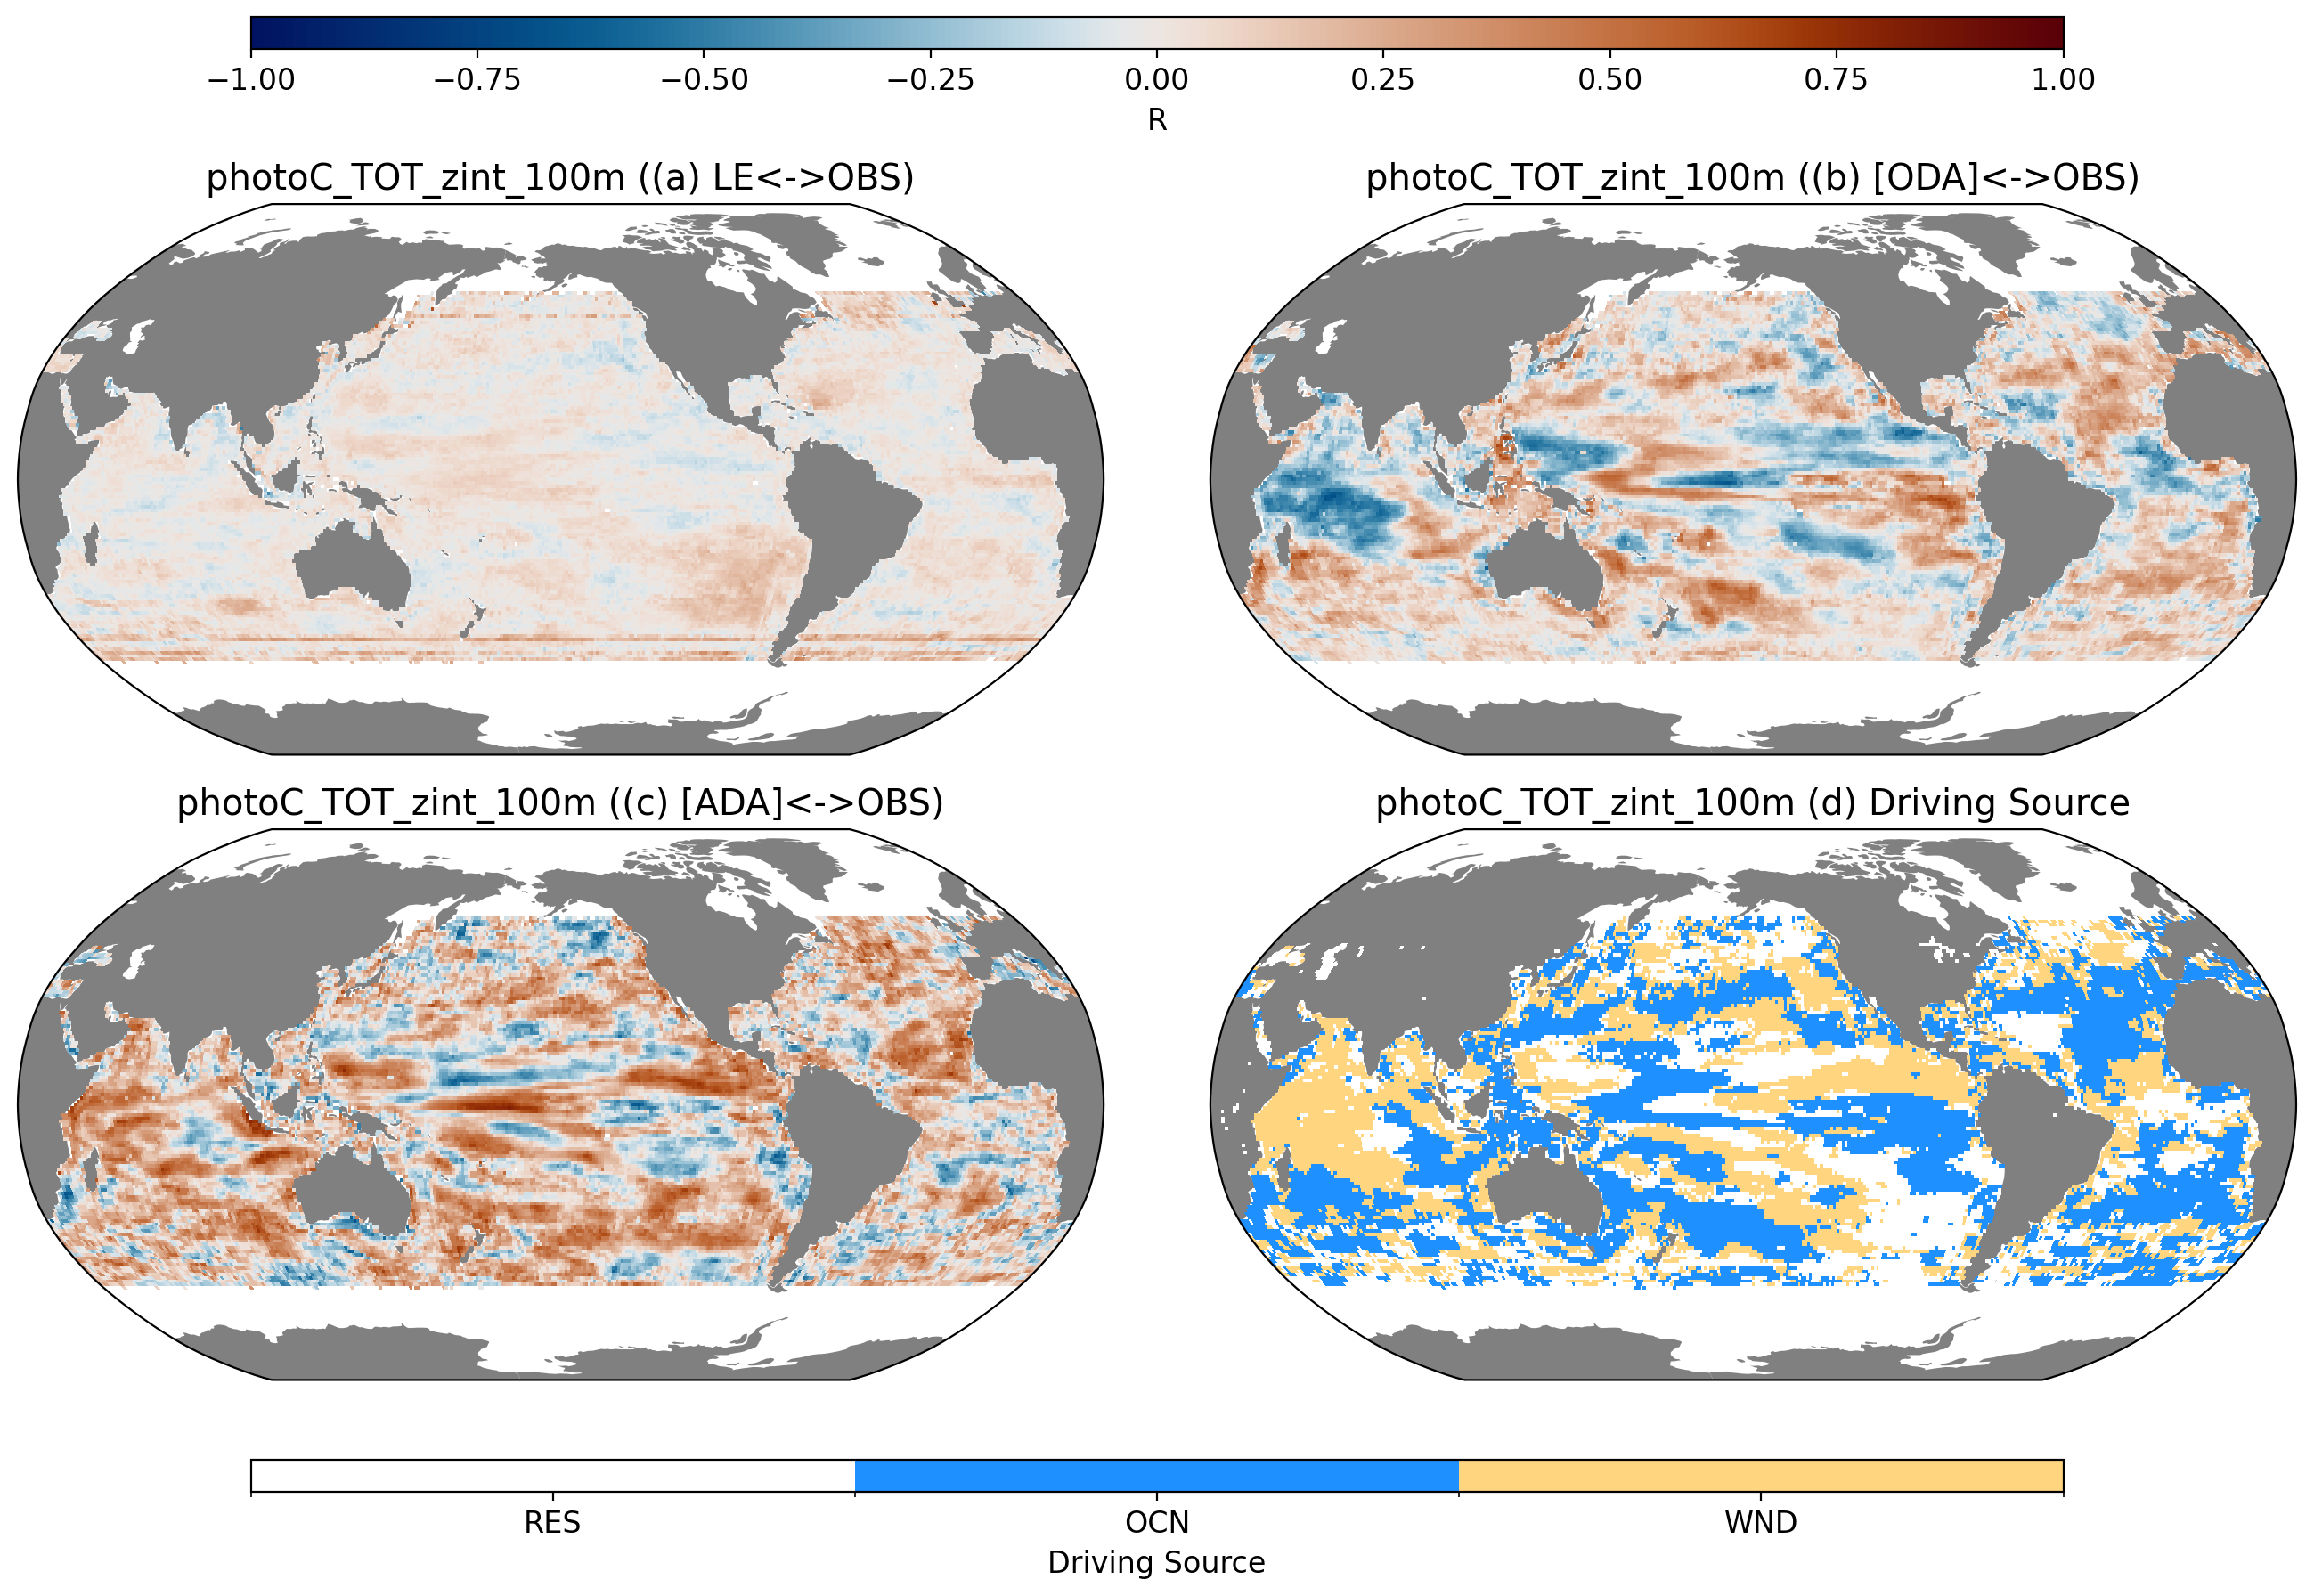

In [68]:
from scipy.stats import ttest_1samp

land_feature = cfeature.LAND.with_scale('110m')


varn=cfg_var_photoC_TOT_zint_100m.var
# plot for LE

projection = ccrs.Robinson(central_longitude=205)
cbar_kwargs={'orientation':'horizontal','pad':0.05,'shrink':0.7, 'label':' R ', 'aspect':33, 'extend': 'both'}

# 서브플롯 생성
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(18.5, 9), 
             dpi=200, facecolor='w', edgecolor='k', subplot_kw={'projection': projection})

data_array = corr_photoC_TOT_zint_100m_OBS_LE.median(dim='ens_LE')
data_array = data_array.where(cfg_var_photoC_TOT_zint_100m.OBS_ds['mask_80_percent'] == 1, np.NaN)
plt1=data_array.plot.pcolormesh(ax=axes[0, 0], transform=ccrs.PlateCarree(), vmax=1, vmin=-1,cmap=cm.vik, add_colorbar=False)
axes[0, 0].set_title(f'{varn} ((a) LE<->OBS)')
axes[0, 0].add_feature(land_feature, facecolor='gray', edgecolor='none')
    
# plot for (ODA)
data_array = corr_photoC_TOT_zint_100m_OBS_ODA_diff.median(dim='ens_ODA')
data_array = data_array.where(cfg_var_photoC_TOT_zint_100m.OBS_ds['mask_80_percent'] == 1, np.NaN)
plt1=data_array.plot.pcolormesh(ax=axes[0, 1], transform=ccrs.PlateCarree(), vmax=1, vmin=-1,cmap=cm.vik, add_colorbar=False)
axes[0, 1].set_title(f'{varn} ((b) [ODA]<->OBS)')
axes[0, 1].add_feature(land_feature, facecolor='gray', edgecolor='none')

# plot for (ADA)
data_array = corr_photoC_TOT_zint_100m_OBS_ADA_diff.median(dim='ens_ADA')
data_array = data_array.where(cfg_var_photoC_TOT_zint_100m.OBS_ds['mask_80_percent'] == 1, np.NaN)
plt1=data_array.plot.pcolormesh(ax=axes[1, 0], transform=ccrs.PlateCarree(), vmax=1, vmin=-1,cmap=cm.vik, add_colorbar=False)
axes[1, 0].set_title(f'{varn} ((c) [ADA]<->OBS)')
axes[1, 0].add_feature(land_feature, facecolor='gray', edgecolor='none')


# plot for (WND ODA mask)
alpha = 0.10

t_stat_LE, p_values_LE = ttest_1samp(corr_photoC_TOT_zint_100m_OBS_LE, 0, axis=2)
ds_LE = corr_photoC_TOT_zint_100m_OBS_LE.median(dim='ens_LE').where(p_values_LE < alpha)

t_stat_ODA, p_values_ODA = ttest_1samp(corr_photoC_TOT_zint_100m_OBS_ODA_diff, 0, axis=2)
ds_ODA = corr_photoC_TOT_zint_100m_OBS_ODA_diff.median(dim='ens_ODA').where(p_values_ODA < alpha)

t_stat_ADA, p_values_ADA = ttest_1samp(corr_photoC_TOT_zint_100m_OBS_ADA_diff, 0, axis=2)
ds_ADA = corr_photoC_TOT_zint_100m_OBS_ADA_diff.median(dim='ens_ADA').where(p_values_ADA < alpha)

threshold = 0
mask_LE = ds_LE > threshold
mask_ODA = ds_ODA > threshold
mask_ADA = ds_ADA > threshold

ds_all = xr.Dataset(
    data_vars=dict(
        colors=(('lat', 'lon'), np.full(ds_LE.shape, 0.33))  # 'colors'라는 변수 추가
    ),
    coords=dict(
        lat=(('lat'), mask_LE.lat.data),  # DataArray의 .data 사용
        lon=(('lon'), mask_LE.lon.data)     # DataArray의 .data 사용
    )
)

# ds_all['colors'] = xr.where(ds_grid.REGION_MASK == 0, 0.0, ds_all['colors']) # 흰색
ds_all['colors'] = xr.where(mask_LE.isnull(), 0.0, ds_all['colors']) # 흰색
ds_all['colors'] = xr.where(mask_ODA & ~mask_ADA, 0.5, ds_all['colors'])  # 파란색
ds_all['colors'] = xr.where(mask_ODA & mask_ADA, 0.5, ds_all['colors'])  # 파란색
ds_all['colors'] = xr.where(~mask_ODA & mask_ADA, 1.0, ds_all['colors'])  # 주황색
ds_all['colors'] = xr.where(mask_LE & ~mask_ODA, 0, ds_all['colors'])  # 주황색

colors_custom = ['#FFFFFF',  # 흰색 (White)
          '#1E90FF',  # Dodger blue (ODA)
          '#FFD580']  # 파스텔 오렌지 (WND) 

ds_all = ds_all.where(cfg_var_photoC_TOT_zint_100m.OBS_ds['mask_80_percent'] == 1, np.NaN)

# Define boundaries so each color covers exactly one bin:
bounds = [0, 0.5, 1, 1.5]  # or [0, 0.33, 0.66, 1] if your data is in [0..1]
cmap = mcolors.ListedColormap(colors_custom)
norm = mcolors.BoundaryNorm(bounds, cmap.N)

plt4=ds_all['colors'].plot.pcolormesh(ax=axes[1, 1], transform=ccrs.PlateCarree(), cmap=mcolors.ListedColormap(colors_custom), add_colorbar=False, norm=norm)
axes[1, 1].set_title(f'{varn} (d) Driving Source')
axes[1, 1].add_feature(land_feature, facecolor='gray', edgecolor='none')


# (a), (b), (c) 서브플롯에 대해 위쪽에 큰 컬러바 추가
cbar_a_c = fig.add_axes([0.1, 0.95, 0.55, 0.02])  # [left, bottom, width, height] 비율로 컬러바 위치와 크기 설정
cbar1 = plt.colorbar(plt1, cax=cbar_a_c, orientation='horizontal')
cbar1.set_label('R')

# (d) 서브플롯에 대해 아래쪽에 큰 컬러바 추가
cbar_d = fig.add_axes([0.1, 0.05, 0.55, 0.02])  # [left, bottom, width, height] 비율로 컬러바 위치와 크기 설정
# cbar2= plt.colorbar(plt4, cax=cbar_d, orientation='horizontal')
cbar2 = plt.colorbar(plt4, cax=cbar_d, orientation='horizontal',
                     boundaries=bounds, ticks=[0.25, 0.75, 1.25])
cbar2.set_label('Driving Source')
# num_colors = len(colors_custom)
# tick_locs = np.linspace(0.5 / num_colors, 1 - 0.5 / num_colors, num_colors)
# tick_locs = np.linspace(0.25, 0.75, 3)
# cbar2.set_ticks(tick_locs)  # 눈금 설정
cbar2.set_ticklabels(['RES', 'OCN', 'WND'])  # 눈금 레이블 설정

plt.rcParams.update({'font.size': 12})

# 전체 레이아웃 조정
plt.tight_layout(rect=[0, 0.1, 0.75, 0.9])  # 상단과 하단의 레이아웃 여백을 맞추기 위해 rect 설정
# plt.tight_layout()
plt.savefig(savefilepath +"/BGC_Pred_SFig2.tif", format='tiff', dpi=150, bbox_inches='tight')
plt.show()



In [ ]:
corr_gv_u_surf_OBS_LE_smth = xr.corr(cfg_var_gv_u_surf.OBS_ds_yearly_smth, cfg_var_gv_u_surf.LE_ds_smth['gv_u_surf'], dim='year').compute()
corr_gv_u_surf_OBS_ODA_smth = xr.corr(cfg_var_gv_u_surf.OBS_ds_yearly_smth, cfg_var_gv_u_surf.ODA_ds_smth['gv_u_surf'], dim='year').compute()
corr_gv_u_surf_OBS_ODA_diff_smth = xr.corr(cfg_var_gv_u_surf.OBS_ds_yearly_smth, cfg_var_gv_u_surf.ODA_ds_smth['gv_u_surf']-cfg_var_gv_u_surf.LE_ds_smth['gv_u_surf'].mean(dim='ens_LE'), dim='year').compute()
corr_gv_u_surf_OBS_ADA_smth = xr.corr(cfg_var_gv_u_surf.OBS_ds_yearly_smth, cfg_var_gv_u_surf.ADA_ds_smth['gv_u_surf'], dim='year').compute()
corr_gv_u_surf_OBS_ADA_diff_smth = xr.corr(cfg_var_gv_u_surf.OBS_ds_yearly_smth, cfg_var_gv_u_surf.ADA_ds_smth['gv_u_surf']-cfg_var_gv_u_surf.ODA_ds_smth['gv_u_surf'].mean(dim='ens_ODA'), dim='year').compute()

corr_gv_v_surf_OBS_LE_smth = xr.corr(cfg_var_gv_v_surf.OBS_ds_yearly_smth, cfg_var_gv_v_surf.LE_ds_smth['gv_v_surf'], dim='year').compute()
corr_gv_v_surf_OBS_ODA_smth = xr.corr(cfg_var_gv_v_surf.OBS_ds_yearly_smth, cfg_var_gv_v_surf.ODA_ds_smth['gv_v_surf'], dim='year').compute()
corr_gv_v_surf_OBS_ODA_diff_smth = xr.corr(cfg_var_gv_v_surf.OBS_ds_yearly_smth, cfg_var_gv_v_surf.ODA_ds_smth['gv_v_surf']-cfg_var_gv_v_surf.LE_ds_smth['gv_v_surf'].mean(dim='ens_LE'), dim='year').compute()
corr_gv_v_surf_OBS_ADA_smth = xr.corr(cfg_var_gv_v_surf.OBS_ds_yearly_smth, cfg_var_gv_v_surf.ADA_ds_smth['gv_v_surf'], dim='year').compute()
corr_gv_v_surf_OBS_ADA_diff_smth = xr.corr(cfg_var_gv_v_surf.OBS_ds_yearly_smth, cfg_var_gv_v_surf.ADA_ds_smth['gv_v_surf']-cfg_var_gv_v_surf.ODA_ds_smth['gv_v_surf'].mean(dim='ens_ODA'), dim='year').compute()
